In [1]:
%reload_ext autoreload
%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters, SGXConverter
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

In [4]:
SGXConverter.convert_sgx_to_csv()

Found 0 SGX files.
Found 2 CSV files. Proceeding with analysis...


# Read Data

Let's first read in the meta data of all models in the dataset.

In [5]:
df_meta = parser.parse_model_metadata()
df_meta.head()
#df_meta.loc["1ba744cbcafb46c2a52482e36498a9bf"] # <- test model

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba744cbcafb46c2a52482e36498a9bf  301bfb5af53c431a830a6e435de6a590   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba744cbcafb46c2a52482e36498a9bf  8af3fc1bb4b74e7c8c4089e4921d9056   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   

                                             datetime description  \
model_id                                                            
1ba74449e9354d0c9d4798b4a6e915d0  2019-03-19 11:36:50         NaN   
1ba744cbcafb46c2a52482e36498a9bf  2020-03-23 17:26:03         NaN   
1ba7587b3191422fb03a0e9ba92cebff  2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc  2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b  2020-06-30 07:12:48         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba744cbcafb46c2a52482e36498a9bf                  Receipt of Application  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba744cbcafb46c2a52482e36498a9bf  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [6]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [7]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [8]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

9314

This is the percentage of example process from the dataset:

In [9]:
len(df_meta_examples)/len(df_meta)

0.4657

This is the number of models in the dataset without example processes (again, based on process names):

In [10]:
len(df_meta)-len(df_meta_examples)

10686

And the percentage of models in the dataset without example processes:

In [11]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5343

We apply the filter to perform the analysis on the dataset without examples processes:

In [12]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

10686

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [13]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [14]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
#df_notations = df_notations.replace({'Notation' : d_namespaces})

In [15]:
def map_namespaces(namespace):
    return d_namespaces.get(namespace, 'Unknown')
df_notations['Notation'] = df_notations['Notation'].map(lambda x: map_namespaces(x))
df_notations

Notation  Frequency
0                         BPMN 2.0       7816
1                              EPC        633
2                      Value Chain        470
3                         BPMN 1.1        311
4                    UML 2.2 Class        286
5                          DMN 1.0        260
6                        Petri Net        220
7                    ArchiMate 2.1        217
8                     UML Use Case        187
9            BPMN 2.0 Choreography         85
10                      Organigram         80
11           BPMN 2.0 Conversation         54
12               FMC Block Diagram         24
13                        CMMN 1.0         18
14                     Journey Map          8
15                        YAWL 2.2          7
16                             CPN          5
17                          jBPM 4          2
18                          XForms          2
19  Process Documentation Template          1

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
if df_notations['Notation'].nunique() > 3:
    df_notations = DataFilter(df_notations)
    df_notations = df_notations.filter_data("namespaces", "max", 5)
df_notations

Notation  Frequency
0                BPMN 2.0       7816
1                     EPC        633
2             Value Chain        470
3                BPMN 1.1        311
4           UML 2.2 Class        286
5                 DMN 1.0        260
6               Petri Net        220
7           ArchiMate 2.1        217
8            UML Use Case        187
9   BPMN 2.0 Choreography         85
10             Organigram         80
11  BPMN 2.0 Conversation         54
12      FMC Block Diagram         24
13               CMMN 1.0         18
14            Journey Map          8
15               YAWL 2.2          7
16                  Other          5
17                    CPN          5

We can visualise the number of models in different modeling notations.

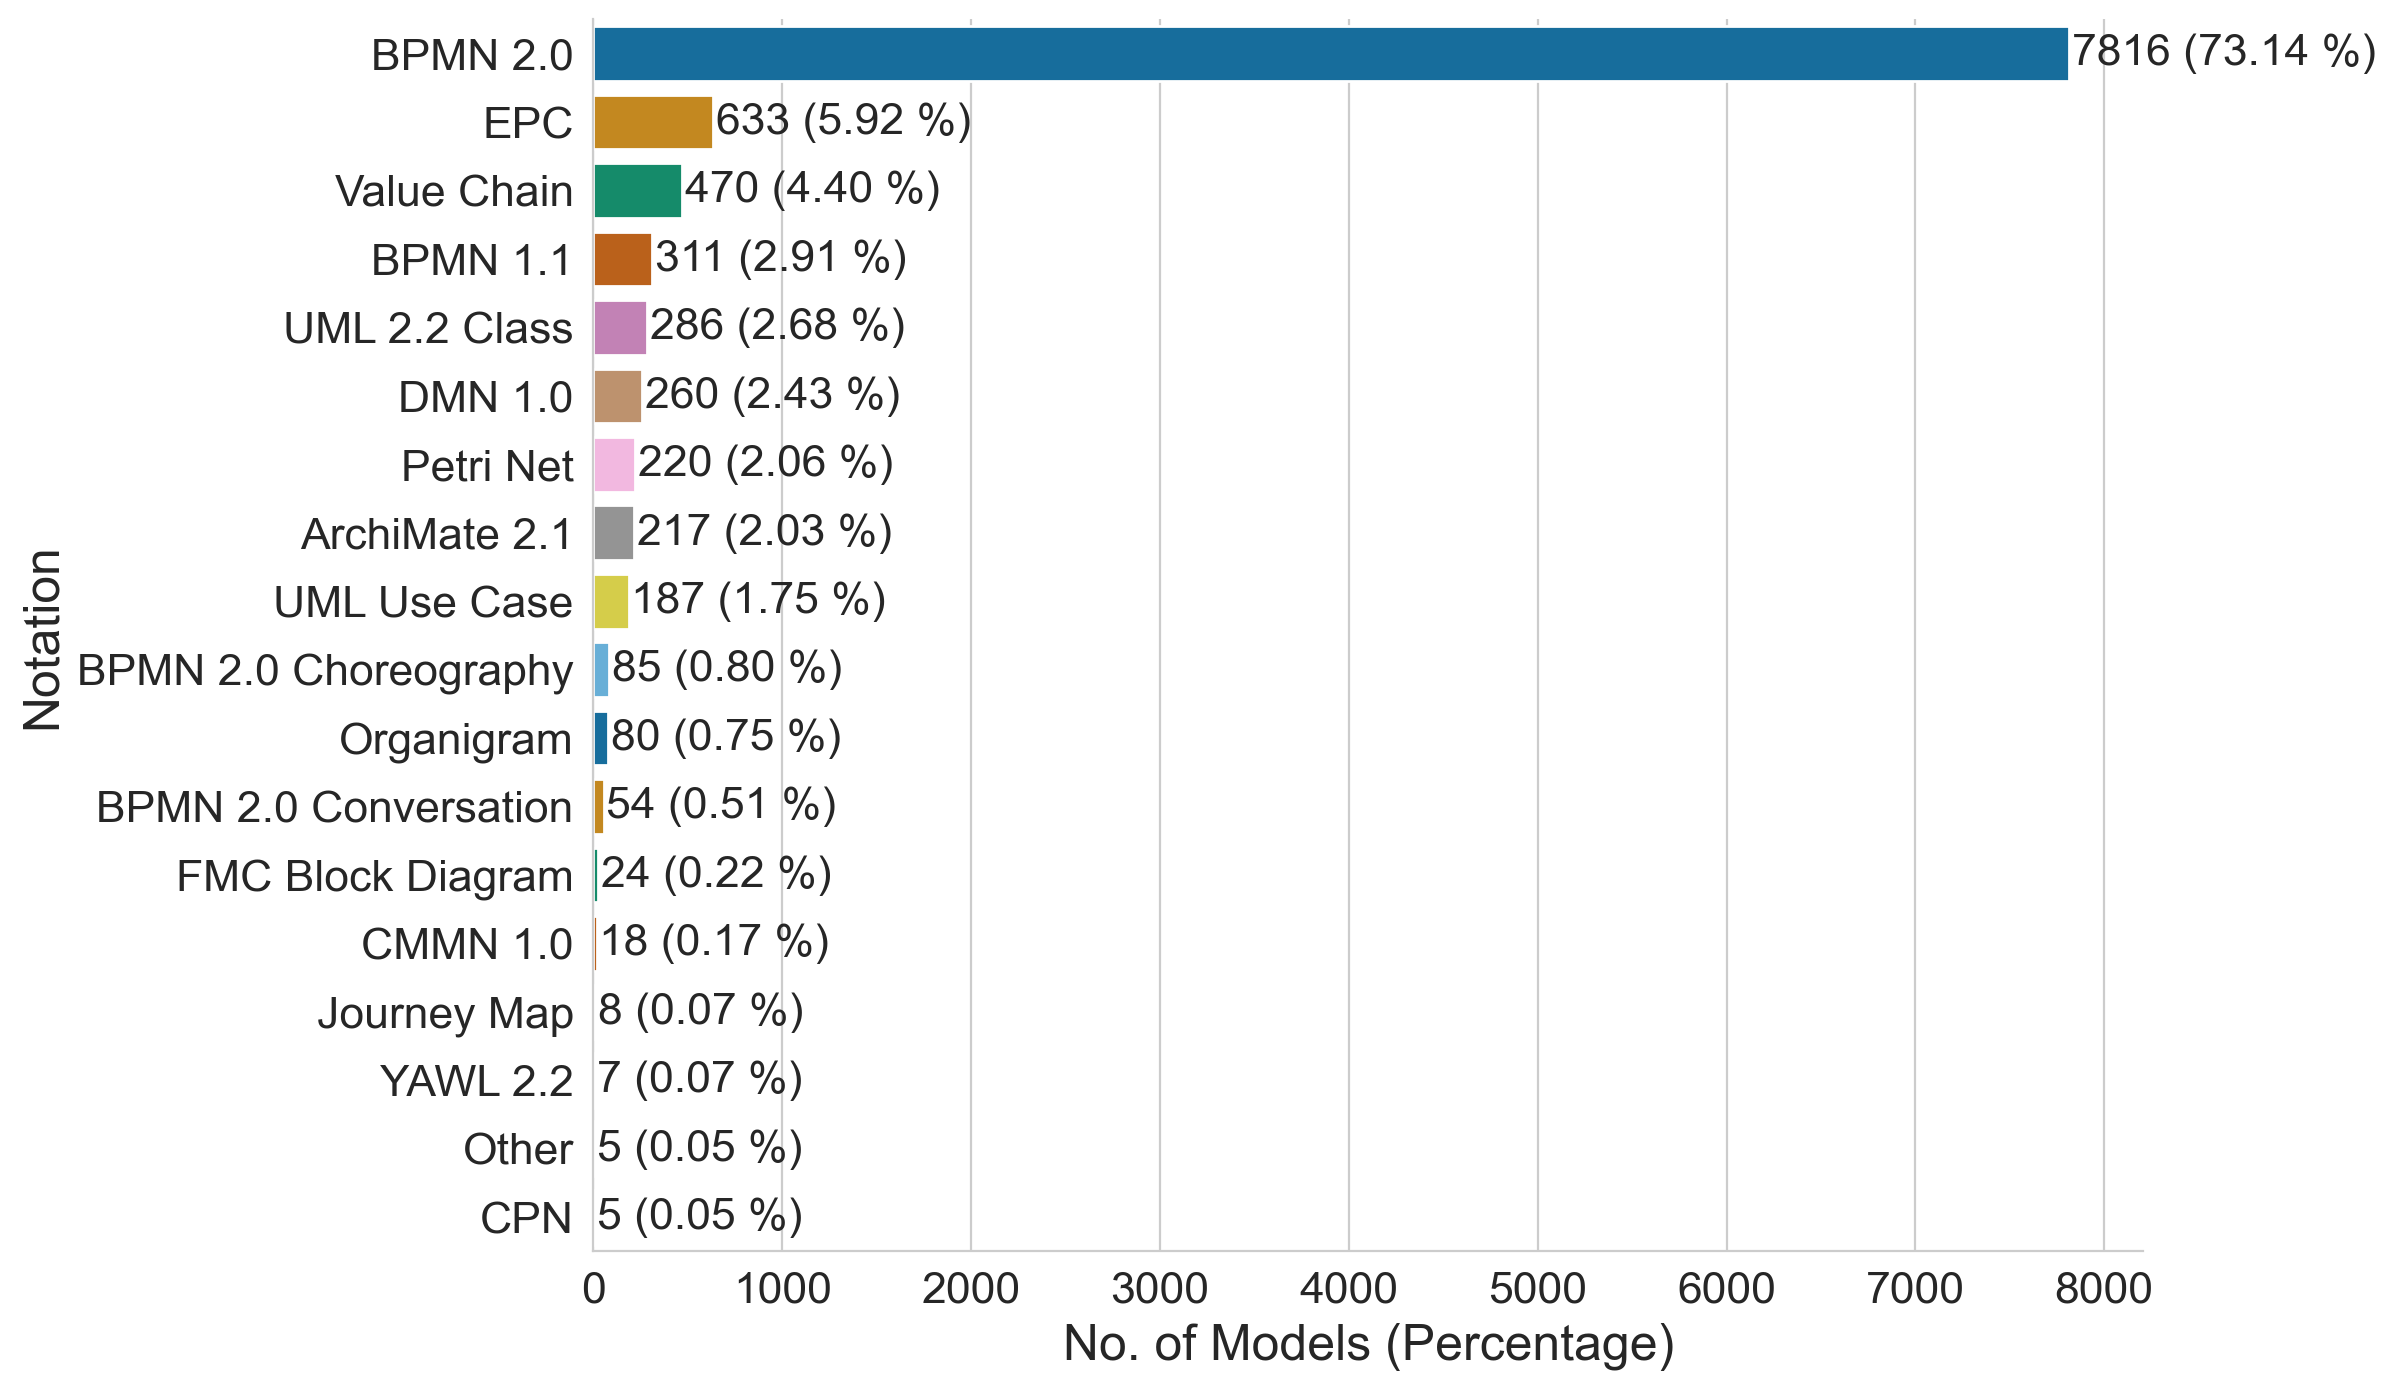

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
containers_nb = df_notations['Notation'].nunique()
ax=sns.barplot(x="Frequency",y="Notation",hue="Notation",data=df_notations,estimator = np.max, errorbar=('ci', 0),palette = sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
labels = [f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
sns.despine()
#ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
644a4899917b42c687b2cabc9f8742cd  ef38dd22174d40ba894df30e5ccf4a1b   

                                                   organization_id  \
model_id                                                             
644a4899917b42c687b2cabc9f8742cd  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
644a4899917b42c687b2cabc9f8742cd 2011-12-02 14:31:23         NaN   

                                                     name       type  \
model_id                                                               
644a4899917b42c687b2cabc9f8742cd  Aufgabe - 4 Philosophen  Petrinets   

                                                             namespace  
model_id                                                                
644a4899917b42c687b2cabc9f8742cd  http://b3mn.org/stencilset/petrinet#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
6540f5105d584712aa5489d6390569f9  7f9d9ec81a90417d99ec7193267c2222   

                                                   organization_id  \
model_id                                                             
6540f5105d584712aa5489d6390569f9  a44023786dc644adadc423ba4873ee09   

                                            datetime description  \
model_id                                                           
6540f5105d584712aa5489d6390569f9 2021-09-21 22:29:51         NaN   

                                                            name type  \
model_id                                                                
6540f5105d584712aa5489d6390569f9  Blockchain or Central Database  NaN   

                                                            namespace  
model_id                                                               
6540f5105d584712aa5489d6390569f9  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#       7816
1                  http://b3mn.org/stencilset/epc#        633
2  http://www.signavio.com/stencilsets/processmap#        470
3              http://b3mn.org/stencilset/bpmn1.1#        311
4          http://b3mn.org/stencilset/UML2.2Class#        286

In [22]:
# handling the case where we have unknown namespaces in the dataset
# to inspect the unknown namespaces, comment the following line out:
#print(df_meta['namespace'].value_counts())
namespaces = mappings['namespaces'].keys()
df_meta['namespace'] = df_meta['namespace'].apply(lambda x: x if x in namespaces else 'Unknown')

In [23]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [24]:
df_meta_selected = df_meta_selected.groupby('namespace',observed=False).resample('YE').sum(numeric_only=True,min_count=1)
df_meta_selected = df_meta_selected['Count'].fillna(0)
df_meta_selected = df_meta_selected.reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [25]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0, observed=False)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class    7.0  2015
1  UML 2.2 Class   19.0  2016
2  UML 2.2 Class   32.0  2017
3  UML 2.2 Class   23.0  2018
4  UML 2.2 Class   21.0  2019

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [26]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

1

In [27]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2024]
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class    7.0  2015
1  UML 2.2 Class   19.0  2016
2  UML 2.2 Class   32.0  2017
3  UML 2.2 Class   23.0  2018
4  UML 2.2 Class   21.0  2019

In [28]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

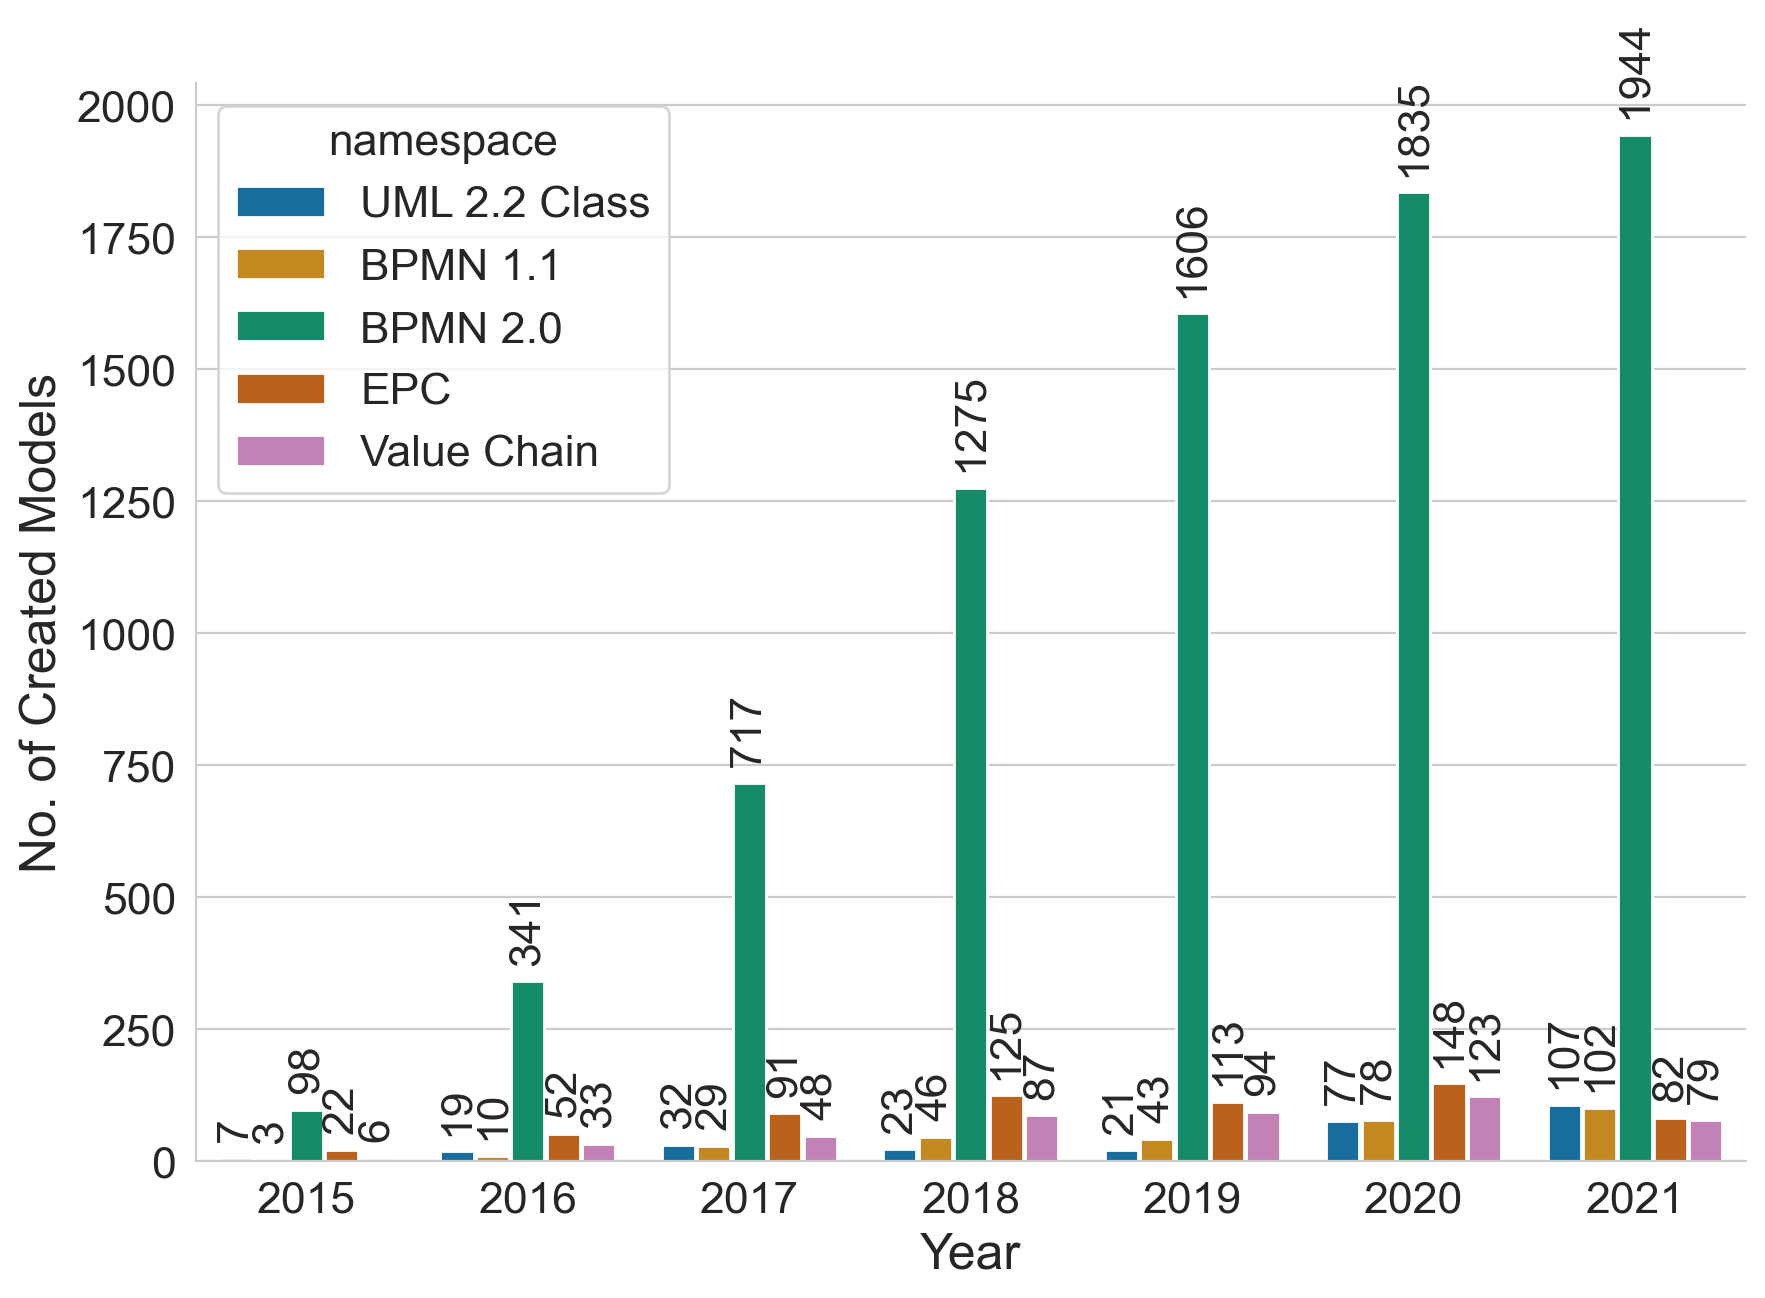

In [29]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax)
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [30]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0    EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2021    1944.0   82.0         79.0     102.0          107.0
2020    1835.0  148.0        123.0      78.0           77.0
2019    1606.0  113.0         94.0      43.0           21.0
2018    1275.0  125.0         87.0      46.0           23.0
2017     717.0   91.0         48.0      29.0           32.0
2016     341.0   52.0         33.0      10.0           19.0
2015      98.0   22.0          6.0       3.0            7.0

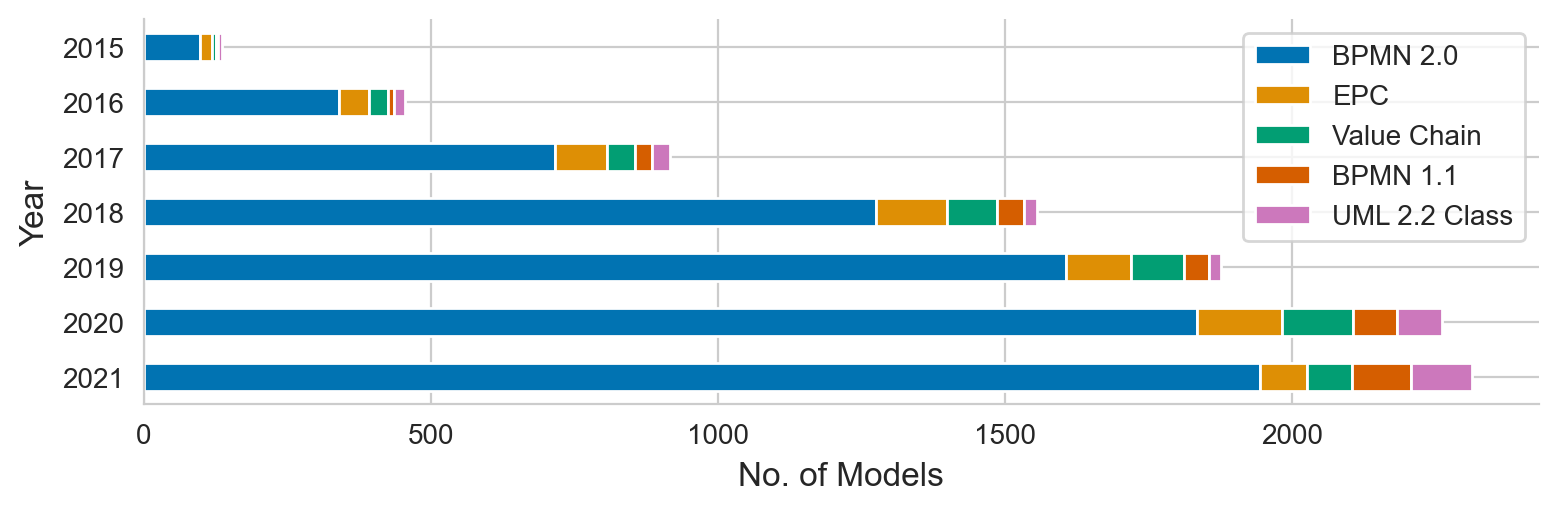

In [31]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [32]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   
1ba7b40cfd804781a4aaa394635d1760  e47efaa6dcde4a4586b7ffcb301996d5   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   
1ba7b40cfd804781a4aaa394635d1760  c41660388a04449a995dccf97d894f46   

                                            datetime description  \
model_id                                                           
1ba74449e9354d0c9d4798b4a6e915d0 2019-03-19 11:36:50         NaN   
1ba7587b3191422fb03a0e9ba92cebff 2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc 2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b 2020-06-30 07:12:48         NaN   
1ba7b40cfd804781a4aaa394635d1760 2019-06-12 03:11:21         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4  NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#  
1ba7b40cfd804781a4aaa394635d1760  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [33]:
len(df_meta_bpmn)

7816

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [34]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|█████████████████████████████████████████████| 2/2 [00:24<00:00, 12.08s/it]


category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                           name  
model_id                         element_id                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  Pivo  
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Pivo  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  Pivo

Number of BPMN 2.0 models from the parser:

In [35]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

11783

Number of BPMN 2.0 models from the parser after filtering out example processes, models with less than 5 elements, and models with no task, start event or end event elements:

In [36]:
df_bpmn = DataFilter(df_bpmn).filter_data("example_processes_bpmn")
df_bpmn = DataFilter(df_bpmn).filter_data("models", 5)

Filtering out example processes models...
Keeping 7566 out of 11783 from the dataset
Dataset has been filtered down to 7566 models, a decrease of 35.79%.

Filtering out models with less than 5 elements...
Keeping 7477 out of 7566 from the dataset
Filtering out models with no start, end, or task elements...
Keeping 6913 out of 7477 from the dataset

Dataset has been filtered down to 6913 models, a decrease of 8.63%.


When compared to the analysis of the dataset metadata, we notice that after the example processes filtering, the count of BPMN 2.0 models is slightly lower. This difference shows there are some empty BPMN 2.0 models in the dataset, which do not contain any elements and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [37]:
len(df_bpmn)

364121

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [38]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...
✓ Download and installation successful


In [39]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|███████████████████████████████████████| 6913/6913 [01:48<00:00, 63.91it/s]


label  \
model_id                                                                              
1ba7587b3191422fb03a0e9ba92cebff   Yes No Organization\n Employee Meeting confir...   
1ba77121c3be44d6bd0b354727f9707b   Kunde  "DESADV"\n geht ein Auftrags-\nE-Mail ...   
1ba7b40cfd804781a4aaa394635d1760   Event Administrator Publish Event Customise E...   
1ba7baf108a4487fa83319991037649c  costume is not ok  repair the costume costume ...   
1ba86cde84044d8e8c1b244d2a507272   YES NO Bring vaccinee to emergency department...   

                                                                    name  \
model_id                                                                   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen    
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4   
1ba7baf108a4487fa83319991037649c                    Costumes Preparation   
1ba86cde84044d8e8c1b244d2a507272                        Observe vaccinee   

                                 detected_natural_language  
model_id                                                    
1ba7587b3191422fb03a0e9ba92cebff                        en  
1ba77121c3be44d6bd0b354727f9707b                        de  
1ba7b40cfd804781a4aaa394635d1760                        en  
1ba7baf108a4487fa83319991037649c                        en  
1ba86cde84044d8e8c1b244d2a507272                        en

Let's plot the use of different languages across the dataset.

In [40]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [41]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English           3358
1                       German           1883
2                      Italian            334
3                      Spanish            301
4                       French            174
5                     Croatian            147
6                   Portuguese            124
7                     Estonian             92
8                    Slovenian             74
9                     Romanian             70
10                       Dutch             62
11                  Indonesian             47
12                     Swedish             42
13                      Polish             31
14  Unknown language [UNKNOWN]             28
15                   Hungarian             22
16                       Greek             18
17                      Danish             14
18                   Norwegian             10
19                     Finnish             10
20                     Catalan              9
21                  Vietnamese              8
22                     Turkish              8
23                       Welsh              7
24                   Afrikaans              6
25                     Latvian              5
26                    Japanese              5
27                    Albanian              4
28                     Tagalog              4
29                       Czech              3
30    Unknown language [zh-cn]              3
31                      Somali              2
32                  Macedonian              2
33                      Slovak              2
34                      Korean              1
35                     Russian              1
36                  Lithuanian              1
37                     Persian              1

We only plot the 10 most common languages.

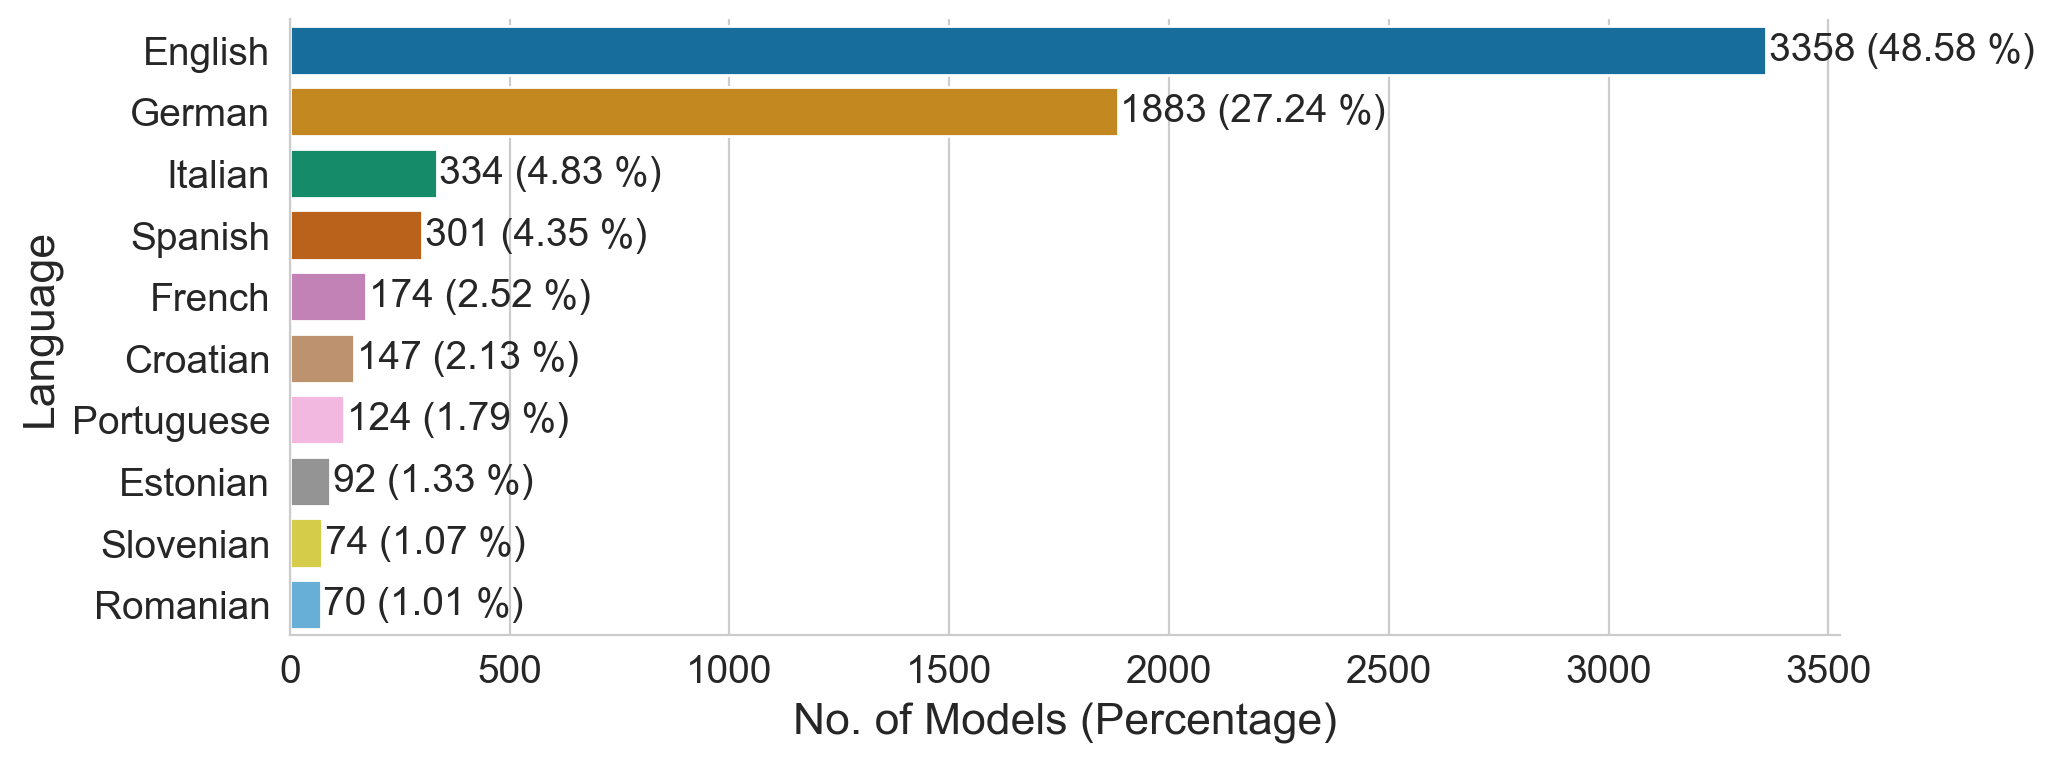

In [42]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", hue="Language", data=df_lang)
labels = [f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
#ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=)
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [43]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [44]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0).convert_dtypes() # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|█████████████████████████████████████| 6913/6913 [00:01<00:00, 4308.09it/s]


SequenceFlow  Pool  Lane  EndNoneEvent  Task  StartNoneEvent  \
0            17     1     3             2    12               1   
1            25     2     5             4    12               1   
2             5     1     1             1     0               1   
3             9     0     0             1     5               1   
4            17     0     0             1     9               1   

   Exclusive_Databased_Gateway  total_count  Association_Undirected  \
0                            2           38                       0   
1                            0           66                       2   
2                            0           13                       0   
3                            2           18                       0   
4                            3           33                       0   

   Association_Unidirectional  MessageFlow  IntermediateMessageEventCatching  \
0                           0            0                                 0   
1                           1            1                                 1   
2                           0            0                                 0   
3                           0            0                                 0   
4                           0            0                                 0   

   IntermediateMessageEventThrowing  ITSystem  ParallelGateway  \
0                                 0         0                0   
1                                 2         2                3   
2                                 0         0                0   
3                                 0         0                0   
4                                 0         0                0   

   StartConditionalEvent  DataObject  IntermediateConditionalEvent  \
0                      0           0                             0   
1                      3           1                             1   
2                      0           0                             0   
3                      0           0                             0   
4                      0           0                             0   

   CollapsedSubprocess  EndTerminateEvent  IntermediateTimerEvent  \
0                    0                  0                       0   
1                    0                  0                       0   
2                    4                  0                       0   
3                    0                  0                       0   
4                    0                  1                       1   

   EventbasedGateway  CollapsedPool  StartMessageEvent  TextAnnotation  \
0                  0              0                  0               0   
1                  0              0                  0               0   
2                  0              0                  0               0   
3                  0              0                  0               0   
4                  0              0                  0               0   

   Subprocess  IntermediateEvent  InclusiveGateway  DataStore  \
0           0                  0                 0          0   
1           0                  0                 0          0   
2           0                  0                 0          0   
3           0                  0                 0          0   
4           0                  0                 0          0   

   EndMessageEvent  EventSubprocess  StartTimerEvent  IntermediateErrorEvent  \
0                0                0                0                       0   
1                0                0                0                       0   
2                0                0                0                       0   
3                0                0                0                       0   
4                0                0                0                       0   

   IntermediateLinkEventCatching  IntermediateLinkEventThrowing  Message  \
0                              0                              0   

These are the statistics of the different element types per model:

In [45]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count      6913.0
mean     10.30175
std      4.007057
min           4.0
25%           7.0
50%          10.0
75%          13.0
max          30.0
dtype: Float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [46]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0)
    .convert_dtypes()
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
1ba7587b3191422fb03a0e9ba92cebff                          0   
1ba77121c3be44d6bd0b354727f9707b                          0   
1ba7b40cfd804781a4aaa394635d1760                          0   
1ba7baf108a4487fa83319991037649c                          0   
1ba86cde84044d8e8c1b244d2a507272                          0   

category                          Association_Undirected  \
model_id                                                   
1ba7587b3191422fb03a0e9ba92cebff                       0   
1ba77121c3be44d6bd0b354727f9707b                       2   
1ba7b40cfd804781a4aaa394635d1760                       0   
1ba7baf108a4487fa83319991037649c                       0   
1ba86cde84044d8e8c1b244d2a507272                       0   

category                          Association_Unidirectional  \
model_id                                                       
1ba7587b3191422fb03a0e9ba92cebff                           0   
1ba77121c3be44d6bd0b354727f9707b                           1   
1ba7b40cfd804781a4aaa394635d1760                           0   
1ba7baf108a4487fa83319991037649c                           0   
1ba86cde84044d8e8c1b244d2a507272                           0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
1ba7587b3191422fb03a0e9ba92cebff                         0              0   
1ba77121c3be44d6bd0b354727f9707b                         0              0   
1ba7b40cfd804781a4aaa394635d1760                         0              0   
1ba7baf108a4487fa83319991037649c                         0              0   
1ba86cde84044d8e8c1b244d2a507272                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
1ba7587b3191422fb03a0e9ba92cebff                    0                      0   
1ba77121c3be44d6bd0b354727f9707b                    0                      0   
1ba7b40cfd804781a4aaa394635d1760                    4                      0   
1ba7baf108a4487fa83319991037649c                    0                      0   
1ba86cde84044d8e8c1b244d2a507272                    0                      0   

category                          ComplexGateway  DataObject  DataStore  \
model_id                                                                  
1ba7587b3191422fb03a0e9ba92cebff               0           0          0   
1ba77121c3be44d6bd0b354727f9707b               0           1          0   
1ba7b40cfd804781a4aaa394635d1760               0           0          0   
1ba7baf108a4487fa83319991037649c               0           0          0   
1ba86cde84044d8e8c1b244d2a507272               0           0          0   

category                          EndCancelEvent  EndCompensationEvent  \
model_id                                                                 
1ba7587b3191422fb03a0e9ba92cebff               0                     0   
1ba77121c3be44d6bd0b354727f9707b               0                     0   
1ba7b40cfd804781a4aaa394635d1760               0                     0   
1ba7baf108a4487fa83319991037649c               0                     0   
1ba86cde84044d8e8c1b244d2a507272               0                     0   

category                          EndErrorEvent  EndEscalationEvent  \
model_id                                                              
1ba7587b3191422fb03a0e9ba92cebff              0                   0   
1ba77121c3be44d6bd0b354727f9707b              0                   0   
1ba7b40cfd804781a4aaa394635d1760              0                   0   
1ba7baf108a4487fa83319991037649c              0                   0   
1ba86cde84044d8e8c1b244d2a507272              0                   0   

category                          EndMessage

In [47]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
df_freq[df_freq["frequency"]/len(df_cnts) < 0.1].head()

category  frequency
23        InclusiveGateway        624
24              Subprocess        470
25         StartTimerEvent        405
26       EndTerminateEvent        403
27  IntermediateErrorEvent        281

In [48]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())

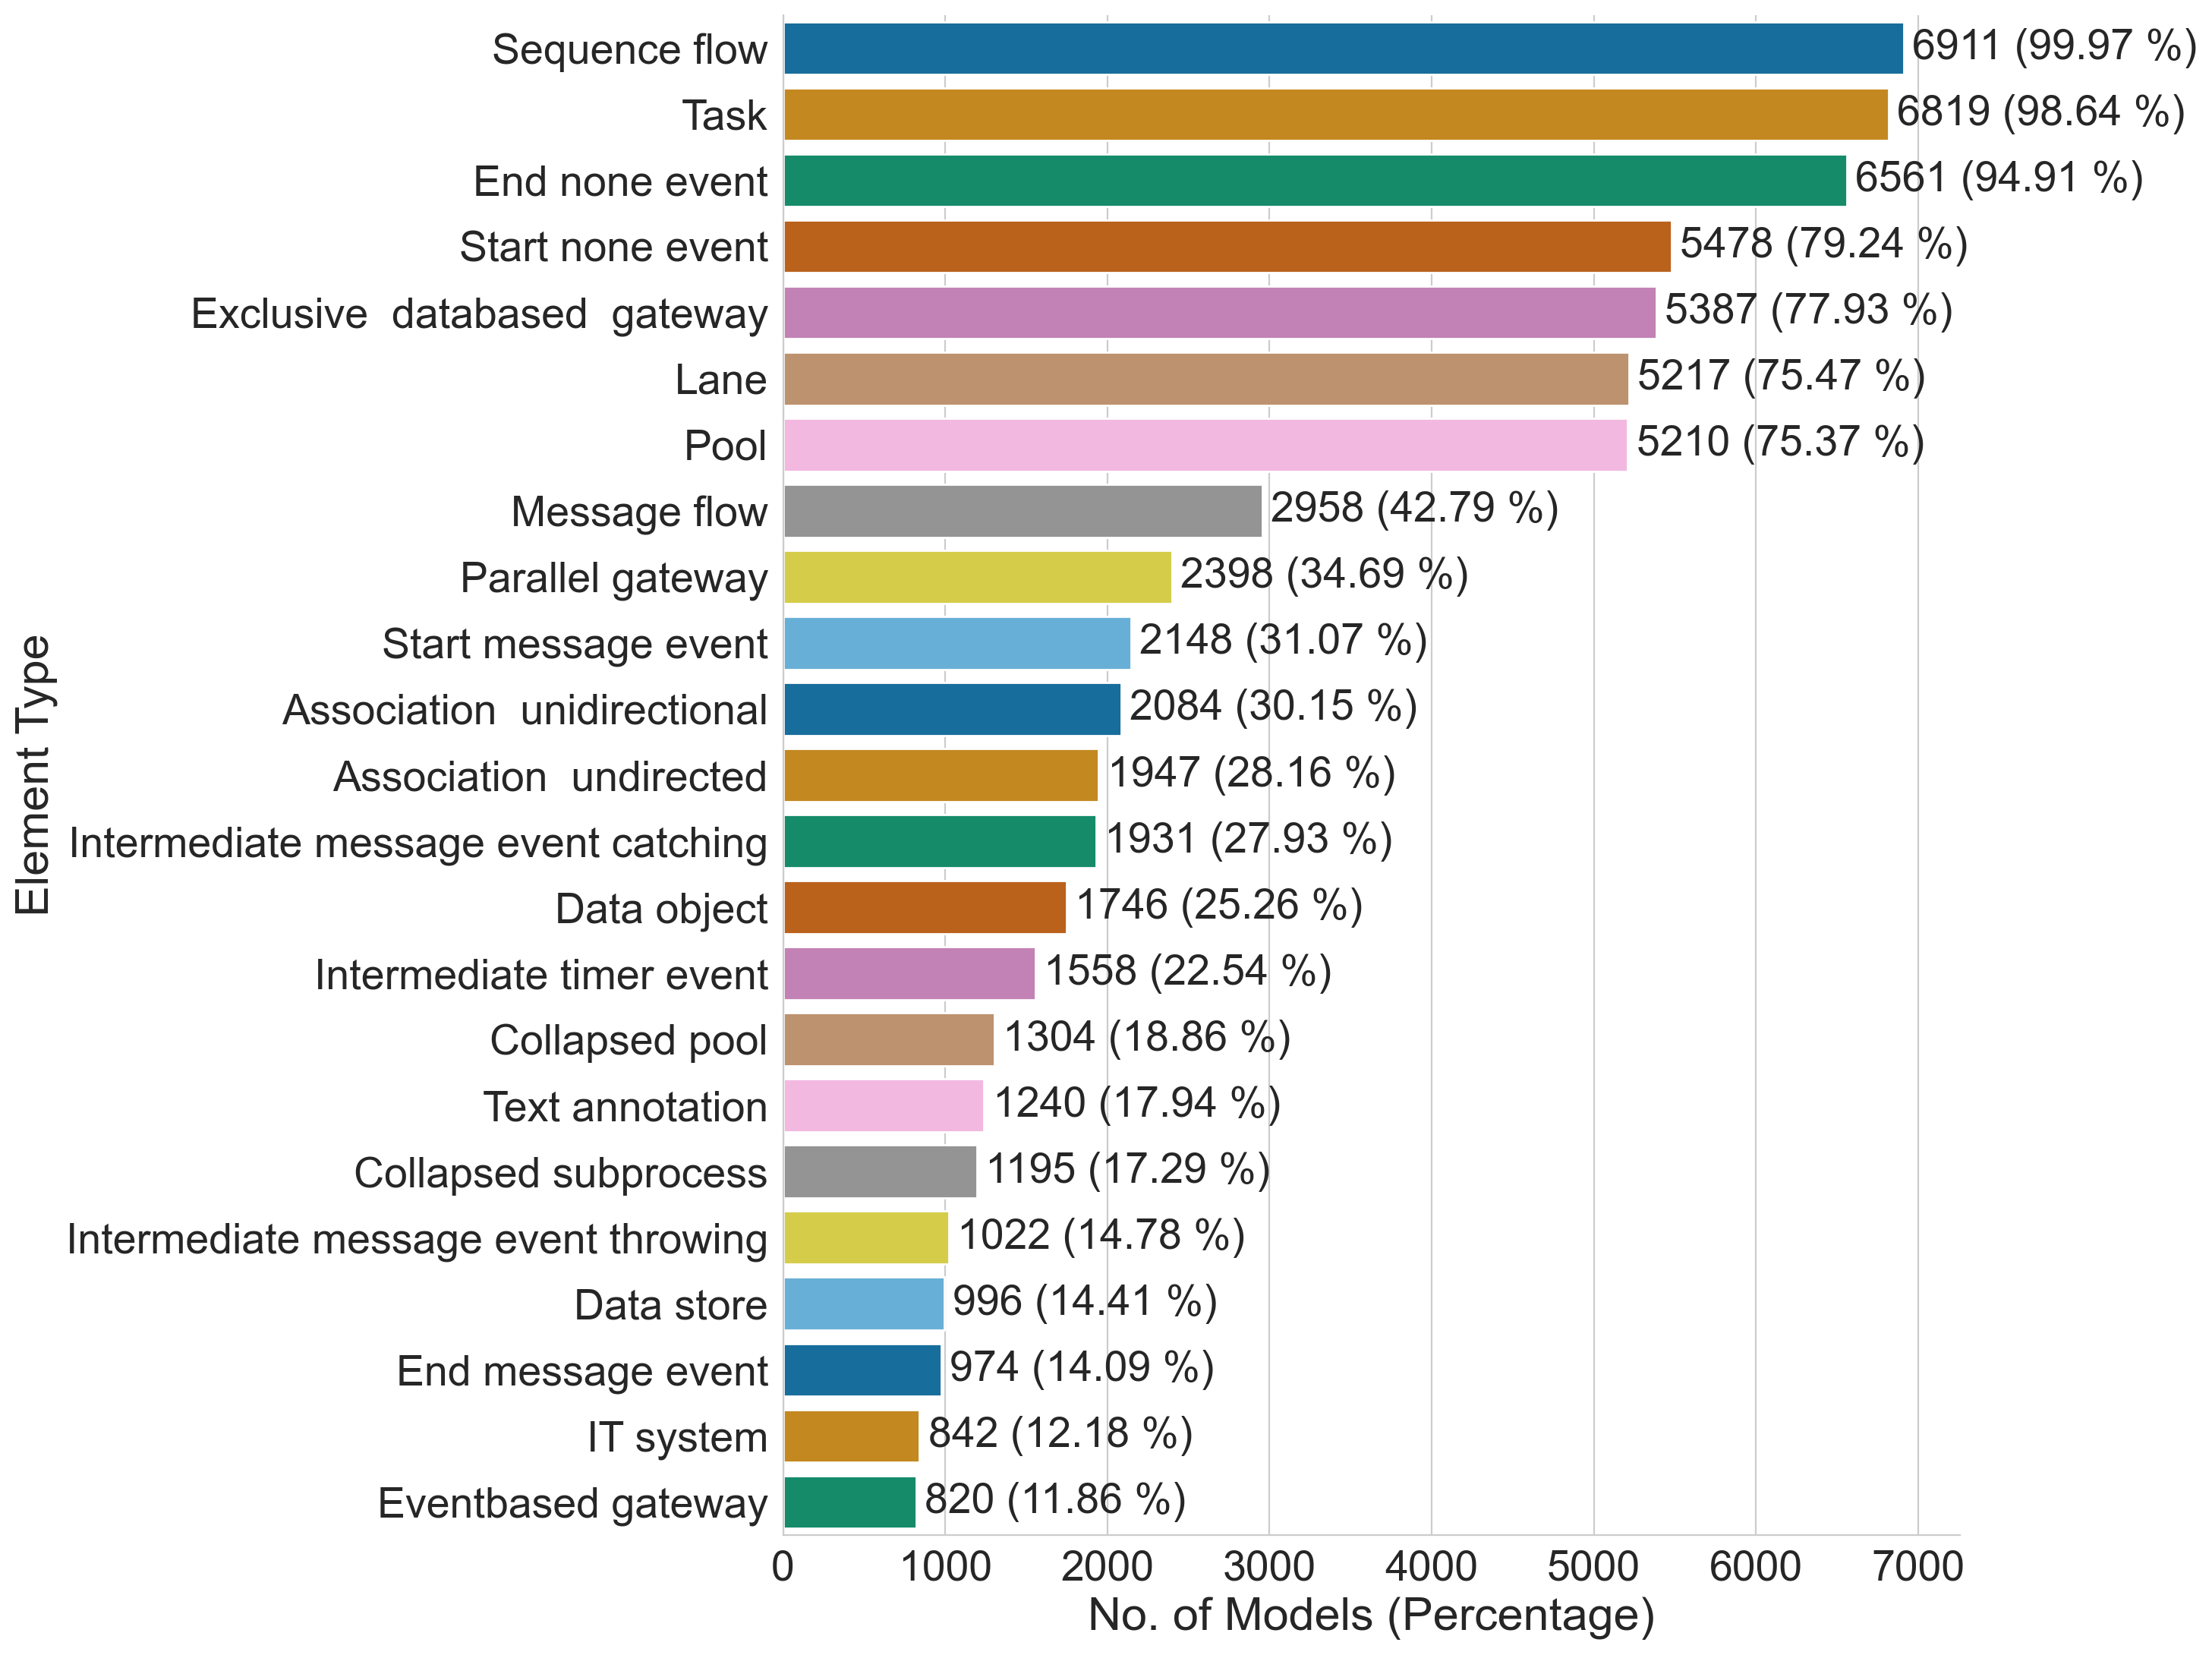

In [49]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
containers_nb = df_freq['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown.
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.barplot(x="frequency", y="category",hue="category", legend=False, data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
else:
    ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
total = len(df_cnts)
labels = [f'{val} ({val / total * 100.0:.2f} %)' for val in df_freq['frequency']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [50]:
df_bpmn.head()

category  \
model_id                         element_id                                               
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539  SequenceFlow   
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516  SequenceFlow   
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1  SequenceFlow   
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF  SequenceFlow   
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F  SequenceFlow   

                                                                          label  \
model_id                         element_id                                       
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539         
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516         
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1         
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF         
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539             None   
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516             None   
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1             None   
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF             None   
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F             None   

                                                                                               name  
model_id                         element_id                                                          
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539  710 BPMN Conference room  
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516  710 BPMN Conference room  
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1  710 BPMN Conference room  
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF  710 BPMN Conference room  
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F  710 BPMN Conference room

First, we calculate and visualize the total counts of business objects in the dataset.

In [51]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [52]:
total_bos_count = len(total_bos)
total_bos_count

2785

In [53]:
len(df_bpmn)

364121

When compared to the total number of elements, that would be about:

In [54]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

0.76%


Next, let's take a look at how many models have at least one glossary link.

In [55]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [56]:
len(models_w_bos)

887

The highest number of glossary links used in one model:

In [57]:
models_w_bos.max()

56

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [58]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

1939

In [59]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

69.62%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

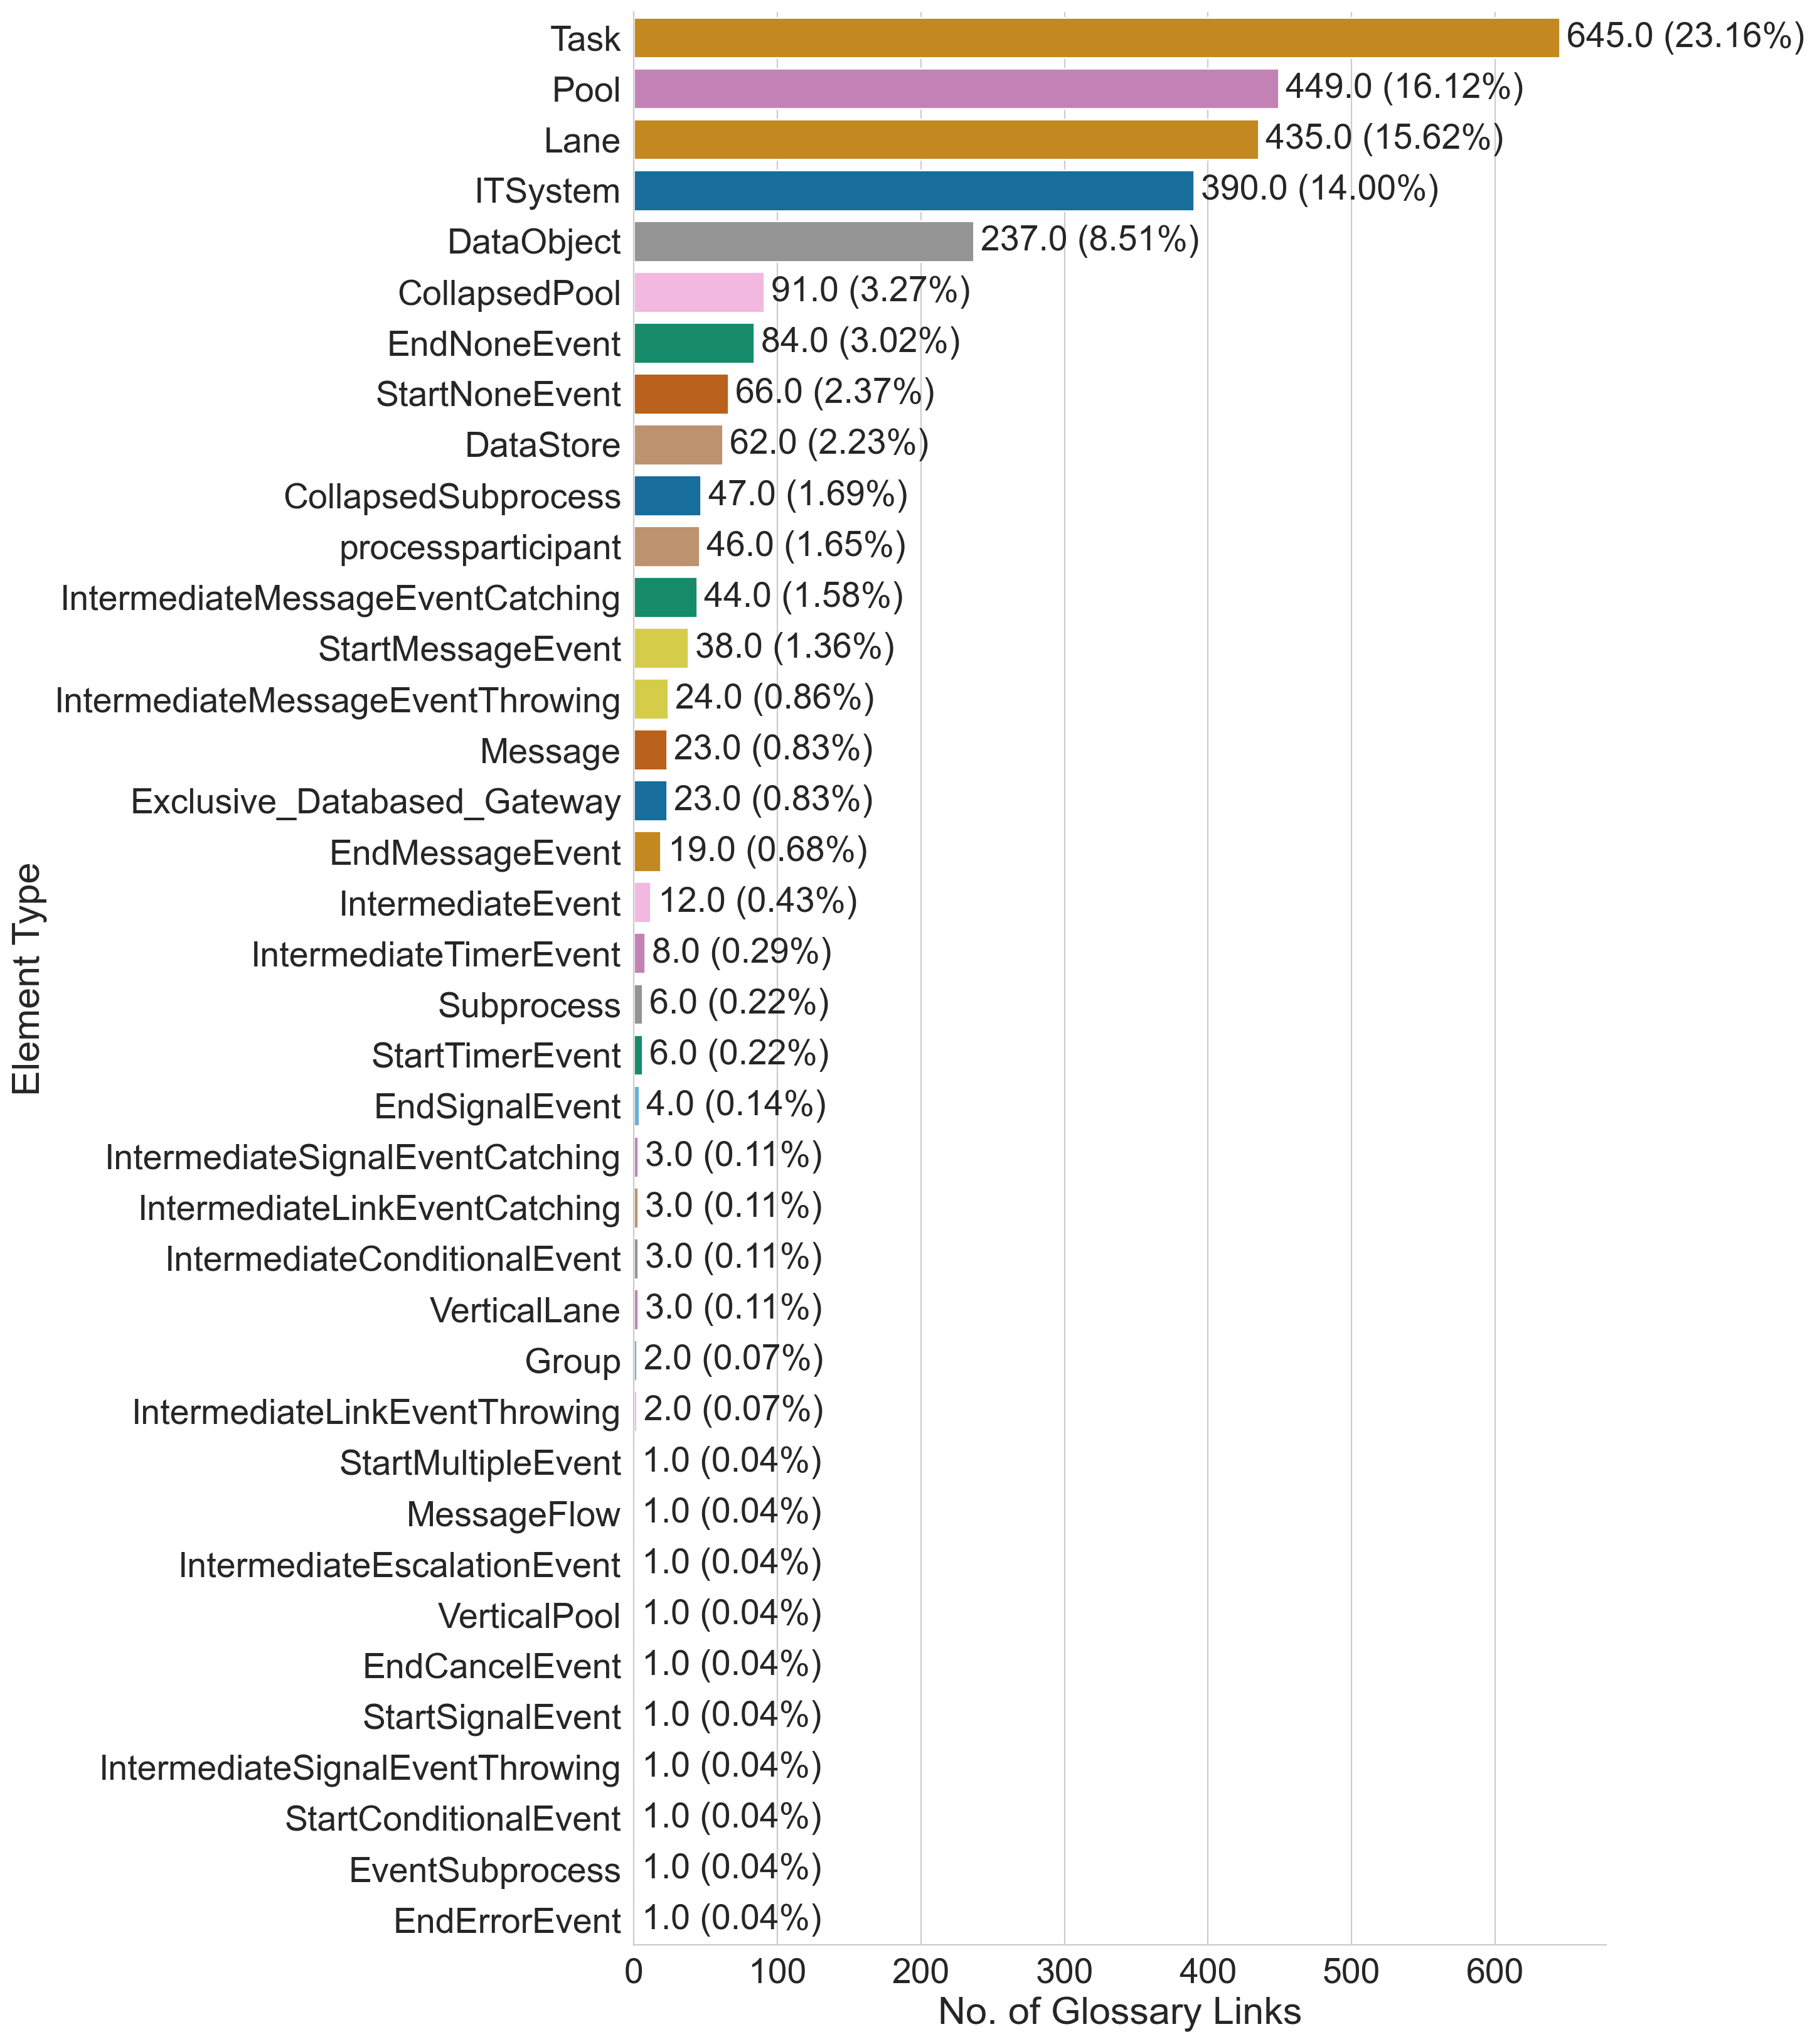

In [60]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
containers_nb = total_bos['category'].nunique()
total_bos.loc[:, 'category'] = total_bos['category'].astype('category').cat.remove_unused_categories()
#total_bos.loc[:, 'category'] = total_bos['category'].cat.remove_unused_categories()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown.
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.countplot(y="category", hue="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb),legend=False)
else:
    ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))
labels = []
for container in ax.containers:
    for val in container:
        labels.append(f'{val.get_width()} ({val.get_width()/total_bos_count*100.0:.2f}%)')
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particular category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [61]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [62]:
len(its_bos_count)

169

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [63]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

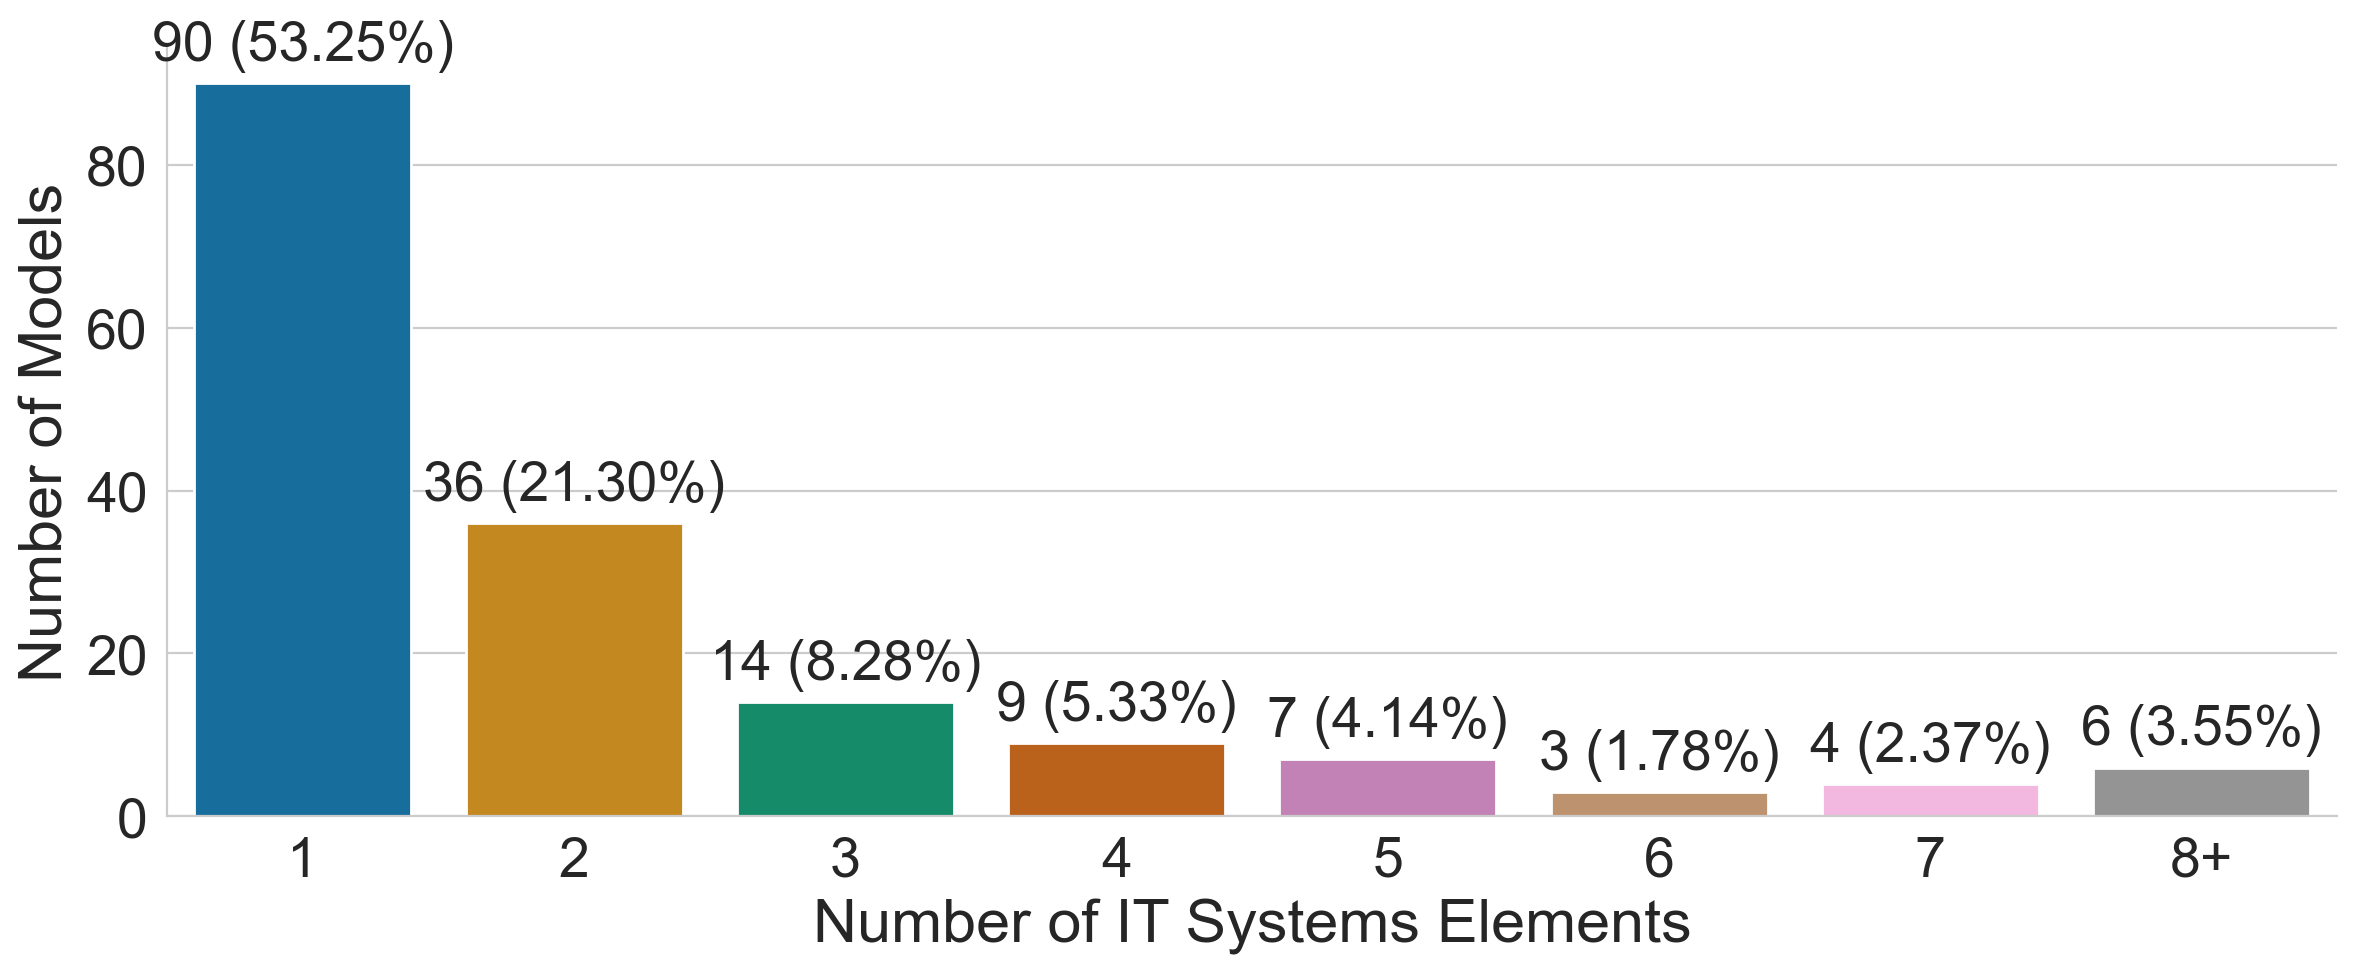

In [64]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos_count)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [65]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

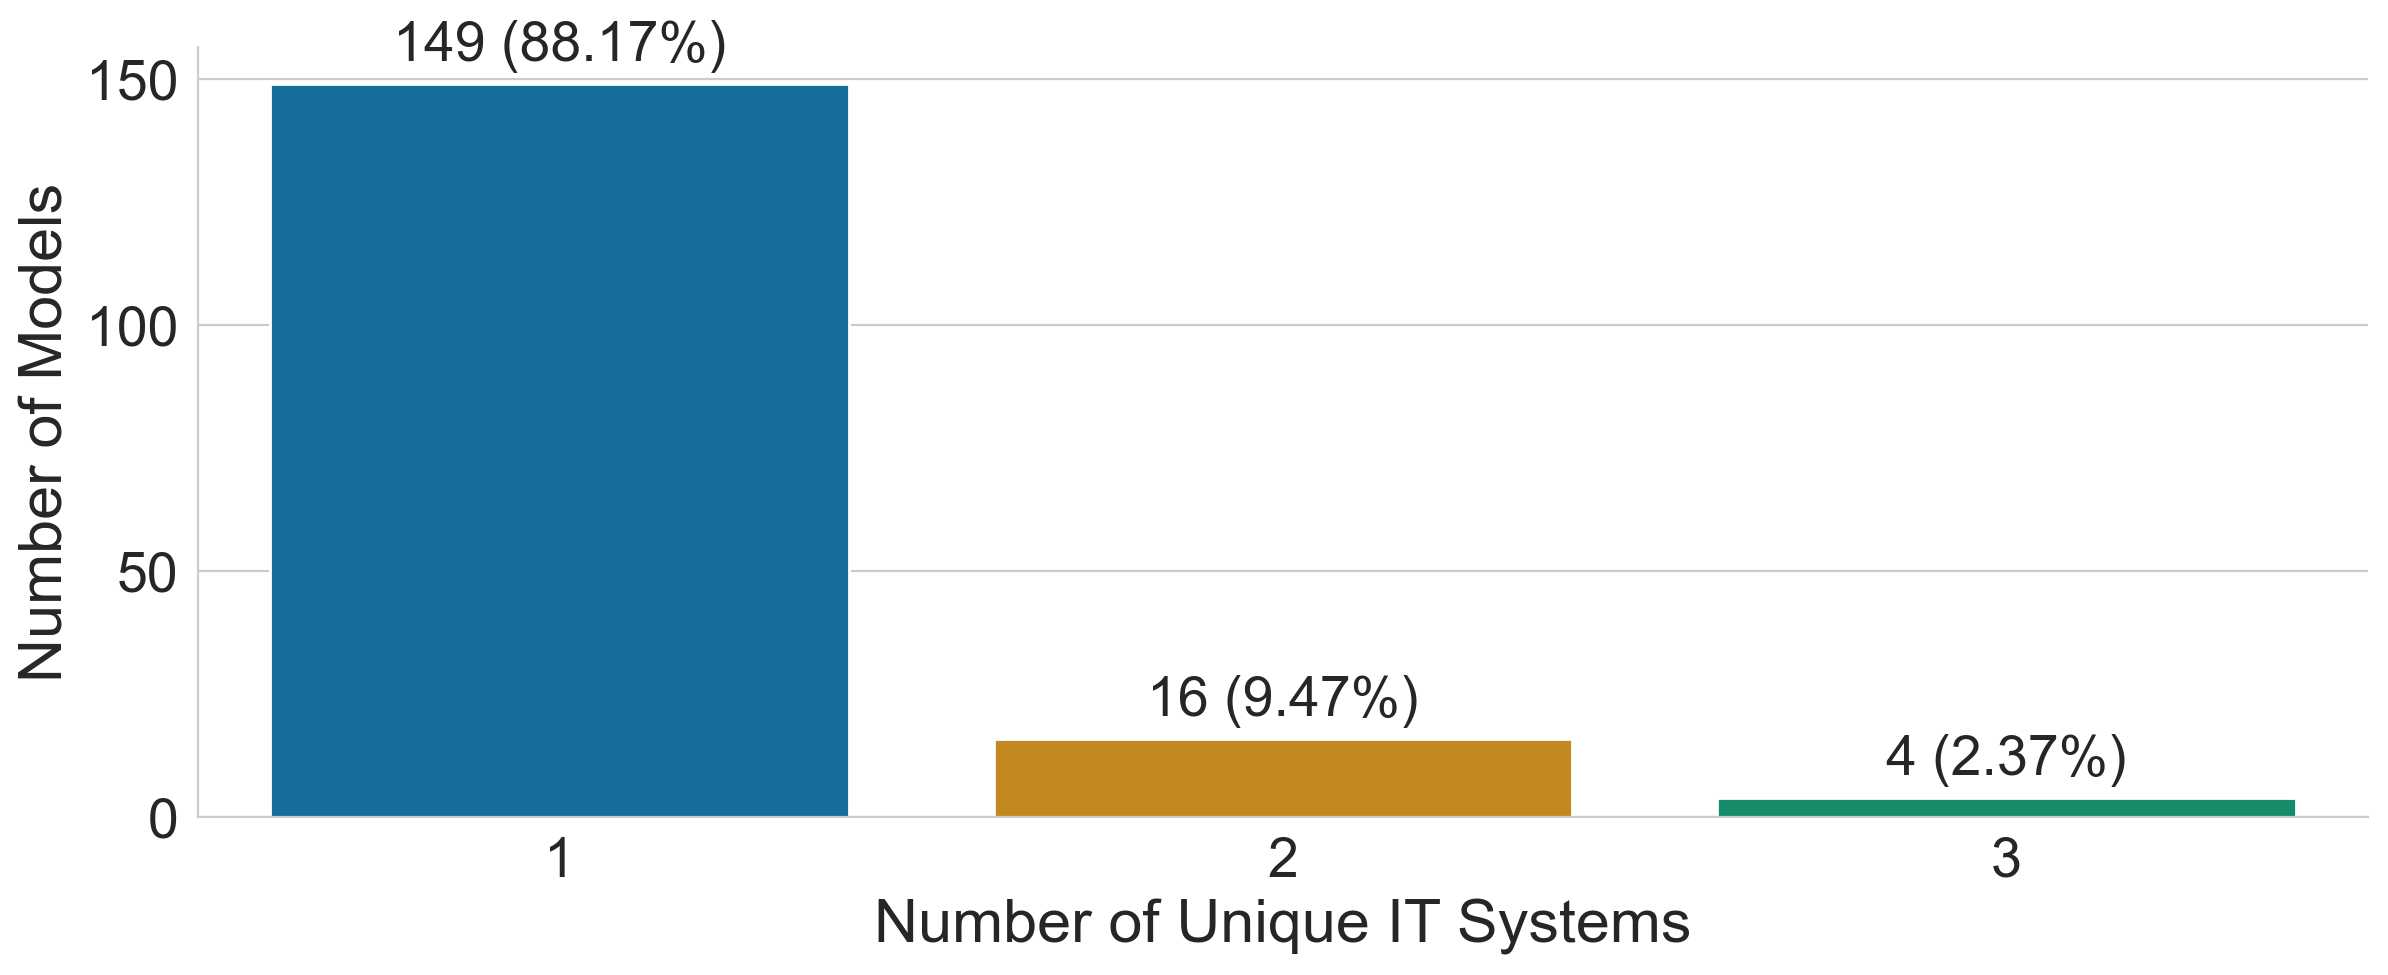

In [66]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As expected, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [67]:
cnt_elements.total_count.describe()

count       6913.0
mean     52.671922
std      50.264581
min            5.0
25%           24.0
50%           40.0
75%           64.0
max         1333.0
Name: total_count, dtype: Float64

These are the statistics of the number of elements per model by element type:

In [68]:
cnt_elements.describe().transpose().head()

count       mean        std  min  25%   50%   75%    max
SequenceFlow  6913.0  20.740634  19.238031  0.0  9.0  16.0  26.0  427.0
Pool          6913.0   1.198177   1.125418  0.0  1.0   1.0   2.0   26.0
Lane          6913.0    2.15507   1.987146  0.0  1.0   2.0   3.0   26.0
EndNoneEvent  6913.0   1.920006   1.887488  0.0  1.0   1.0   2.0   55.0
Task          6913.0   9.862288   9.621399  0.0  4.0   7.0  12.0  252.0

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [69]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [70]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats

/var/folders/kh/58f56r354rsbjqgq1305hfvm0000gn/T/ipykernel_31839/2650037200.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()


count       mean        std  min   25%   50%   75%    max
Activities          6913.0  10.404311   9.852419  1.0   5.0   8.0  13.0  259.0
Artifacts           6913.0   1.043107   4.068801  0.0   0.0   0.0   1.0  149.0
Connecting Objects  6913.0  25.926949  26.408001  0.0  11.0  19.0  32.0  709.0
Data Elements       6913.0   1.463475   3.901623  0.0   0.0   0.0   1.0   88.0
Events              6913.0   5.858238   6.588442  2.0   2.0   4.0   7.0  155.0
Gateways            6913.0   4.273687   4.869301  0.0   2.0   3.0   6.0   71.0
Swimlanes           6913.0   3.702155   3.162592  0.0   2.0   4.0   5.0   61.0

In [71]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%    max
Activities          10.4   9.9  1.0   5.0   8.0  13.0  259.0
Artifacts            1.0   4.1  0.0   0.0   0.0   1.0  149.0
Connecting Objects  25.9  26.4  0.0  11.0  19.0  32.0  709.0
Data Elements        1.5   3.9  0.0   0.0   0.0   1.0   88.0
Events               5.9   6.6  2.0   2.0   4.0   7.0  155.0
Gateways             4.3   4.9  0.0   2.0   3.0   6.0   71.0
Swimlanes            3.7   3.2  0.0   2.0   4.0   5.0   61.0

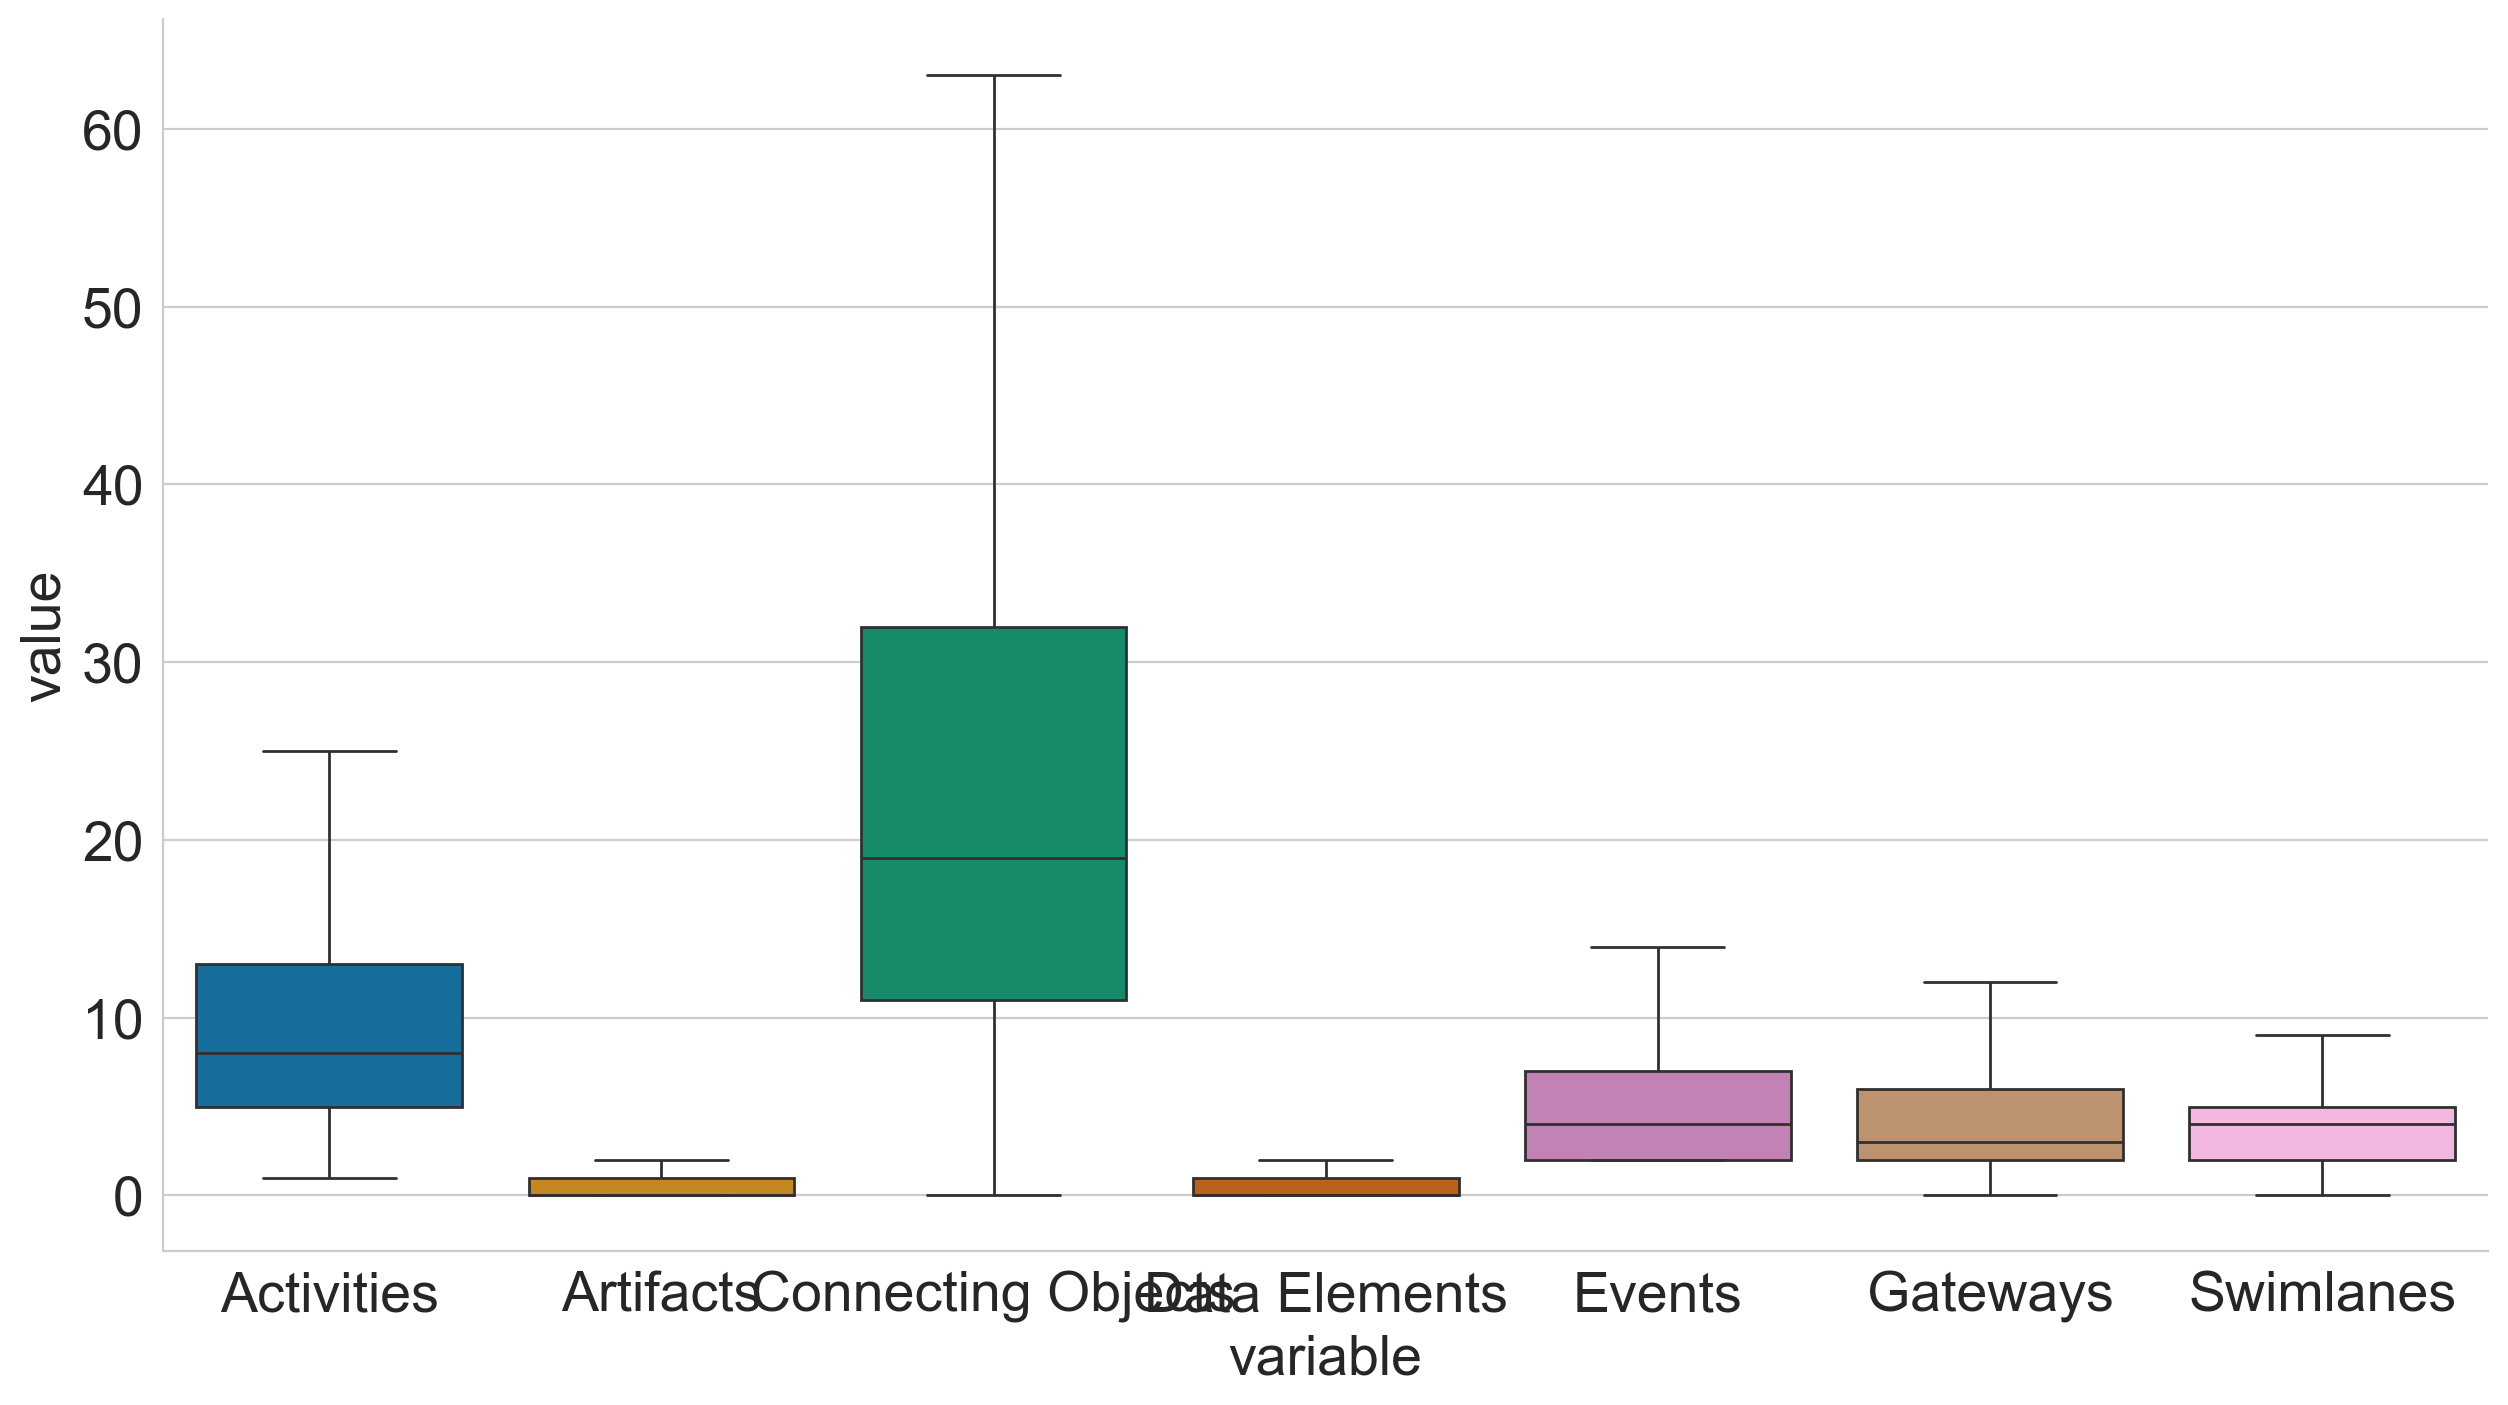

In [72]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", hue="variable", legend=False, data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind", n_colors=7))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [73]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

/var/folders/kh/58f56r354rsbjqgq1305hfvm0000gn/T/ipykernel_31839/1799829117.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()


count       mean        std  min   25%   50%   75%    max
No. of Edges  6913.0  25.926949  26.408001  0.0  11.0  19.0  32.0  709.0
No. of Nodes  6913.0  26.744973  24.080784  3.0  13.0  21.0  33.0  624.0

In [74]:
df_high_level.head()

No. of Edges  No. of Nodes
0            17            21
1            29            37
2             5             8
3             9             9
4            17            16

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

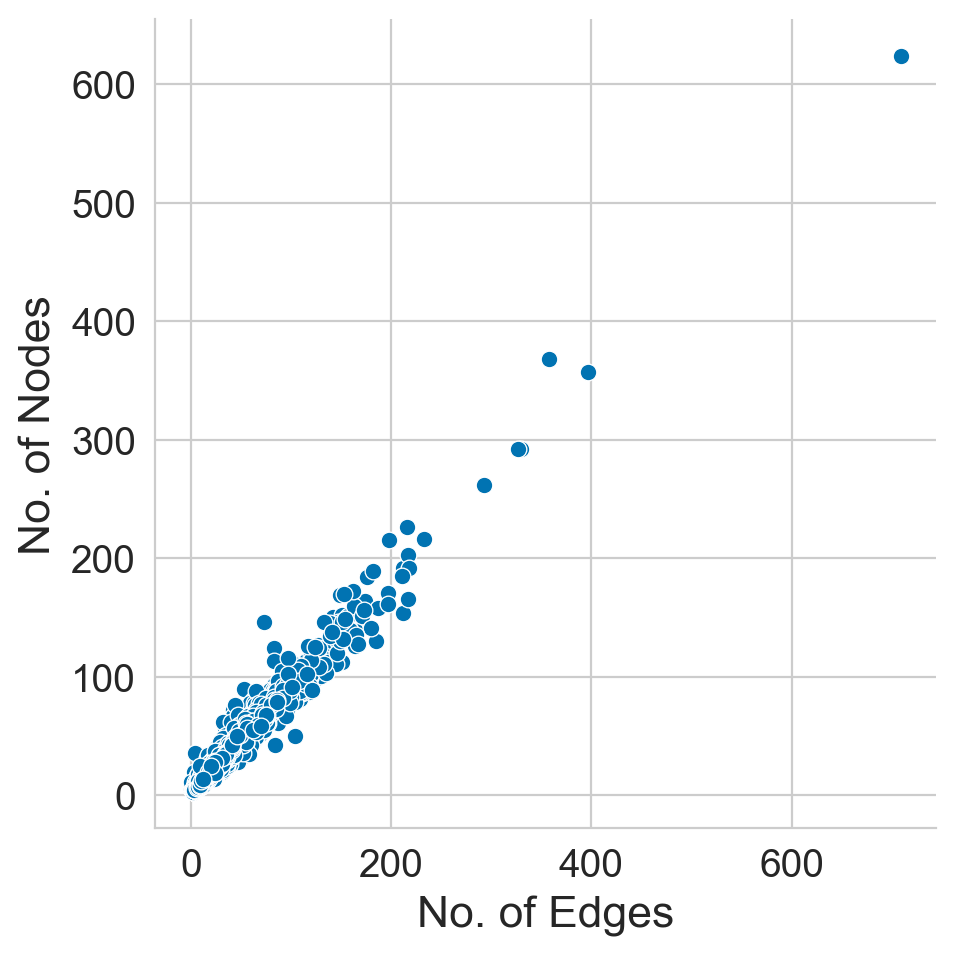

In [75]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
#plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [76]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kh/58f56r354rsbjqgq1305hfvm0000gn/T/ipykernel_31839/2178938135.py:9: SyntaxWarning: invalid escape sequence '\s'
  label = re.sub("\s{1,}"," ",label)


In [77]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0                 12345678          449
1              New Process          277
2            Neuer Prozess          104
3            12345678_rev1           45
4            12345678_rev2           30
5                 Jane Doe           26
6            12345678_rev3           25
7          New Value Chain           18
8  3.zadatak (Copy) (Copy)           16
9                     test           16

The number of distinct process names:

In [78]:
len(cnts_names)

8888

We use Signavio's color palette for the word cloud.

In [79]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

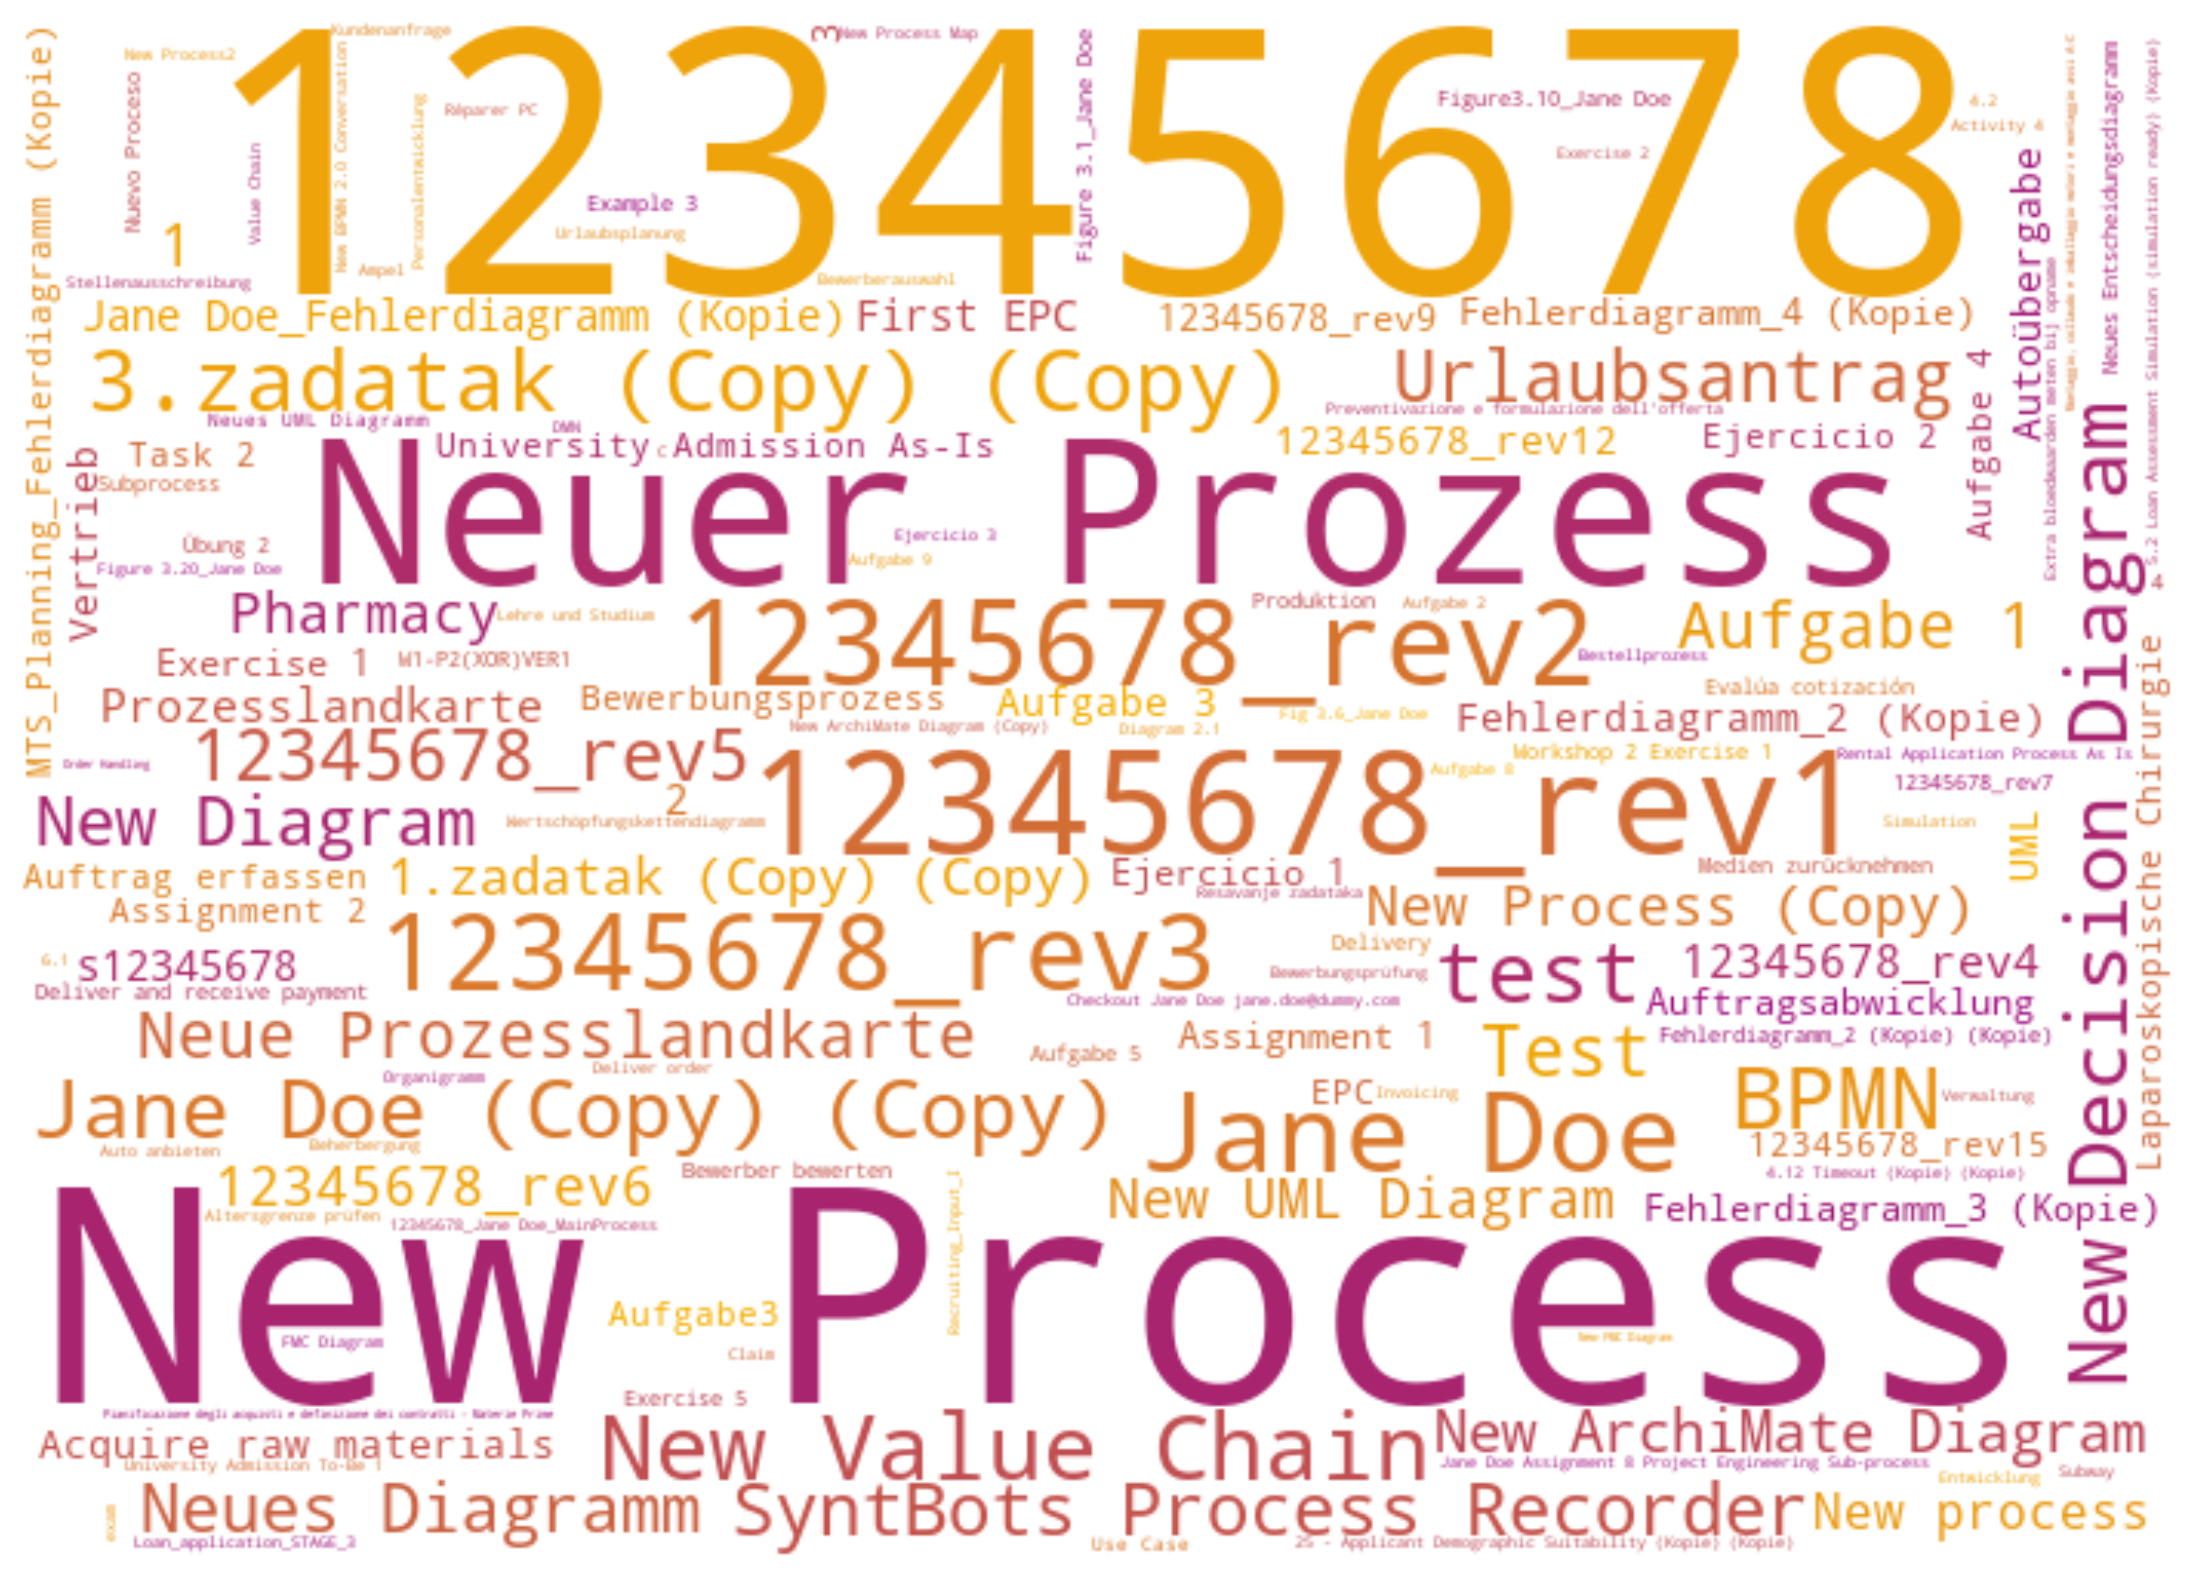

In [80]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [81]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No         2088
1       Yes         1698
2        Ja          911
3      Nein          866
4        ja          812
5        no          804
6      nein          792
7       yes          682
8  Customer          450
9        NO          385

The number of distinct element labels:

In [82]:
len(cnts_labels)

112225

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [83]:
len(df_bpmn)

364121

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [84]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.38076306020399797

... while 64.9 % of the labels are used for only one element.

In [85]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.8576431276453553

In [86]:
len(cnts_labels[cnts_labels.occurrences==1])

96249

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [87]:
bins = cnts_labels
bins.head()

label  occurrences
0    No         2088
1   Yes         1698
2    Ja          911
3  Nein          866
4    ja          812

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [88]:
N = 10000
bins = bins.groupby(bins.index // N).sum(numeric_only=True)

In [89]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0        62585           10000
1        15976           20000
2        10000           30000
3        10000           40000
4        10000           50000

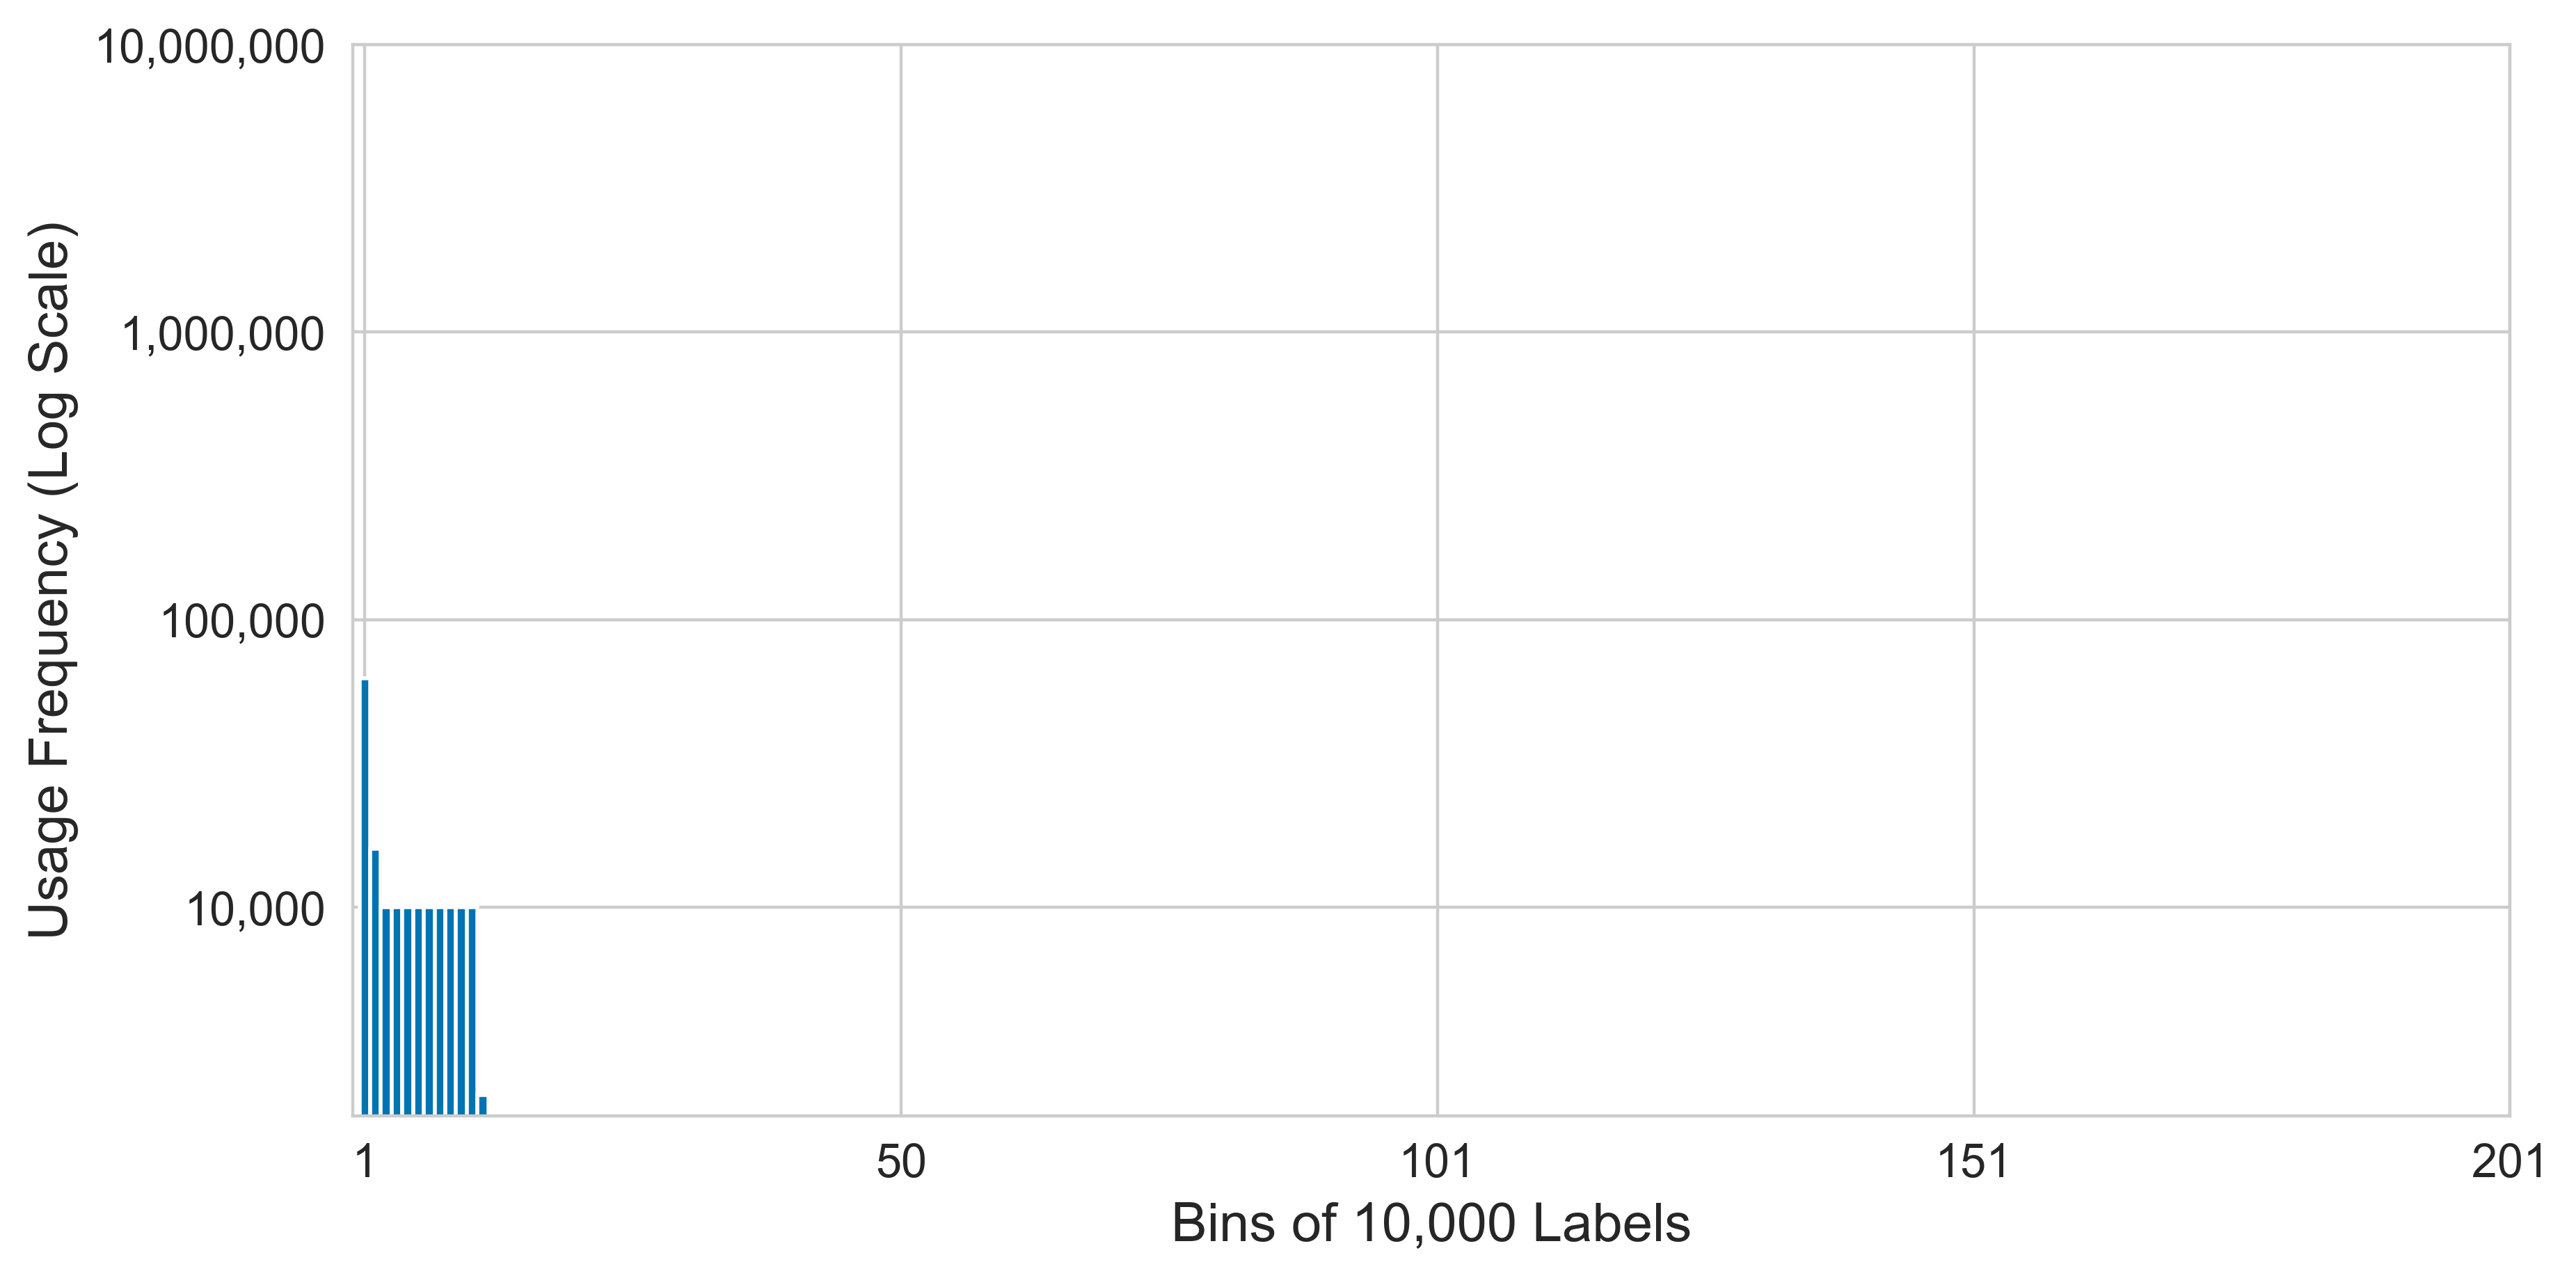

In [90]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

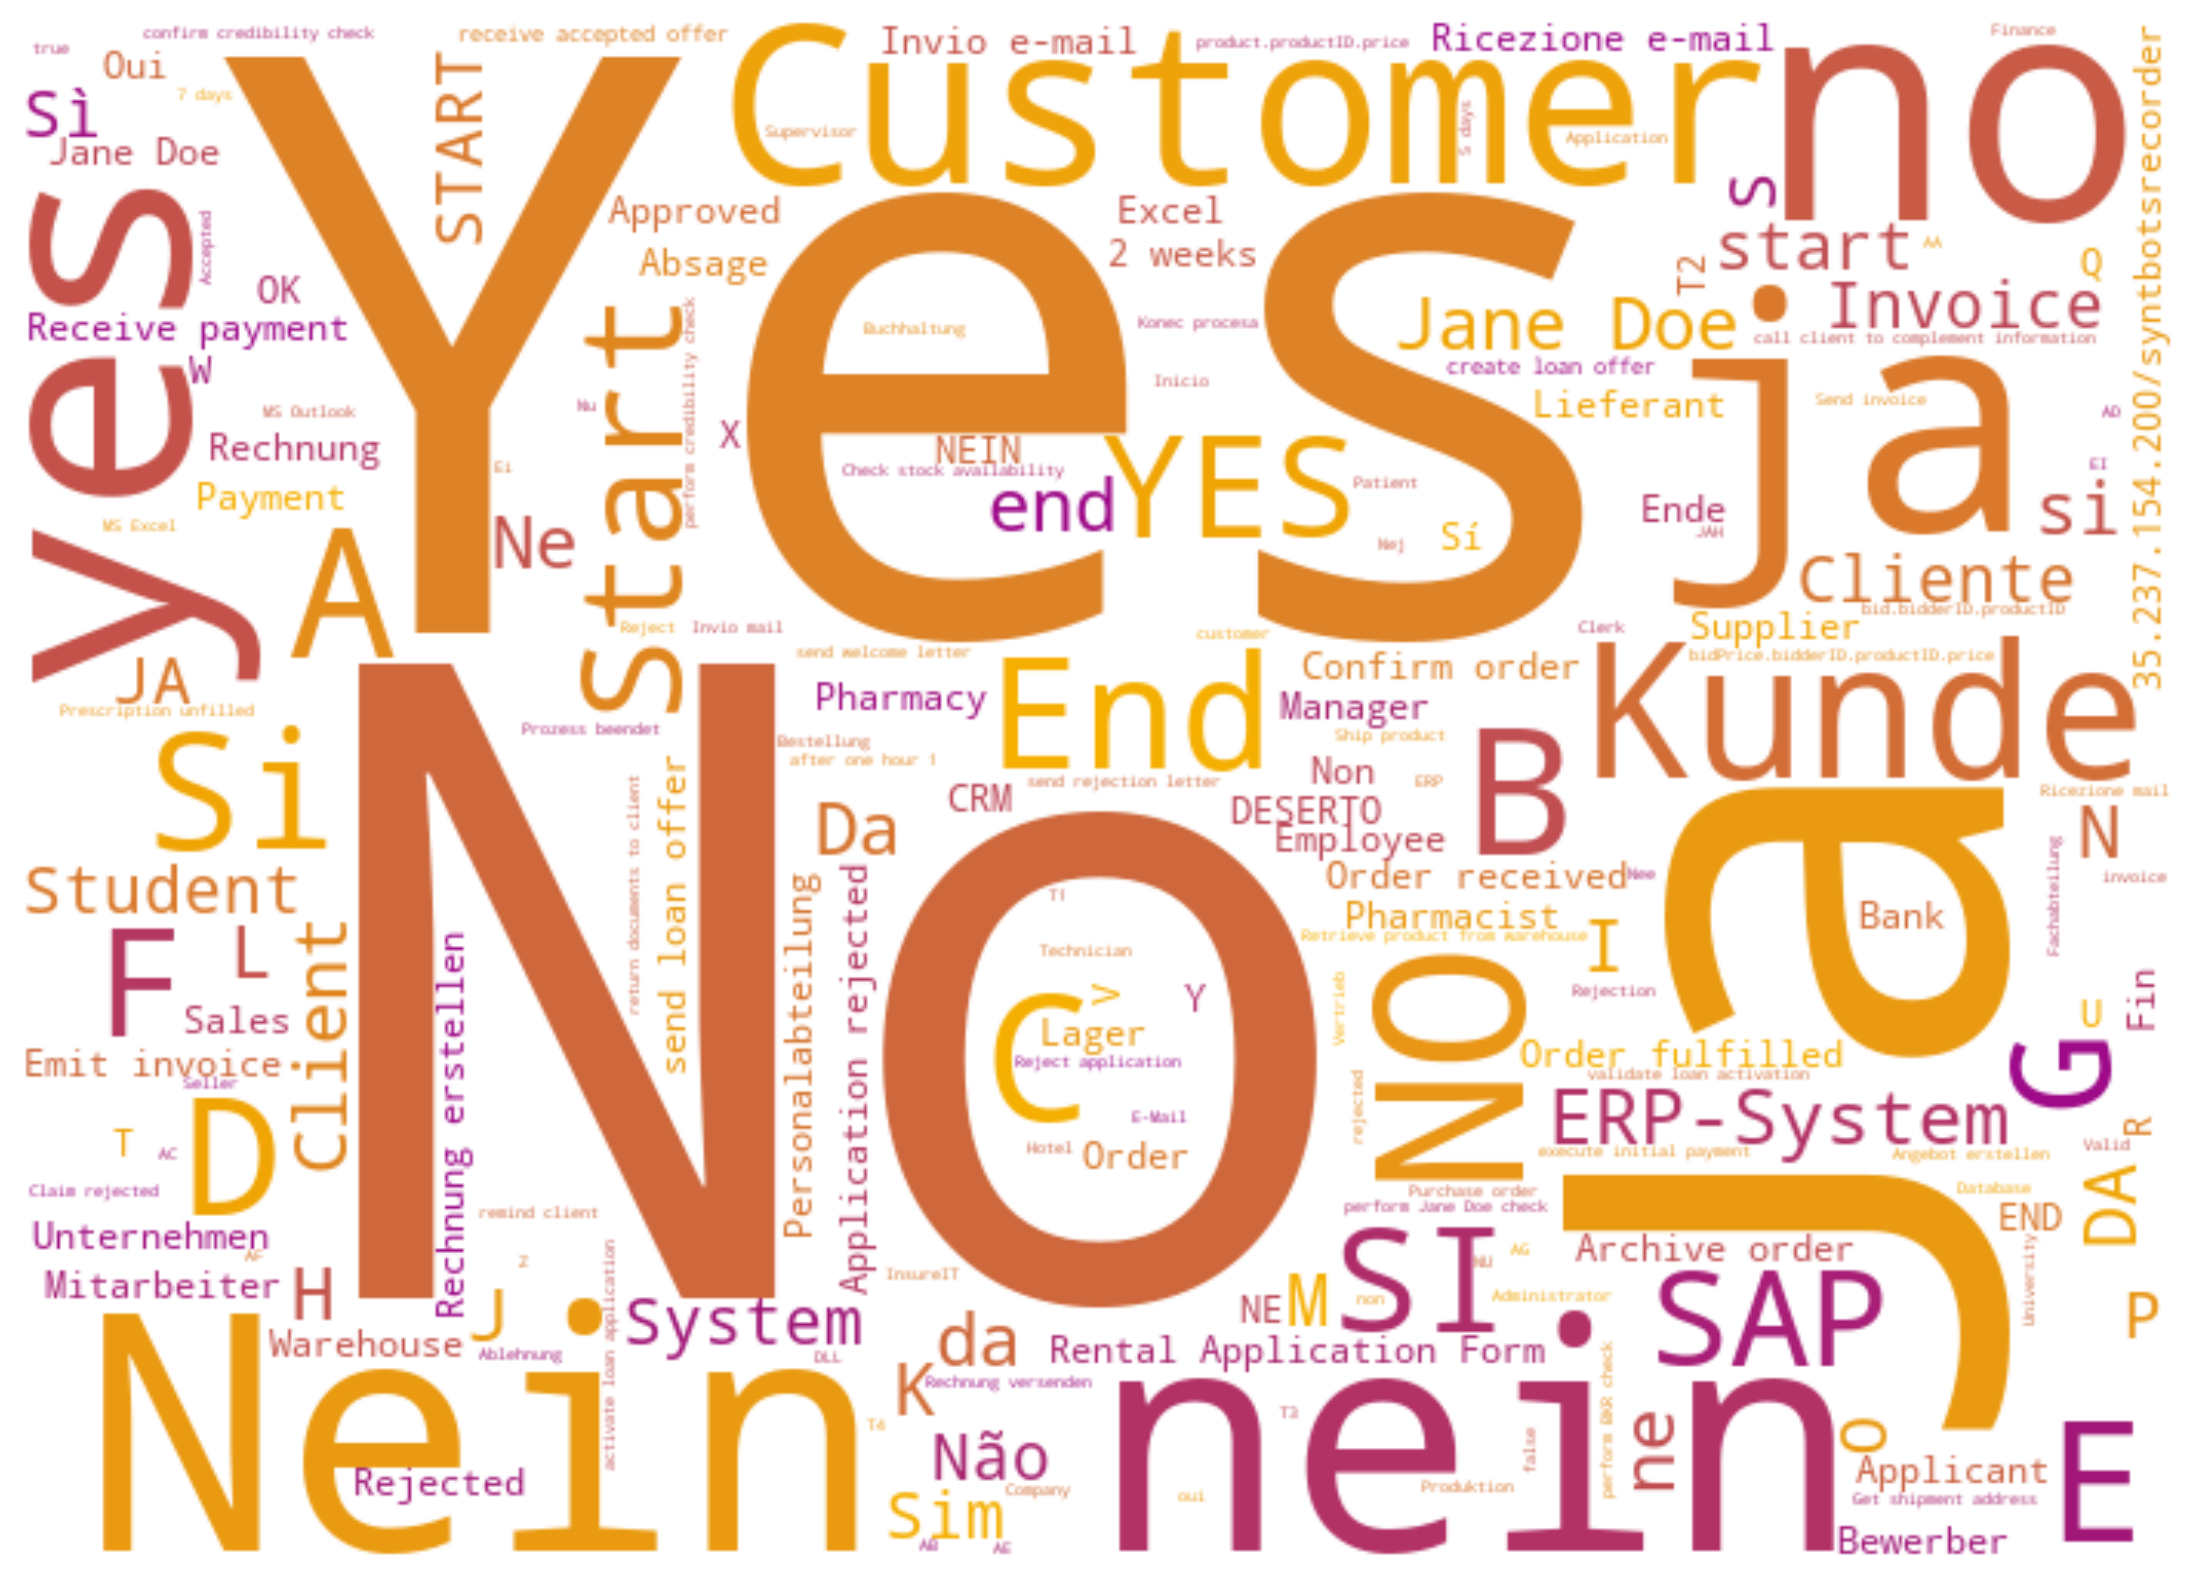

In [91]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Measures

In the following, we are going to implement measures to compare different process models.

In [92]:
df_bpmn.head()

category  \
model_id                         element_id                                               
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539  SequenceFlow   
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516  SequenceFlow   
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1  SequenceFlow   
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF  SequenceFlow   
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F  SequenceFlow   

                                                                          label  \
model_id                         element_id                                       
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539         
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516         
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1         
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF         
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539             None   
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516             None   
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1             None   
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF             None   
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F             None   

                                                                                               name  
model_id                         element_id                                                          
1ba7587b3191422fb03a0e9ba92cebff sid-EDA1A86B-8744-4781-BF46-C2E0384B2539  710 BPMN Conference room  
                                 sid-3C90700D-BFE3-4881-AFAE-2D4B8B74B516  710 BPMN Conference room  
                                 sid-E135F636-8A3C-4C7B-8611-53DD6006E7B1  710 BPMN Conference room  
                                 sid-D8501DB4-4B74-42B6-A91B-1E8F3862FACF  710 BPMN Conference room  
                                 sid-3307C675-7667-4979-8E6B-D27B0387243F  710 BPMN Conference room

In [93]:
cnt_elements.head()

SequenceFlow  Pool  Lane  EndNoneEvent  Task  StartNoneEvent  \
0            17     1     3             2    12               1   
1            25     2     5             4    12               1   
2             5     1     1             1     0               1   
3             9     0     0             1     5               1   
4            17     0     0             1     9               1   

   Exclusive_Databased_Gateway  total_count  Association_Undirected  \
0                            2           38                       0   
1                            0           66                       2   
2                            0           13                       0   
3                            2           18                       0   
4                            3           33                       0   

   Association_Unidirectional  MessageFlow  IntermediateMessageEventCatching  \
0                           0            0                                 0   
1                           1            1                                 1   
2                           0            0                                 0   
3                           0            0                                 0   
4                           0            0                                 0   

   IntermediateMessageEventThrowing  ITSystem  ParallelGateway  \
0                                 0         0                0   
1                                 2         2                3   
2                                 0         0                0   
3                                 0         0                0   
4                                 0         0                0   

   StartConditionalEvent  DataObject  IntermediateConditionalEvent  \
0                      0           0                             0   
1                      3           1                             1   
2                      0           0                             0   
3                      0           0                             0   
4                      0           0                             0   

   CollapsedSubprocess  EndTerminateEvent  IntermediateTimerEvent  \
0                    0                  0                       0   
1                    0                  0                       0   
2                    4                  0                       0   
3                    0                  0                       0   
4                    0                  1                       1   

   EventbasedGateway  CollapsedPool  StartMessageEvent  TextAnnotation  \
0                  0              0                  0               0   
1                  0              0                  0               0   
2                  0              0                  0               0   
3                  0              0                  0               0   
4                  0              0                  0               0   

   Subprocess  IntermediateEvent  InclusiveGateway  DataStore  \
0           0                  0                 0          0   
1           0                  0                 0          0   
2           0                  0                 0          0   
3           0                  0                 0          0   
4           0                  0                 0          0   

   EndMessageEvent  EventSubprocess  StartTimerEvent  IntermediateErrorEvent  \
0                0                0                0                       0   
1                0                0                0                       0   
2                0                0                0                       0   
3                0                0                0                       0   
4                0                0                0                       0   

   IntermediateLinkEventCatching  IntermediateLinkEventThrowing  Message  \
0                              0                              0   

In [94]:
print(cnt_elements.columns)

Index(['SequenceFlow', 'Pool', 'Lane', 'EndNoneEvent', 'Task',
       'StartNoneEvent', 'Exclusive_Databased_Gateway', 'total_count',
       'Association_Undirected', 'Association_Unidirectional', 'MessageFlow',
       'IntermediateMessageEventCatching', 'IntermediateMessageEventThrowing',
       'ITSystem', 'ParallelGateway', 'StartConditionalEvent', 'DataObject',
       'IntermediateConditionalEvent', 'CollapsedSubprocess',
       'EndTerminateEvent', 'IntermediateTimerEvent', 'EventbasedGateway',
       'CollapsedPool', 'StartMessageEvent', 'TextAnnotation', 'Subprocess',
       'IntermediateEvent', 'InclusiveGateway', 'DataStore', 'EndMessageEvent',
       'EventSubprocess', 'StartTimerEvent', 'IntermediateErrorEvent',
       'IntermediateLinkEventCatching', 'IntermediateLinkEventThrowing',
       'Message', 'Group', 'processparticipant', 'IntermediateEscalationEvent',
       'EndEscalationEvent', 'EndErrorEvent', 'Association_Bidirectional',
       'IntermediateMultipleEventCatchi

In [95]:
# Use df_low_level for CFC, NOAJS, NOA, CNC(G), D(G)

# Control-Flow Complexity (CFC)
# Description: CFC counts the occurrences of different types of splits (AND, XOR, OR) in the model.
def CFC(df_low_level):
    df_low_level["CFC"] = df_low_level["Gateways"]
    return df_low_level

# Number of Activities, Joins and Splits (NOAJS)
# Description: Splits in BPMN do not necessarily have corresponding joins. 
#              NOAJS complexity metric can measure such not well structured processes based on counting activities, joins and splits together.
def NOAJS(df_low_level):
    df_low_level["NOAJS"] = df_low_level["Activities"] + df_low_level["Gateways"]
    return df_low_level

# Number of Activities (NOA)
# Description: NOA metric sums up activities in a business process model. 
#              It is a simple and popular metric that can be used to measure complexity.
def NOA(df_low_level):
    df_low_level["NOA"] = df_low_level["Activities"]
    return df_low_level

In [96]:
df_low_level2 = df_low_level.copy()
df_low_level2 = CFC(df_low_level2)
df_low_level2 = NOAJS(df_low_level2)
df_low_level2 = NOA(df_low_level2)

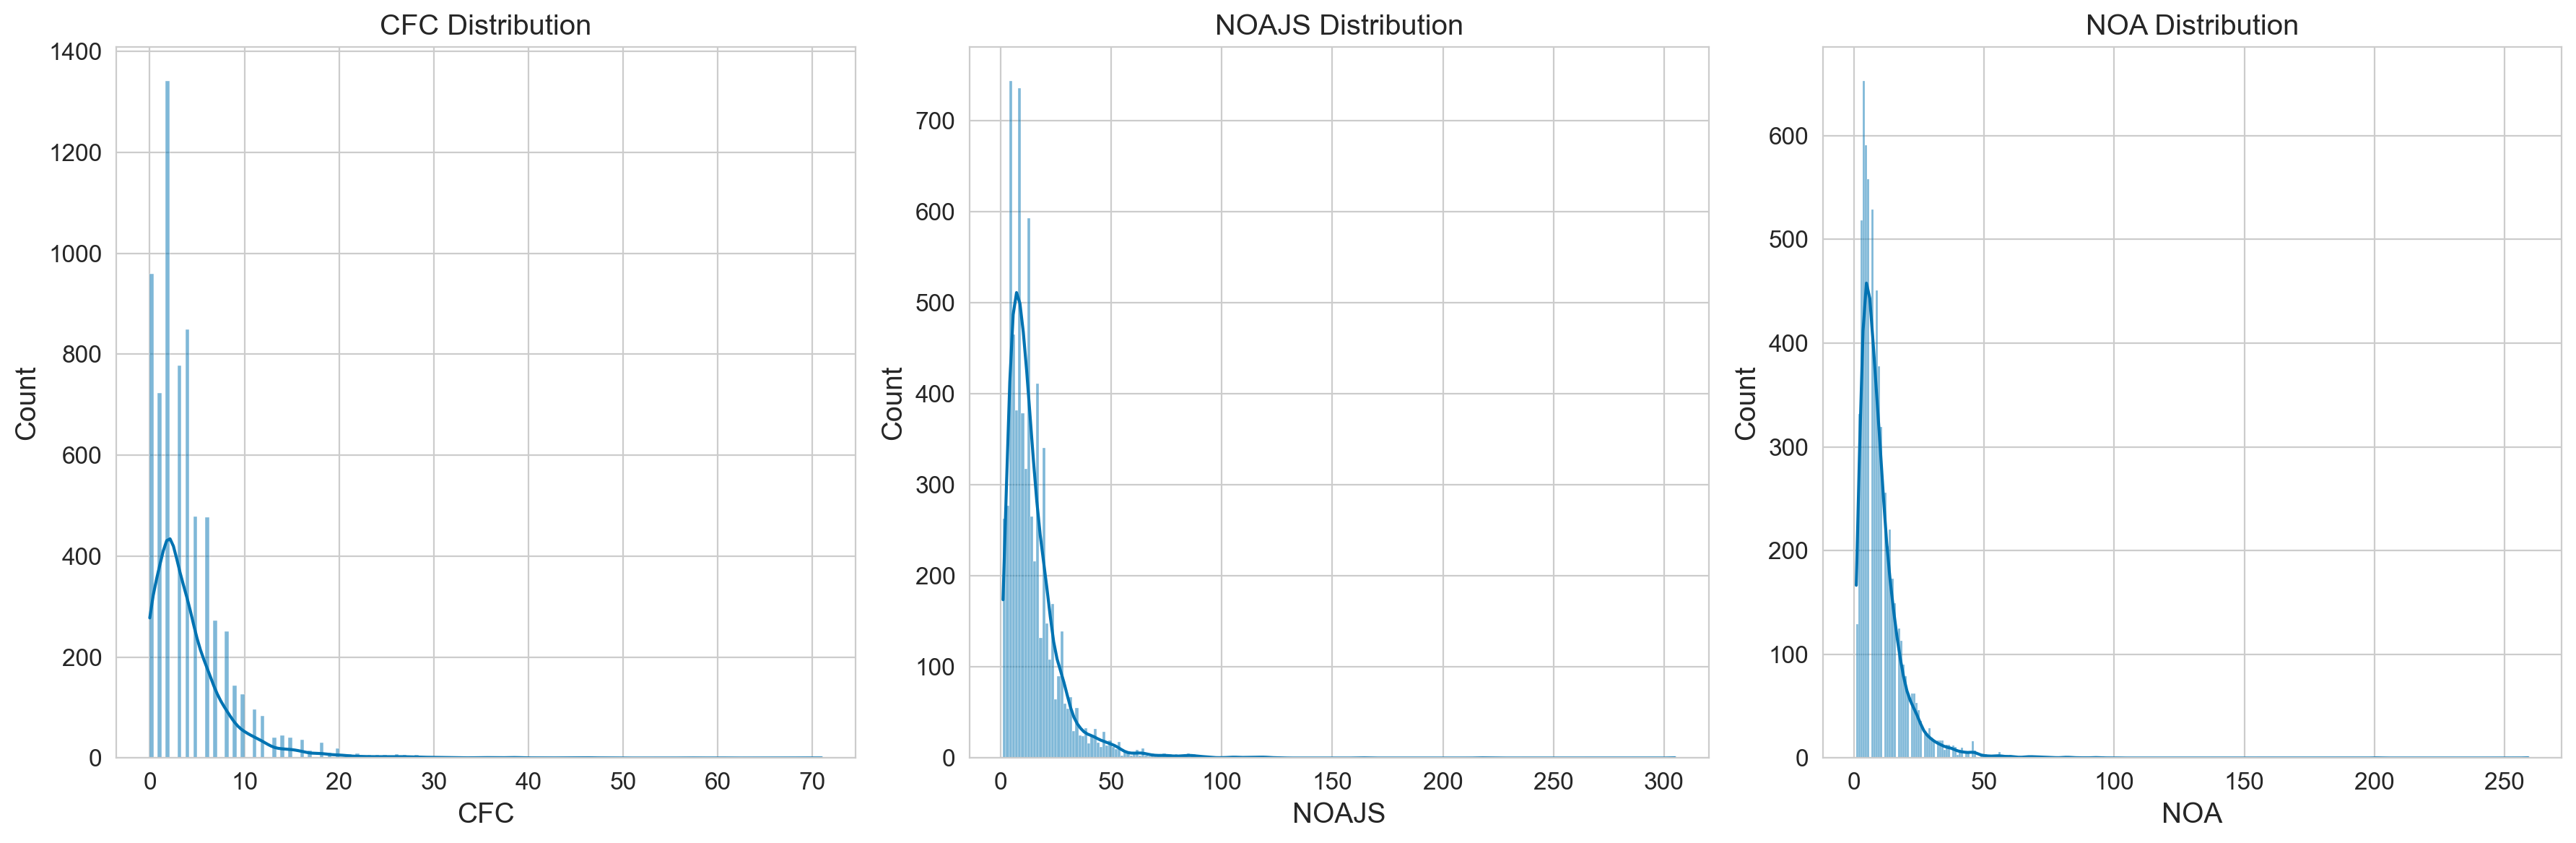

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot for CFC
sns.histplot(df_low_level2["CFC"], ax=axes[0], kde=True)
axes[0].set_title("CFC Distribution")

# Plot for NOAJS
sns.histplot(df_low_level2["NOAJS"], ax=axes[1], kde=True)
axes[1].set_title("NOAJS Distribution")

# Plot for NOA
sns.histplot(df_low_level2["NOA"], ax=axes[2], kde=True)
axes[2].set_title("NOA Distribution")

plt.tight_layout()
plt.show()

In [98]:
# Use df_high_level for CNC and Density

# Coefficient of Connectivity (CNC(G))
# Description: CNC(G) is a structural metric; the coefficient of connectivity gives the ratio of arcs to nodes in BPMN models. 
def CNC(df_high_level):
    df_high_level["CNC"] = df_high_level["No. of Edges"] / df_high_level["No. of Nodes"]
    return df_high_level

# Number of Nodes metric (Sn(G))
# Description: Sn(G) is a structural metric that calculate the number of nodes of process model. 
def Node_Count(df_high_level):
    df_high_level["Node_Count"] = df_high_level["No. of Nodes"]
    return df_high_level

# Density
# Description: Density is a structural metric that calculates the ratio of the total number of arcs to the maximum number of arcs. 
def Density(df_high_level):
    df_high_level["Density"] = df_high_level["No. of Edges"] / (df_high_level["No. of Nodes"] * (df_high_level["No. of Nodes"] - 1))
    return df_high_level

In [99]:
df_high_level2 = df_high_level.copy()
df_high_level2 = CNC(df_high_level2)
df_high_level2 = Node_Count(df_high_level2)
df_high_level2 = Density(df_high_level2)

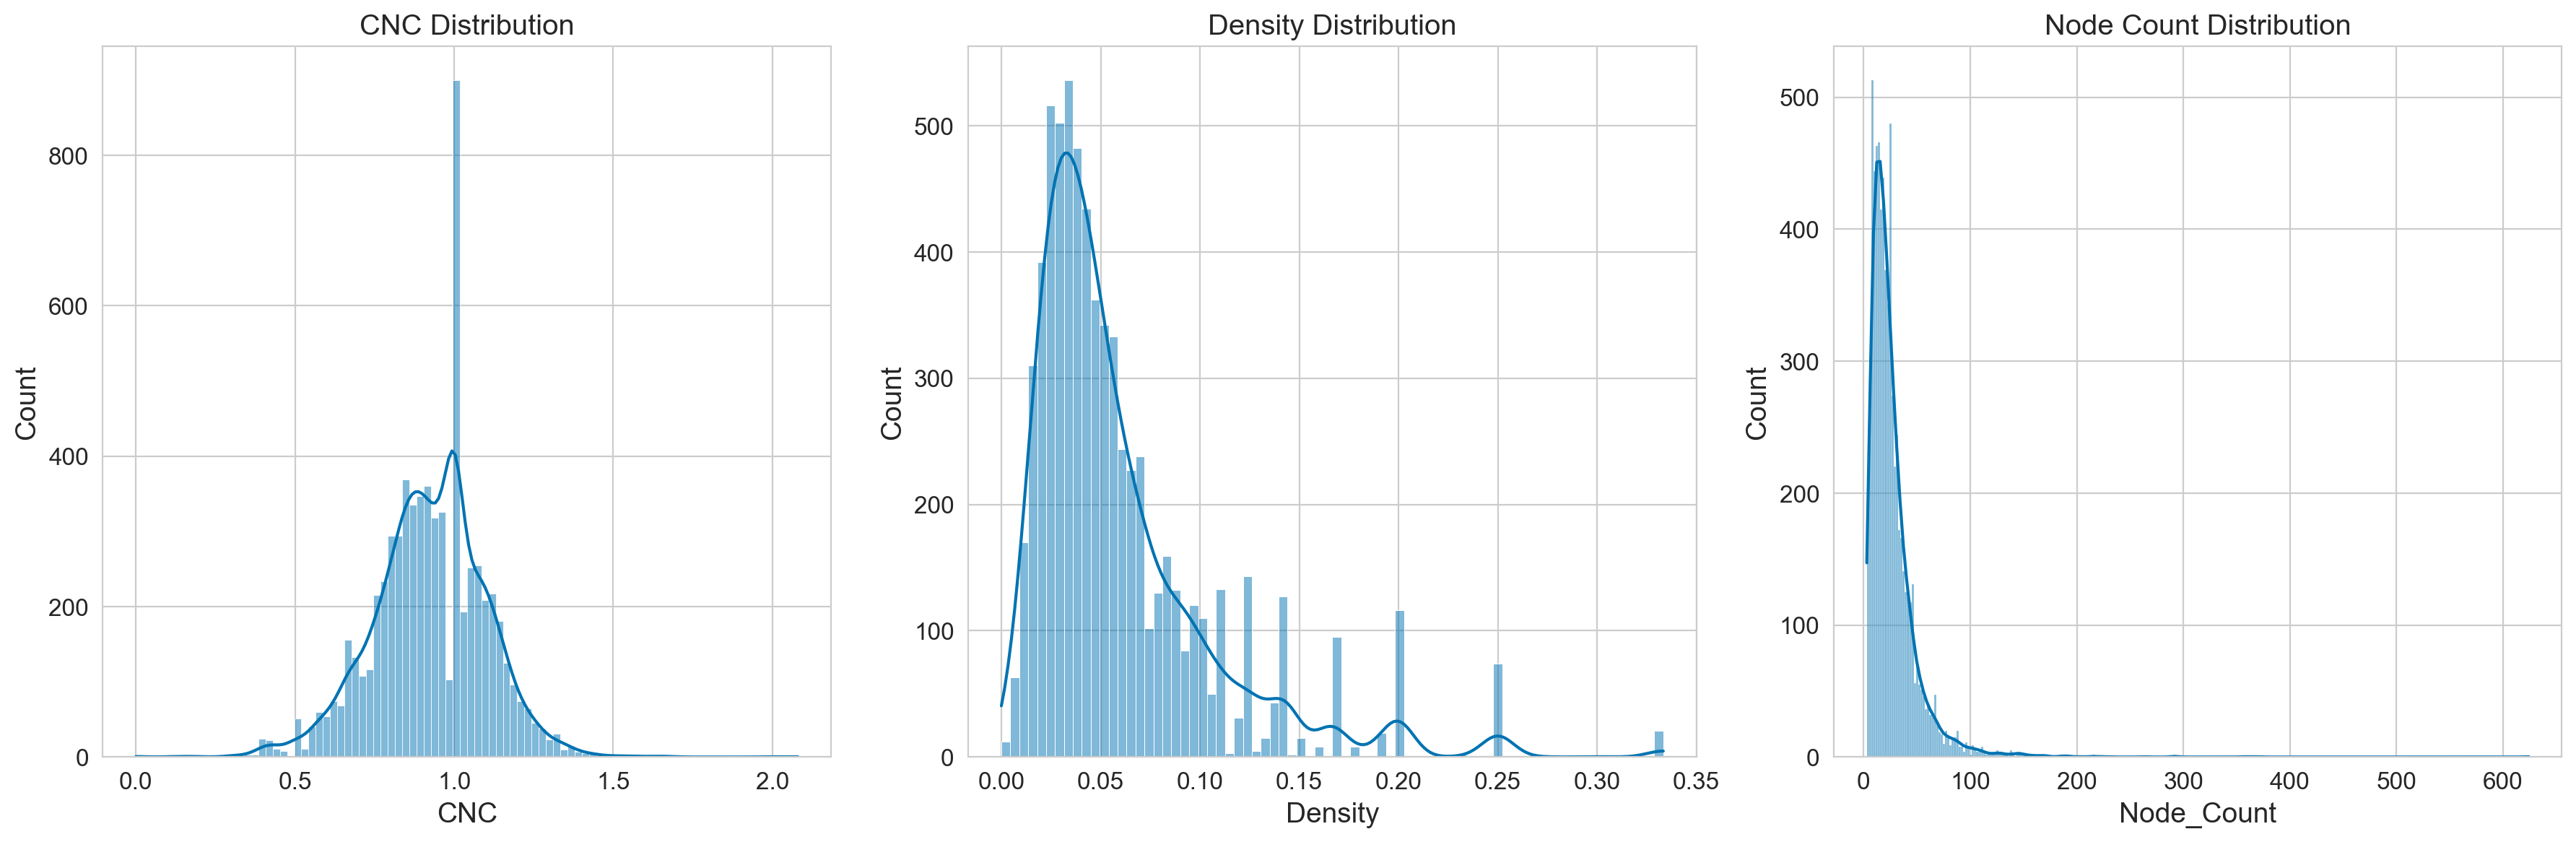

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot for CNC
sns.histplot(df_high_level2["CNC"], ax=axes[0], kde=True)
axes[0].set_title("CNC Distribution")

# Plot for Density
sns.histplot(df_high_level2["Density"], ax=axes[1], kde=True)
axes[1].set_title("Density Distribution")

# Plot for Density
sns.histplot(df_high_level2["Node_Count"], ax=axes[2], kde=True)
axes[2].set_title("Node Count Distribution")

plt.tight_layout()
plt.show()

For the next measures, we need the information about ingoing and outgoing archs. Therefore, we need some more information from the model JSON file. To do this, we parse the models to access the information from the Model JSON.

In [101]:
csv_paths = parser.get_csv_paths()

In [102]:
csv_path = csv_paths[0]
print(csv_path.name)
df_raw = pd.read_csv(csv_path, nrows=5)
df_raw

0.csv


Revision ID                          Model ID  \
0  5ed1535c95a342f4a414dd8c9b1b7df8  1ba74449e9354d0c9d4798b4a6e915d0   
1  301bfb5af53c431a830a6e435de6a590  1ba744cbcafb46c2a52482e36498a9bf   
2  ac3baa3e59ca476396b4affa8e900c6f  1ba7587b3191422fb03a0e9ba92cebff   
3  da11513a93224fbbb2c34ef9c5cfcaa9  1ba758f87e744ff0bcb3119887cac8cc   
4  70d06e82d8c344edab8b041f8b03161a  1ba77121c3be44d6bd0b354727f9707b   

                    Organization ID             Datetime  \
0  6c96d0b6e5e14eeaa9848f953a94e5f8  2019-03-19 11:36:50   
1  8af3fc1bb4b74e7c8c4089e4921d9056  2020-03-23 17:26:03   
2  36fbc1ee23334e1ab987b07d2108eef2  2017-04-19 06:19:36   
3  574093f96e5e4ff09a8b1f24eeb70284  2021-02-21 13:14:32   
4  ff66cd6b779c44bba88ade8952d7e626  2020-06-30 07:12:48   

                                          Model JSON  Description  \
0  {"resourceId": "canvas", "properties": {"name"...          NaN   
1  {"resourceId": "canvas", "formats": {"document...          NaN   
2  {"resourceId": "canvas", "properties": {"name"...          NaN   
3  {"resourceId": "canvas", "properties": {"name"...          NaN   
4  {"resourceId": "canvas", "properties": {"name"...          NaN   

                                     Name  Type  \
0                                    Pivo   NaN   
1                  Receipt of Application   NaN   
2                710 BPMN Conference room   NaN   
3                       ECU application p   NaN   
4  2.9.1 Elektronischer Auftrag erfassen    NaN   

                             Namespace  
0  http://b3mn.org/stencilset/bpmn2.0#  
1  http://b3mn.org/stencilset/bpmn2.0#  
2  http://b3mn.org/stencilset/bpmn2.0#  
3  http://b3mn.org/stencilset/bpmn2.0#  
4  http://b3mn.org/stencilset/bpmn2.0#

In [103]:
rel_parser = parser.BpmnModelParser(parse_outgoing=True, parse_parent=True)
df_rel = rel_parser.parse_model_elements(csv_paths=csv_paths[:1])
#df_rel

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.19s/it]


In [104]:
df_rel.head()

category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                                                             parent  \
model_id                         element_id                                                                           
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                                    canvas   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE                                    canvas   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  sid-00A06776-842A-40B5-9F67-A7A2B247CBAE   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  sid-3E27602D-0560-44E1-8089-4FC264FA9803   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                                    canvas   

                                                                                                             outgoing  \
model_id                         element_id                                                                             
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  [sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246]   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE                                          []   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                                          []   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246                                          []   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  [sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB]   

                                                                           name  
model_id                         element_id                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo  
                                 sid-3E27602D-05

__Exported Coupling of a Process metric (ECP)__

_Description: ECP is a coupling metric that focuses on process and its influence on the whole model based on how many other processes dependent on ist services._

In [105]:
# First, we are only looking at gateways
df_gate = df_rel.copy()

# Create new dataframe which only keeps gateways as elements
df_gate = df_gate[df_gate['category'].str.contains('Gateway')]

# Count outgoing elements
def count_outgoing(outgoing):
    return len(outgoing)

# Create a new column which counts the number of outgoing elements
df_gate['outgoing_count'] = df_gate['outgoing'].apply(count_outgoing)

df_gate.head()

category  \
model_id                         element_id                                                              
1ba74449e9354d0c9d4798b4a6e915d0 sid-7368D90A-0DB6-48F4-830A-05329E4551E6            EventbasedGateway   
1ba744cbcafb46c2a52482e36498a9bf sid-05963777-48BF-4F75-B546-CBFFCEA3AE4D  Exclusive_Databased_Gateway   
                                 sid-54CBDA4C-E653-442B-832B-2D287F5C3251  Exclusive_Databased_Gateway   
                                 sid-886F6575-2D4A-4569-9392-DFD22204FF67  Exclusive_Databased_Gateway   
1ba7587b3191422fb03a0e9ba92cebff sid-DE35115C-3D8D-44FF-B3F5-229D2718A348  Exclusive_Databased_Gateway   

                                                                                         label  \
model_id                         element_id                                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7368D90A-0DB6-48F4-830A-05329E4551E6                        
1ba744cbcafb46c2a52482e36498a9bf sid-05963777-48BF-4F75-B546-CBFFCEA3AE4D                 None   
                                 sid-54CBDA4C-E653-442B-832B-2D287F5C3251  Application status?   
                                 sid-886F6575-2D4A-4569-9392-DFD22204FF67  Applicant suitable?   
1ba7587b3191422fb03a0e9ba92cebff sid-DE35115C-3D8D-44FF-B3F5-229D2718A348            Find fit?   

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7368D90A-0DB6-48F4-830A-05329E4551E6             None   
1ba744cbcafb46c2a52482e36498a9bf sid-05963777-48BF-4F75-B546-CBFFCEA3AE4D             None   
                                 sid-54CBDA4C-E653-442B-832B-2D287F5C3251             None   
                                 sid-886F6575-2D4A-4569-9392-DFD22204FF67             None   
1ba7587b3191422fb03a0e9ba92cebff sid-DE35115C-3D8D-44FF-B3F5-229D2718A348             None   

                                                                                                             parent  \
model_id                         element_id                                                                           
1ba74449e9354d0c9d4798b4a6e915d0 sid-7368D90A-0DB6-48F4-830A-05329E4551E6  sid-3837E124-D7F7-4C2B-A5F4-BA743CF2FD49   
1ba744cbcafb46c2a52482e36498a9bf sid-05963777-48BF-4F75-B546-CBFFCEA3AE4D  sid-9D11AC02-BBF7-4B61-8588-A29D3B202BF4   
                                 sid-54CBDA4C-E653-442B-832B-2D287F5C3251  sid-9D11AC02-BBF7-4B61-8588-A29D3B202BF4   
                                 sid-886F6575-2D4A-4569-9392-DFD22204FF67  sid-8DBE3021-A2E8-4E7A-9D02-89FA911FE09C   
1ba7587b3191422fb03a0e9ba92cebff sid-DE35115C-3D8D-44FF-B3F5-229D2718A348  sid-54E1F770-8097-476D-8096-84F6E18A36C9   

                                                                                                                    outgoing  \
model_id                         element_id                                                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7368D90A-0DB6-48F4-830A-05329E4551E6                                                 []   
1ba744cbcafb46c2a52482e36498a9bf sid-05963777-48BF-4F75-B546-CBFFCEA3AE4D         [sid-A13AD764-11A6-4BEE-8066-3C96C922143B]   
                                 sid-54CBDA4C-E653-442B-832B-2D287F5C3251  [sid-518700E1-5384-4136-AEAB-7FB1763F2944, sid...   
                                 sid-886F6575-2D4A-4569-9392-DFD22204FF67  [sid-A22EA29D-86C5-41A8-93B0-698C768745D0, sid...   
1ba7587b3191422fb03a0e9ba92cebff sid-DE35115C-3D8D-44FF-B3F5-229D2718A348  [sid-8B1EE4FD-308E-4F2D-AD75-7B8A632CBB20, sid...   

                                                                                               name  \
model_id                         element_id                                                           
1ba74449e9354d0c9d4798b4a6e915d0 sid-7368D90A-0DB6-48F4-830A-05329E4

In [106]:
# Group by 'model_id' and calculate the maximum outgoing count within each model
max_outgoing_per_model = df_gate.groupby('model_id')['outgoing_count'].max()
max_outgoing_per_model = max_outgoing_per_model.rename('EPC')

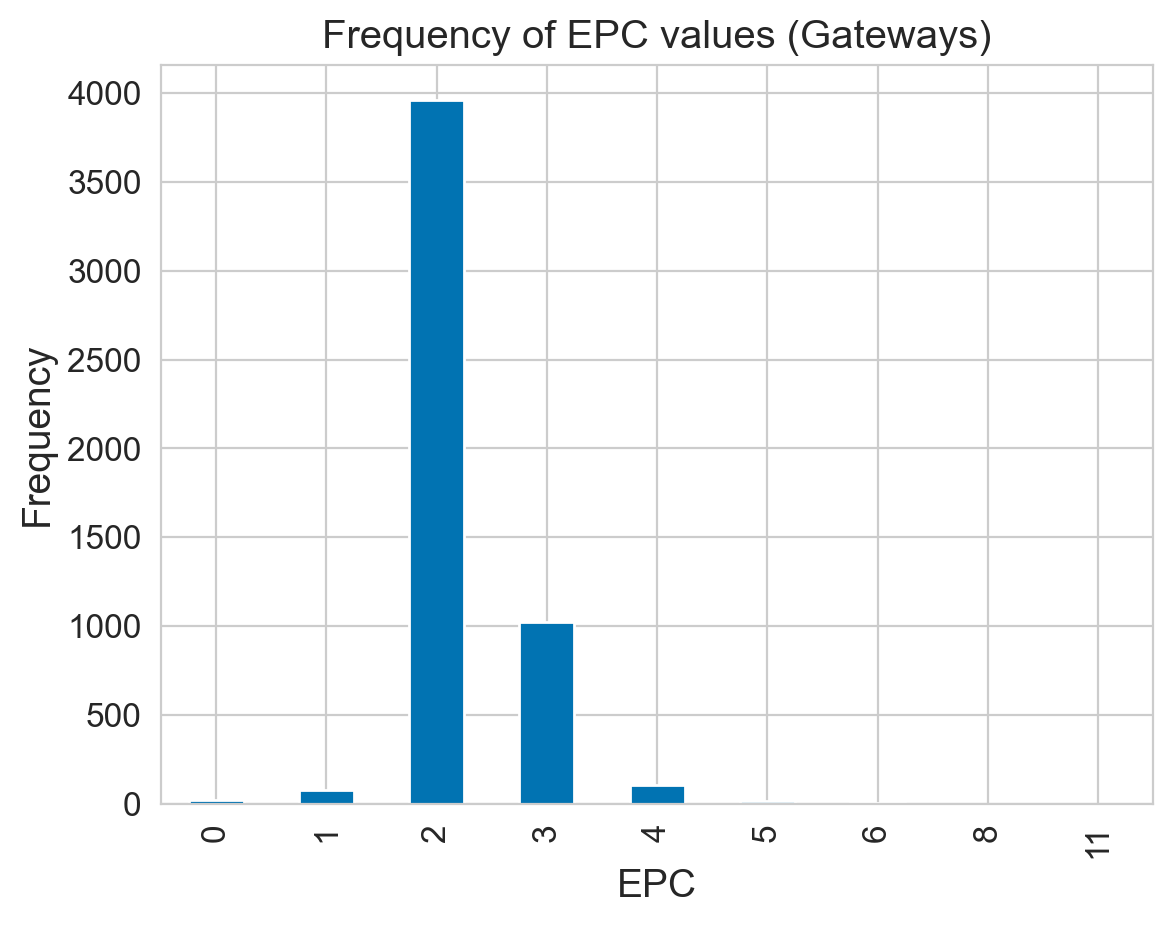

In [107]:
# Frequency of each unique value of outgoing counts
counts = max_outgoing_per_model.value_counts()

counts_sorted = counts.sort_index()
counts_sorted.plot(kind='bar')

plt.xlabel('EPC')
plt.ylabel('Frequency')
plt.title('Frequency of EPC values (Gateways)')

plt.show()

In [108]:
# Do EPC for Tasks and Subprocesses
df_tasks = df_rel.copy()

# Create new dataframe which only keeps Tasks and Subprocesses (->Activities) as elements
df_tasks = df_tasks[df_tasks['category'].str.contains('Task|Subprocess')]

# Count the number of outgoing elements
df_tasks['outgoing_count'] = df_tasks['outgoing'].apply(count_outgoing)

df_tasks.head()

category  \
model_id                         element_id                                          
1ba74449e9354d0c9d4798b4a6e915d0 sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB     Task   
                                 sid-0AF4FFAE-FAF7-46FA-AC03-3A011219E5F8     Task   
1ba744cbcafb46c2a52482e36498a9bf sid-F7A0EA5F-240D-433C-A911-C815B73F9A3F     Task   
                                 sid-31C0CE32-8227-44E5-B7F0-0501D5D57FB4     Task   
                                 sid-18206754-99AE-4C11-B9A7-BEB27E81FED5     Task   

                                                                                              label  \
model_id                         element_id                                                           
1ba74449e9354d0c9d4798b4a6e915d0 sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB           Narudžba pive\n   
                                 sid-0AF4FFAE-FAF7-46FA-AC03-3A011219E5F8           Izaberi pivu \n   
1ba744cbcafb46c2a52482e36498a9bf sid-F7A0EA5F-240D-433C-A911-C815B73F9A3F        Applicant verified   
                                 sid-31C0CE32-8227-44E5-B7F0-0501D5D57FB4            Send rejection   
                                 sid-18206754-99AE-4C11-B9A7-BEB27E81FED5  Send employment contract   

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB             None   
                                 sid-0AF4FFAE-FAF7-46FA-AC03-3A011219E5F8             None   
1ba744cbcafb46c2a52482e36498a9bf sid-F7A0EA5F-240D-433C-A911-C815B73F9A3F             None   
                                 sid-31C0CE32-8227-44E5-B7F0-0501D5D57FB4             None   
                                 sid-18206754-99AE-4C11-B9A7-BEB27E81FED5             None   

                                                                                                             parent  \
model_id                         element_id                                                                           
1ba74449e9354d0c9d4798b4a6e915d0 sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB  sid-3837E124-D7F7-4C2B-A5F4-BA743CF2FD49   
                                 sid-0AF4FFAE-FAF7-46FA-AC03-3A011219E5F8  sid-3837E124-D7F7-4C2B-A5F4-BA743CF2FD49   
1ba744cbcafb46c2a52482e36498a9bf sid-F7A0EA5F-240D-433C-A911-C815B73F9A3F  sid-9D11AC02-BBF7-4B61-8588-A29D3B202BF4   
                                 sid-31C0CE32-8227-44E5-B7F0-0501D5D57FB4  sid-8DBE3021-A2E8-4E7A-9D02-89FA911FE09C   
                                 sid-18206754-99AE-4C11-B9A7-BEB27E81FED5  sid-8DBE3021-A2E8-4E7A-9D02-89FA911FE09C   

                                                                                                                    outgoing  \
model_id                         element_id                                                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB                                                 []   
                                 sid-0AF4FFAE-FAF7-46FA-AC03-3A011219E5F8  [sid-ED915395-D5F6-44D6-80C5-11D279EBC262, sid...   
1ba744cbcafb46c2a52482e36498a9bf sid-F7A0EA5F-240D-433C-A911-C815B73F9A3F         [sid-58D7F22F-653D-4A28-B5F8-79B0E474B913]   
                                 sid-31C0CE32-8227-44E5-B7F0-0501D5D57FB4  [sid-BD006801-68D5-417A-8C04-86D025A71CA8, sid...   
                                 sid-18206754-99AE-4C11-B9A7-BEB27E81FED5  [sid-FBD58EAF-917F-4C1A-BED2-DFFDBFBDCF68, sid...   

                                                                                             name  \
model_id                         element_id                                                         
1ba74449e9354d0c9d4798b4a6e915d0 sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB                    Pivo   
                                 sid-0AF4FFAE-FAF7-46FA-

In [109]:
# delete later

df_tasks.loc['1ba758f87e744ff0bcb3119887cac8cc']
#df_tasks_in[df_tasks_in['model_id'] =='1ba758f87e744ff0bcb3119887cac8cc']

category  \
element_id                                          
sid-9608EF63-67F0-443A-BC70-C32CC09C35CA     Task   
sid-F36B054A-2026-4C24-9847-BA4E7CE76111     Task   
sid-B9A92FA2-D88C-466F-AB75-1A9716DD0431     Task   
sid-58D81F1E-C8AC-4269-A63F-5E22A2624DA7     Task   
sid-CCDDE03C-076D-4E5F-8CA7-C55ADCA9ED34     Task   
sid-BD353544-E485-4CD4-9D25-A6E611ACF6ED     Task   

                                                                            label  \
element_id                                                                          
sid-9608EF63-67F0-443A-BC70-C32CC09C35CA                    A student visits ACBT   
sid-F36B054A-2026-4C24-9847-BA4E7CE76111                         Direct to ECU SL   
sid-B9A92FA2-D88C-466F-AB75-1A9716DD0431                           Direct to ACBT   
sid-58D81F1E-C8AC-4269-A63F-5E22A2624DA7                A student with OL results   
sid-CCDDE03C-076D-4E5F-8CA7-C55ADCA9ED34  A student with AL results or equivalent   
sid-BD353544-E485-4CD4-9D25-A6E611ACF6ED                  A student visits ECU SL   

                                         glossary_link_id  parent  \
element_id                                                          
sid-9608EF63-67F0-443A-BC70-C32CC09C35CA             None  canvas   
sid-F36B054A-2026-4C24-9847-BA4E7CE76111             None  canvas   
sid-B9A92FA2-D88C-466F-AB75-1A9716DD0431             None  canvas   
sid-58D81F1E-C8AC-4269-A63F-5E22A2624DA7             None  canvas   
sid-CCDDE03C-076D-4E5F-8CA7-C55ADCA9ED34             None  canvas   
sid-BD353544-E485-4CD4-9D25-A6E611ACF6ED             None  canvas   

                                                                            outgoing  \
element_id                                                                             
sid-9608EF63-67F0-443A-BC70-C32CC09C35CA  [sid-DE77968B-CB24-41FE-86A3-FBAFA4F0D4C3]   
sid-F36B054A-2026-4C24-9847-BA4E7CE76111                                          []   
sid-B9A92FA2-D88C-466F-AB75-1A9716DD0431                                          []   
sid-58D81F1E-C8AC-4269-A63F-5E22A2624DA7  [sid-D1618AB9-5671-44D1-8E06-B835CDC3CC3E]   
sid-CCDDE03C-076D-4E5F-8CA7-C55ADCA9ED34  [sid-AF32AB1C-AB77-466C-99C3-459812245EE9]   
sid-BD353544-E485-4CD4-9D25-A6E611ACF6ED  [sid-E4FF53F5-BA02-47D2-A165-5E131664BC9E]   

                                                       name  outgoing_count  
element_id                                                                   
sid-9608EF63-67F0-443A-BC70-C32CC09C35CA  ECU application p               1  
sid-F36B054A-2026-4C24-9847-BA4E7CE76111  ECU application p               0  
sid-B9A92FA2-D88C-466F-AB75-1A9716DD0431  ECU application p               0  
sid-58D81F1E-C8AC-4269-A63F-5E22A2624DA7  ECU application p               1  
sid-CCDDE03C-076D-4E5F-8CA7-C55ADCA9ED34  ECU application p               1  
sid-BD353544-E485-4CD4-9D25-A6E611ACF6ED  ECU application p               1

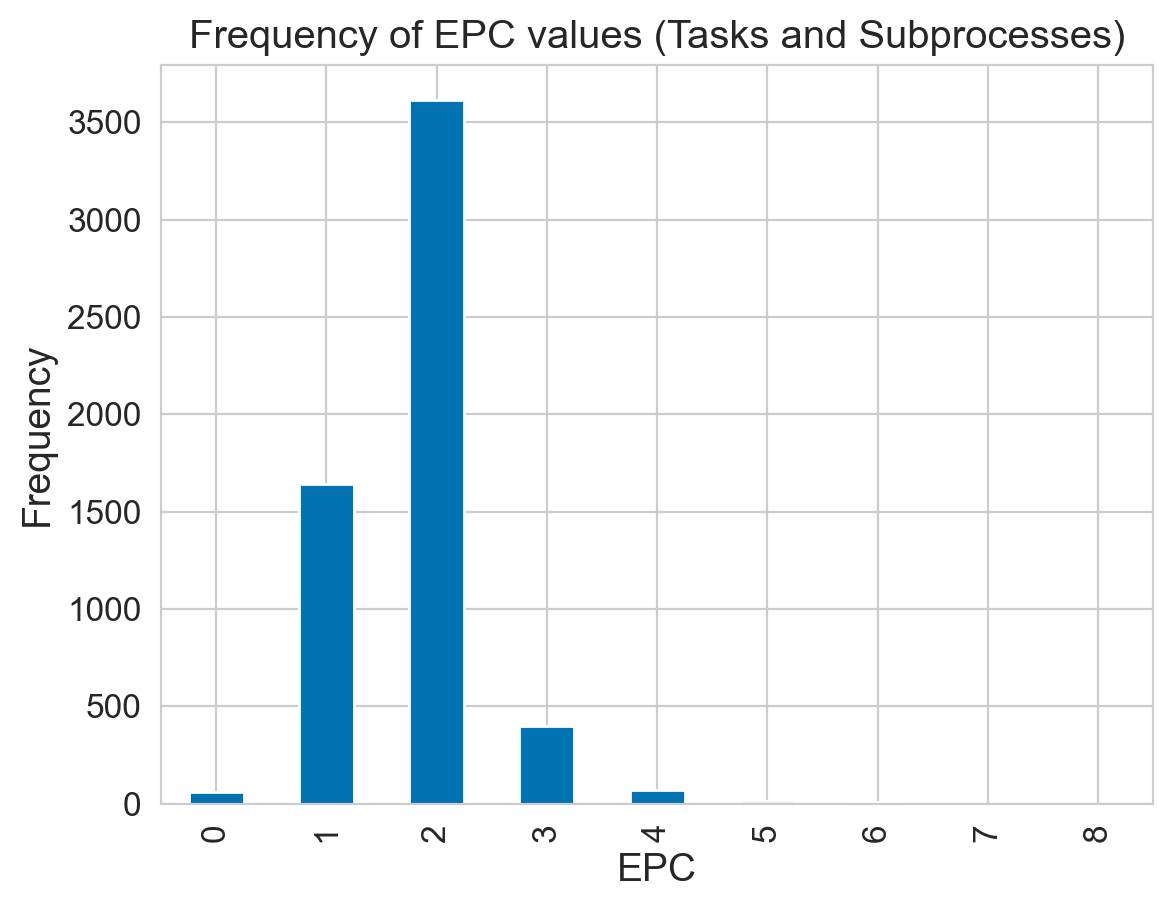

In [110]:
# Group by 'model_id' and calculate the maximum outgoing count within each model
max_outgoing_per_model2 = df_tasks.groupby('model_id')['outgoing_count'].max()
max_outgoing_per_model2 = max_outgoing_per_model2.rename('EPC')

# Frequency of each unique value of outgoing counts
counts2 = max_outgoing_per_model2.value_counts()

counts_sorted2 = counts2.sort_index()
counts_sorted2.plot(kind='bar')

plt.xlabel('EPC')
plt.ylabel('Frequency')
plt.title('Frequency of EPC values (Tasks and Subprocesses)')

plt.show()

__Imported Coupling of a Process metric (ICP)__

_Description: ICP is a coupling metric that focuses on process if it is highly dependent on external services offered by other processes._

In [111]:
# Incoming connections
# Since we do not have a column of the number of incoming connections, we need to extract this information out of the outgoing lists

# Explode the 'outgoing' lists into separate rows (resolve the list)
df_incoming = df_rel.explode('outgoing')

# Group by 'model_id' and 'outgoing', then count occurrences -> receive number of occurences in outgoing column per element_id
incoming_counts = df_incoming.groupby(['model_id', 'outgoing']).size()

incoming_counts = incoming_counts.reset_index()
incoming_counts.columns = ['model_id', 'element_id', 'number_incoming']

# Merge the outgoing_counts DataFrame with the original DataFrame on 'model_id' and 'element_id'
df_incoming_counts = pd.merge(incoming_counts, df_rel[['category']], on=['model_id', 'element_id'], how='left')

df_incoming_counts.head(10)

model_id                                element_id  \
0  1ba74449e9354d0c9d4798b4a6e915d0  sid-0AF4FFAE-FAF7-46FA-AC03-3A011219E5F8   
1  1ba74449e9354d0c9d4798b4a6e915d0  sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB   
2  1ba74449e9354d0c9d4798b4a6e915d0  sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246   
3  1ba74449e9354d0c9d4798b4a6e915d0  sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD   
4  1ba74449e9354d0c9d4798b4a6e915d0  sid-EC935BD2-9B8B-4412-A208-A5091471374A   
5  1ba74449e9354d0c9d4798b4a6e915d0  sid-ED915395-D5F6-44D6-80C5-11D279EBC262   
6  1ba744cbcafb46c2a52482e36498a9bf  sid-05963777-48BF-4F75-B546-CBFFCEA3AE4D   
7  1ba744cbcafb46c2a52482e36498a9bf  sid-1809C426-6409-43F2-AD67-66E163ACA06F   
8  1ba744cbcafb46c2a52482e36498a9bf  sid-18206754-99AE-4C11-B9A7-BEB27E81FED5   
9  1ba744cbcafb46c2a52482e36498a9bf  sid-25311BE5-F820-4CB8-B325-EA5EA5E655AD   

   number_incoming                     category  
0                1                         Task  
1                1                         Task  
2                1            StartMessageEvent  
3                1                  MessageFlow  
4                1                 SequenceFlow  
5                1                 SequenceFlow  
6                2  Exclusive_Databased_Gateway  
7                1                 EndNoneEvent  
8                1                         Task  
9                1            StartMessageEvent

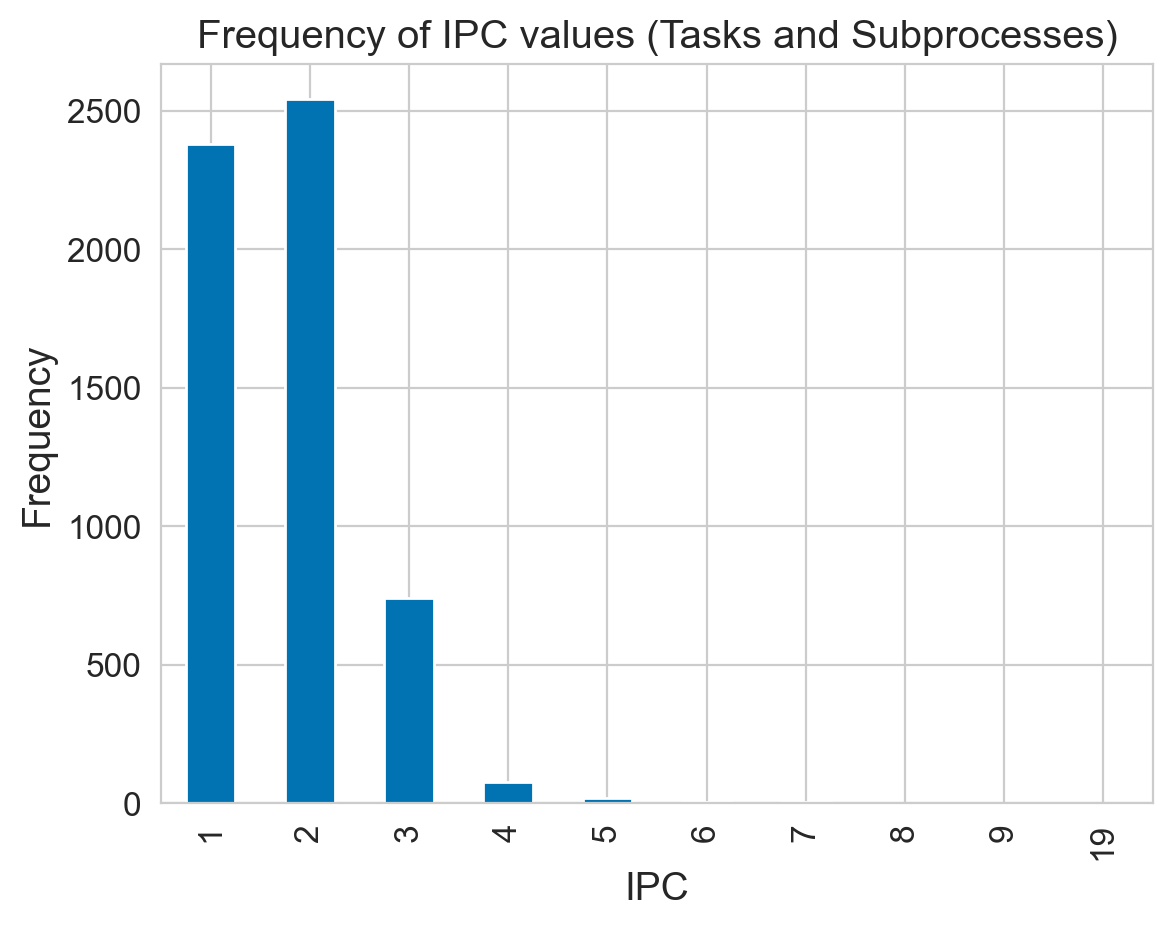

In [112]:
# There exist two elements which have NaN categorgy. Fill missing values in 'category' column with an empty string to further proceed
df_incoming_counts['category'] = df_incoming_counts['category'].astype(str)
df_incoming_counts['category'] = df_incoming_counts['category'].fillna('')

# Filter on Tasks and Subprocesses only for calculating IPC
df_tasks_in = df_incoming_counts[df_incoming_counts['category'].str.contains('Task|Subprocess')]

# Group by 'model_id' and calculate the maximum outgoing count within each model
max_in_per_model = df_tasks_in.groupby('model_id')['number_incoming'].max()
max_in_per_model = max_in_per_model.rename('IPC')

# Frequency of each unique value of outgoing counts
counts_in = max_in_per_model.value_counts()

counts_in_sorted = counts_in.sort_index()
counts_in_sorted.plot(kind='bar')

plt.xlabel('IPC')
plt.ylabel('Frequency')
plt.title('Frequency of IPC values (Tasks and Subprocesses)')

plt.show()

__Fan-in/Fan-out metric (FIO)__

_FIO metric can be used to analyse the complexity of business process model based on the modular structure. Modular modelling is supported in BPMN by sub-processes._

In [113]:
# Merge outgoing and incoming counts in a data frame
df_counts = pd.merge(df_incoming_counts[['model_id', 'element_id', 'number_incoming']], 
                     df_tasks[['outgoing_count', 'category']], 
                     on=['model_id', 'element_id'], 
                     how='right')

In [114]:
# There exist two elements which have NaN categorgy. Fill missing values in 'category' column with an empty string to further proceed
df_counts['number_incoming'] = df_counts['number_incoming'].fillna(0)
df_counts['number_incoming'] = df_counts['number_incoming'].astype(int)

In [115]:
# Filter on Subprocesses for calculating FIO
df_fio = df_counts[df_counts['category'].str.contains('Subprocess')]

In [116]:
# Initialize FIO column
df_fio.loc[:, 'FIO'] = 0

# Calculate FIO 
df_fio.loc[:, 'FIO'] = (df_fio['outgoing_count'] * df_fio['number_incoming']).pow(2)
FIO_per_model = df_fio.groupby('model_id')['FIO'].max()

/var/folders/kh/58f56r354rsbjqgq1305hfvm0000gn/T/ipykernel_31839/2708712274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fio.loc[:, 'FIO'] = 0


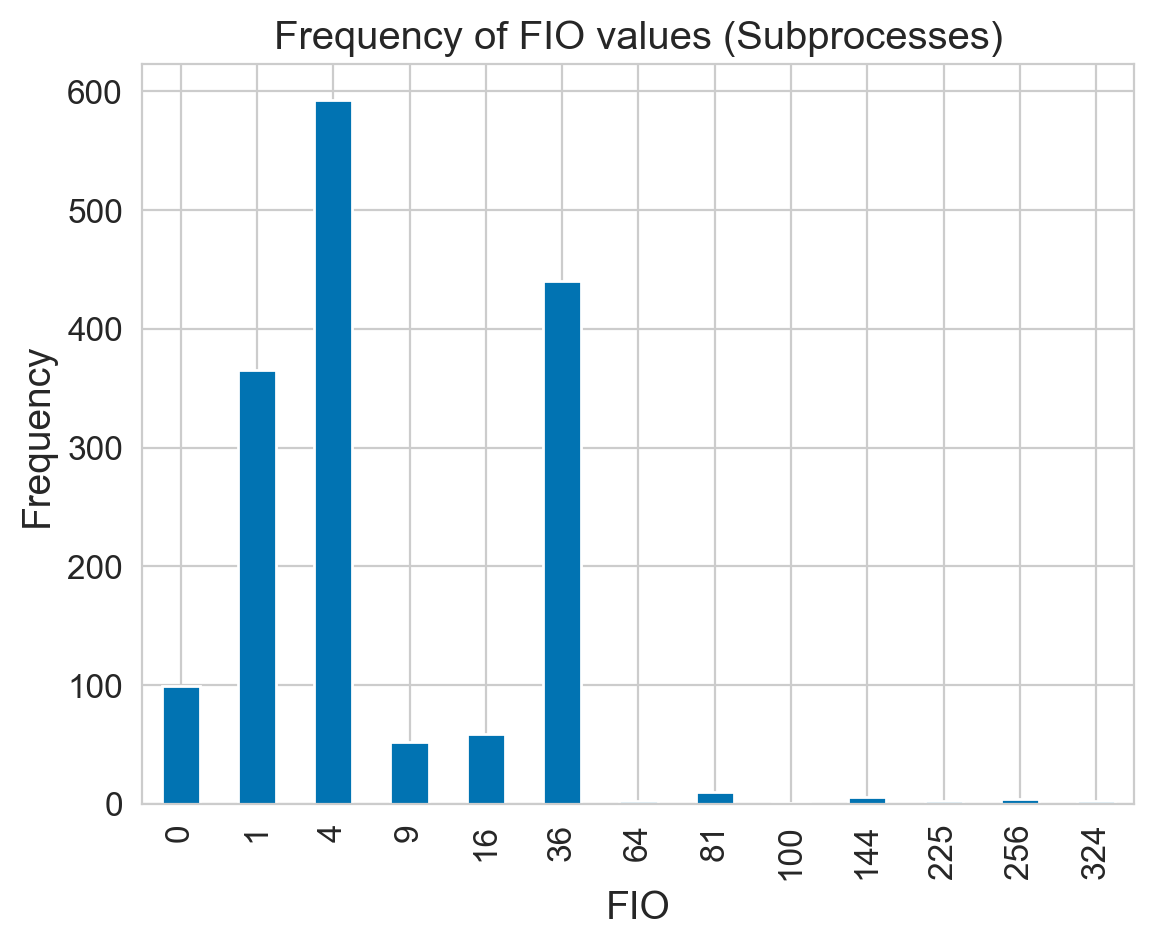

In [117]:
counts_FIO = FIO_per_model.value_counts()

counts_FIO_sorted = counts_FIO.sort_index()
counts_FIO_sorted.plot(kind='bar')

plt.xlabel('FIO')
plt.ylabel('Frequency')
plt.title('Frequency of FIO values (Subprocesses)')

plt.show()

__Interface complexity of an activity metric (IC)__

_IC metric can be used to evaluate the complexity of processes
-> Interface complexity value of a BPMN model._

It is similar to FIO but for IC, we are looking at activities instead of subprocesses.

In [118]:
# Filter on Tasks only for calculating FIO
df_ic = df_counts[df_counts['category'].str.contains('Task')]

In [119]:
# Initialize IC column with zeros
df_ic.loc[:, 'IC'] = 0.0

# Calculate IC 
df_ic.loc[:, 'IC'] = (df_ic['outgoing_count'] * df_ic['number_incoming']).pow(2)
IC_per_model = df_ic.groupby('model_id')['IC'].sum().round(1)

/var/folders/kh/58f56r354rsbjqgq1305hfvm0000gn/T/ipykernel_31839/2878451163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ic.loc[:, 'IC'] = 0.0


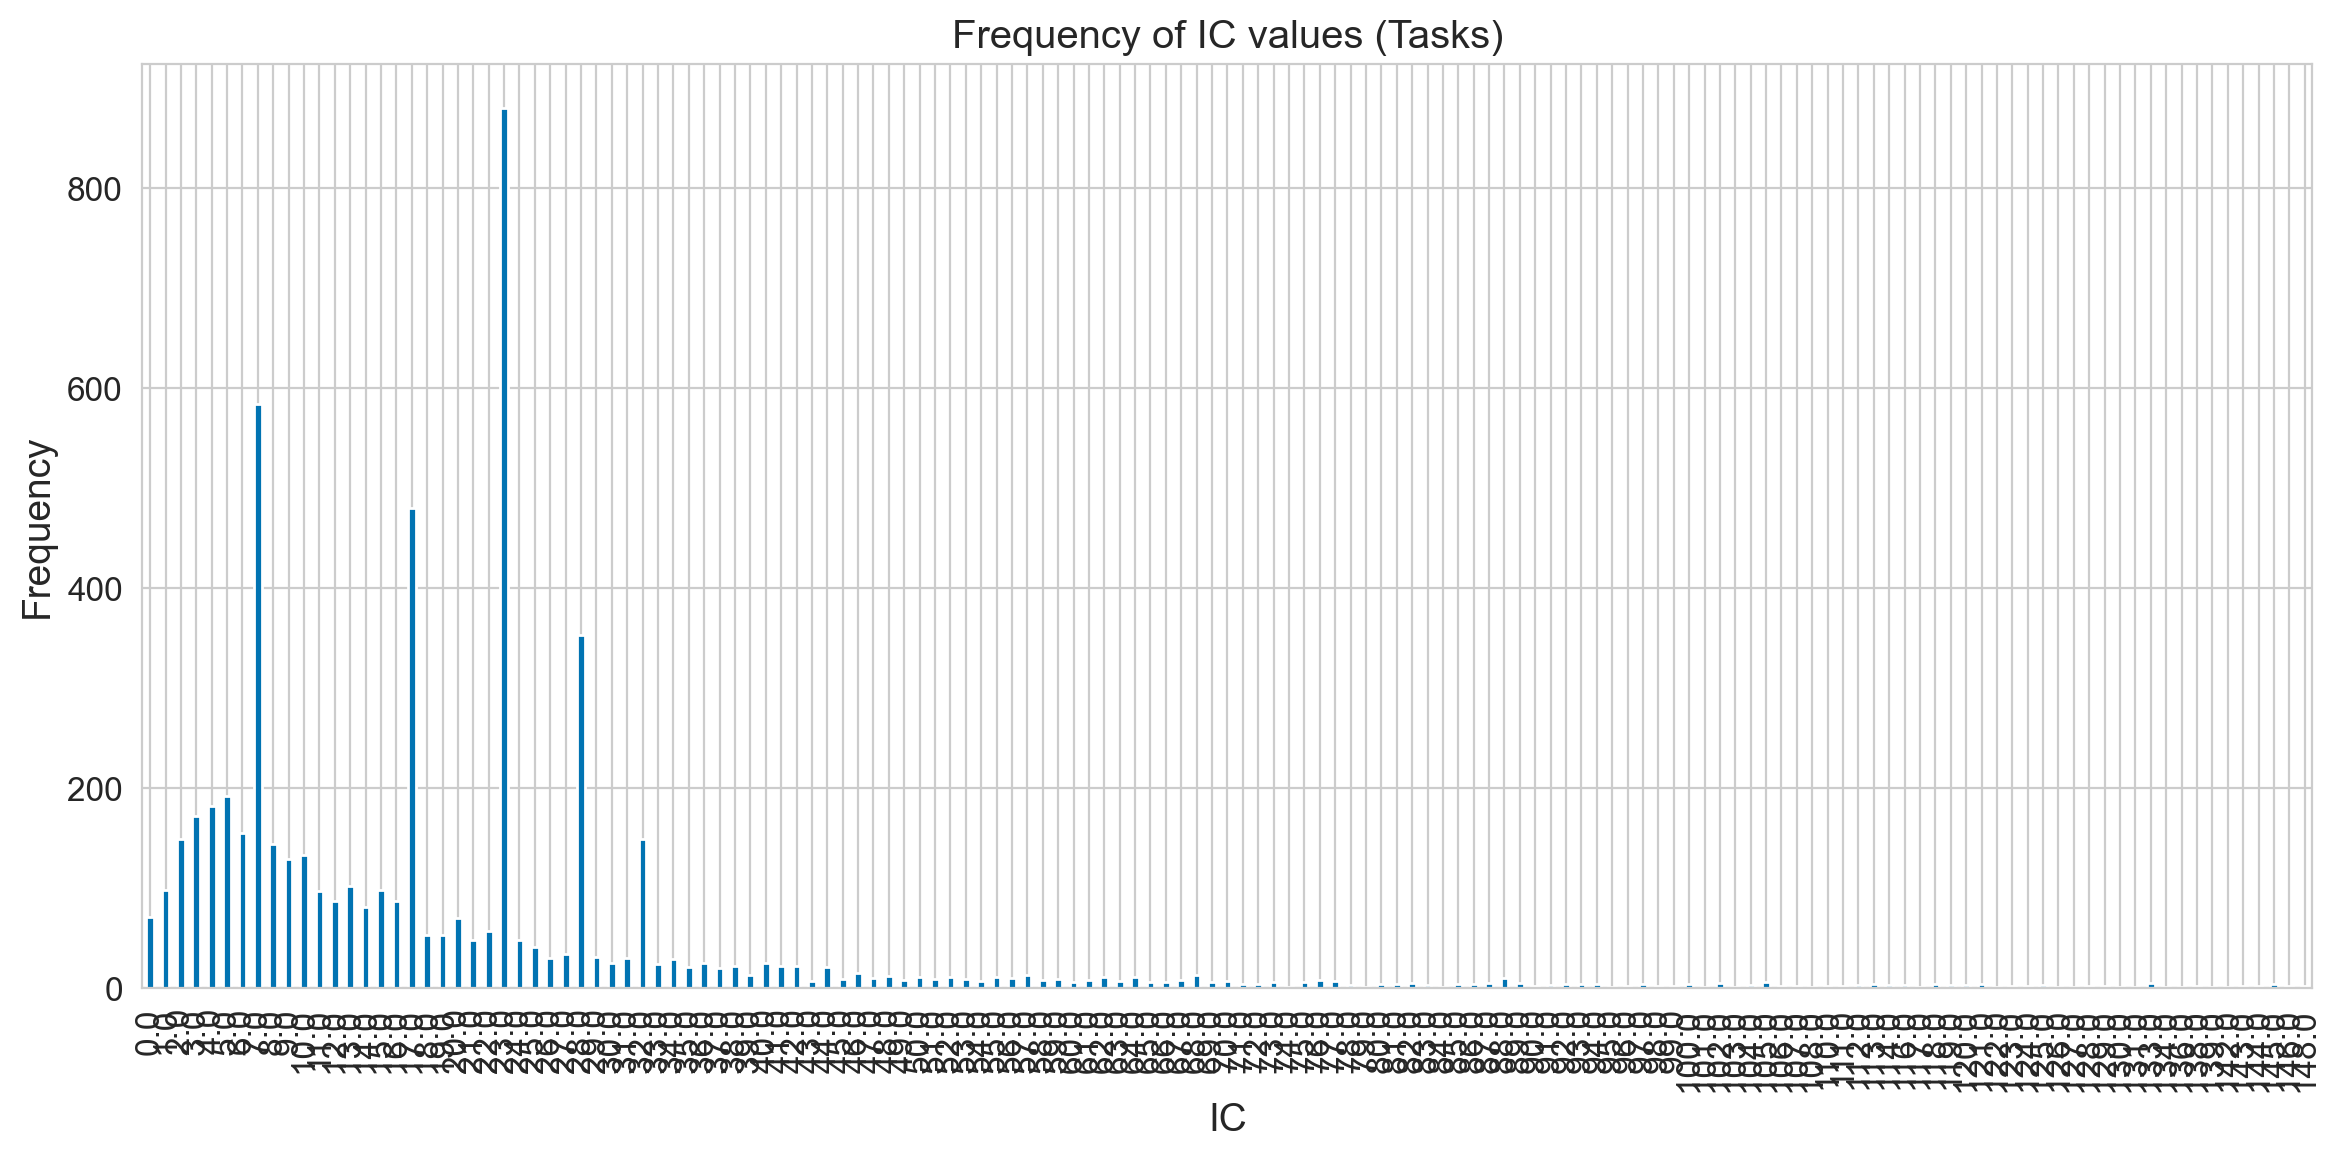

In [120]:
counts_IC = IC_per_model.value_counts()

counts_IC_sorted = counts_IC.sort_index()

counts_IC_sorted2 = counts_IC_sorted[counts_IC_sorted.index < 150]

plt.figure(figsize=(14, 6))

counts_IC_sorted2.plot(kind='bar')

plt.xlabel('IC')
plt.ylabel('Frequency')
plt.title('Frequency of IC values (Tasks)')

plt.show()

__Halsted-based Process Metrics__

- __Halsted-based Process Difficulty metric (HPC_D)__: HPC_D is a quantitative measure of complexity and is aimed to calculate a difficulty of the process.
- __Halsted-based Process Length metric (HPC_N)__: HPC_N is a quantitative measure of complexity and is aimed to calculate a length of the process.
- __Halsted-based Process Volume metric (HPC_V)__: HPC_V is a quantitative measure of complexity and is aimed to calculate a volume of the process. 

In [121]:
df_temp = df_rel.copy()

# Activities and control-flow elements
df_act_cf = df_temp[df_temp['category'].str.contains('Task|Event|Gateway|SequenceFlow')]
# n_1: number of unique activities and control-flow elements
unique_act_cf = df_act_cf.groupby('model_id')['label'].nunique().reset_index(name='unique_act_cf')
# N_1: total number of activities and control-flow elements
total_act_cf = df_act_cf.groupby('model_id')['label'].count().reset_index(name='total_act_cf')

# Data types
df_data_types = df_temp[df_temp['category'].str.contains('DataObject|DataStore')]
# n_2: number of unique data objects and data stores
unique_datatypes = df_data_types.groupby('model_id')['label'].nunique().reset_index(name='unique_datatypes')
# N_2: total number of data objects and data stores
total_datatypes = df_data_types.groupby('model_id')['label'].count().reset_index(name='total_datatypes')

# Merge all the results into a final DataFrame
df_halsted = unique_act_cf.merge(total_act_cf, on='model_id', how='outer')\
                        .merge(unique_datatypes, on='model_id', how='outer')\
                        .merge(total_datatypes, on='model_id', how='outer')

# If any NaN values are present due to outer join, fill them with 0
df_halsted.fillna(0, inplace=True)

df_halsted.head()

model_id  unique_act_cf  total_act_cf  \
0  1ba74449e9354d0c9d4798b4a6e915d0            5.0           7.0   
1  1ba744cbcafb46c2a52482e36498a9bf           18.0          18.0   
2  1ba7587b3191422fb03a0e9ba92cebff           18.0          34.0   
3  1ba758f87e744ff0bcb3119887cac8cc            7.0          13.0   
4  1ba77121c3be44d6bd0b354727f9707b           20.0          52.0   

   unique_datatypes  total_datatypes  
0               0.0              0.0  
1               1.0              1.0  
2               0.0              0.0  
3               0.0              0.0  
4               1.0              1.0

In [122]:
# Halsted-based Process Difficulty metric (HPC_D)
def HPC_D(row):
    n_1 = row['unique_act_cf']
    N_2 = row['total_datatypes']
    n_2 = row['unique_datatypes']
    
    if n_2 > 0:
        D = (n_1 / 2) * (N_2 / n_2)
    else:
        D = 0

    return D

# Halsted-based Process Length metric (HPC_N)
def HPC_N(row):
    n_1 = row['unique_act_cf']
    n_2 = row['unique_datatypes']
    if pd.isna(n_1) or n_1 == 0:
        term1 = 0
    else:
        term1 = n_1 * np.log2(n_1)
    if pd.isna(n_2) or n_2 == 0:
        term2 = 0
    else:
        term2 = n_2 * np.log2(n_2)
    return term1 + term2

# Halsted-based Process Volume metric (HPC_V)
def HPC_V(row):
    N_1 = row['total_act_cf']
    N_2 = row['total_datatypes']
    n_1 = row['unique_act_cf']
    n_2 = row['unique_datatypes']

    sum_N = N_1 + N_2
    sum_n = n_1 + n_2

    if sum_n > 0:
        log_sum_n = np.log2(sum_n)
    else:
        log_sum_n = 0

    return sum_N * log_sum_n

In [123]:
df_halsted['HPC_D'] = df_halsted.apply(HPC_D, axis=1)
df_halsted['HPC_N'] = df_halsted.apply(HPC_N, axis=1)
df_halsted['HPC_V'] = df_halsted.apply(HPC_V, axis=1)

In [124]:
df_halsted.describe()

unique_act_cf  total_act_cf  unique_datatypes  total_datatypes  \
count    5830.000000   5830.000000       5830.000000      5830.000000   
mean       15.815780     29.198628          0.990738         1.170669   
std        11.963891     32.976153          1.968943         2.968965   
min         0.000000      0.000000          0.000000         0.000000   
25%         9.000000     13.000000          0.000000         0.000000   
50%        15.000000     18.000000          0.000000         0.000000   
75%        18.000000     34.000000          2.000000         2.000000   
max       255.000000    880.000000         46.000000        88.000000   

             HPC_D        HPC_N        HPC_V  
count  5830.000000  5830.000000  5830.000000  
mean      4.221820    69.433384   135.855397  
std      13.069030    80.356858   221.365337  
min       0.000000     0.000000     0.000000  
25%       0.000000    28.529325    57.110324  
50%       0.000000    58.603359    75.058650  
75%       6.500000    75.058650   145.947375  
max     601.333333  2292.643976  7657.266299

__Cognitive complexity measure (W)__

_Cognitive complexity measure is a cognitive weight proposed to measure the effort needed for comprehending the model._

Cognitive weights for BPMN models in Cognitive Complexity Measure (presented in paper [26]):
- Single consecutive step in a work-flow: 1
- Joints: 1
- XOR-split (exactly one of two branches is chosen): 2
- XOR-split (exactly one of more than two branches is chosen): 3
- AND-split: 4
- OR-split or Complex Gateway: 7
- Sub-process: 2
- Start or End event: 2
- Intermediate event: 3

In [125]:
# We need to add a category for XOR-split (exactly one of more than two branches is chosen)
# This can be done be splitting the category "Exclusive_Databased_Gateway" based on the outgoing count

df_temp = df_rel.copy()

df_temp['outgoing_count'] = df_temp['outgoing'].apply(count_outgoing)

def update_category(row):
    if row['category'] == 'Exclusive_Databased_Gateway' and row['outgoing_count'] > 2:
        return 'Exclusive_Databased_Gateway_3'
    return row['category']

df_temp['category'] = df_temp.apply(update_category, axis=1)

In [126]:
# Cognitive weights mapping

def assign_cognitive_weights(df):
    cognitive_weights = {
        "Task": 1,
        "CollapsedSubprocess": 2,
        "Subprocess": 2,
        "CollapsedEventSubprocess": 2,
        "EventSubprocess": 2,
        "Exclusive_Databased_Gateway": 2,
        "Exclusive_Databased_Gateway_3": 3,
        "EventbasedGateway": 2,
        "ParallelGateway": 4,
        "InclusiveGateway": 7,
        "ComplexGateway": 7,
        "StartNoneEvent": 2,
        "StartMessageEvent": 2,
        "StartTimerEvent": 2,
        "StartEscalationEvent": 2,
        "StartConditionalEvent": 2,
        "StartErrorEvent": 2,
        "StartCompensationEvent": 2,
        "StartSignalEvent": 2,
        "StartMultipleEvent": 2,
        "StartParallelMultipleEvent": 2,
        "IntermediateMessageEventCatching": 3,
        "IntermediateTimerEvent": 3,
        "IntermediateEscalationEvent": 3,
        "IntermediateConditionalEvent": 3,
        "IntermediateLinkEventCatching": 3,
        "IntermediateErrorEvent": 3,
        "IntermediateCancelEvent": 3,
        "IntermediateCompensationEventCatching": 3,
        "IntermediateSignalEventCatching": 3,
        "IntermediateMultipleEventCatching": 3,
        "IntermediateParallelMultipleEventCatching": 3,
        "IntermediateEvent": 3,
        "IntermediateMessageEventThrowing": 3,
        "IntermediateEscalationEventThrowing": 3,
        "IntermediateLinkEventThrowing": 3,
        "IntermediateCompensationEventThrowing": 3,
        "IntermediateSignalEventThrowing": 3,
        "IntermediateMultipleEventThrowing": 3,
        "EndNoneEvent": 2,
        "EndMessageEvent": 2,
        "EndEscalationEvent": 2,
        "EndErrorEvent": 2,
        "EndCancelEvent": 2,
        "EndCompensationEvent": 2,
        "EndSignalEvent": 2,
        "EndMultipleEvent": 2,
        "EndTerminateEvent": 2,
        "SequenceFlow": 1,
    }

    def get_weight(category):
        return cognitive_weights.get(category, 0)  # Default to 0 if category not found

    # Assign weights
    df['weight'] = df['category'].apply(get_weight)
    
    return df

In [127]:
df_weight = assign_cognitive_weights(df_temp)
df_weight['weight'].value_counts()

weight
1    149052
0     66848
2     39191
3     11240
4      3888
7       666
Name: count, dtype: int64

In [128]:
# Cognitive complexity measure (W)
df_cogn_weight = df_weight.groupby('model_id')['weight'].sum()

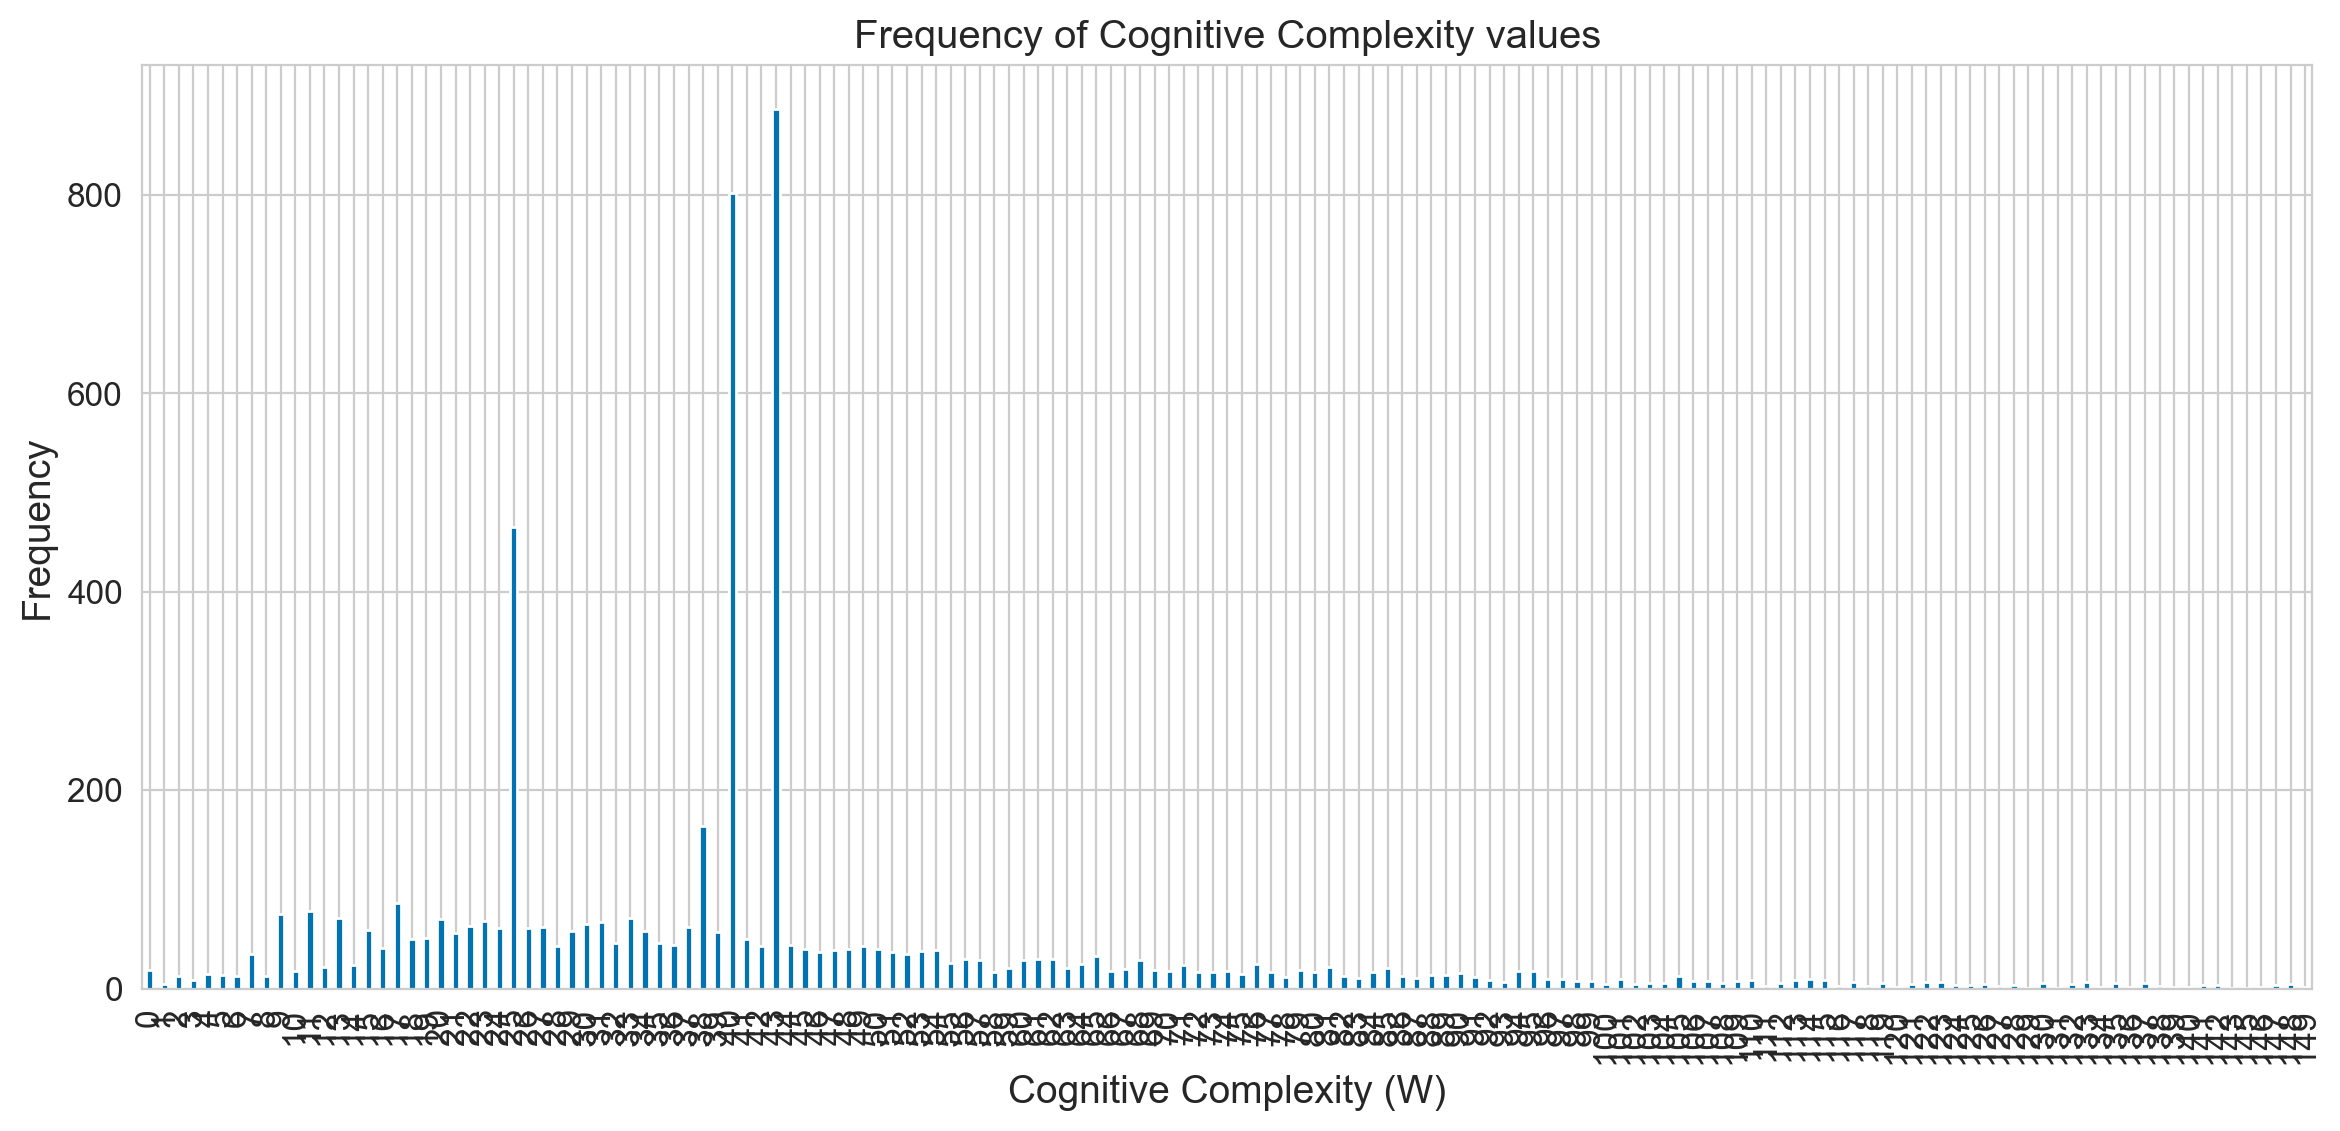

In [129]:
counts_W = df_cogn_weight.value_counts()
counts_W_sorted = counts_W.sort_index()

counts_W_sorted2 = counts_W_sorted[counts_W_sorted.index < 150]

plt.figure(figsize=(14, 6))

counts_W_sorted2.plot(kind='bar')

plt.xlabel('Cognitive Complexity (W)')
plt.ylabel('Frequency')
plt.title('Frequency of Cognitive Complexity values')

plt.show()

__Sequentiality Metric (S(G))__

_Description: S(G) is a structural metric. The sequentiality ratio is the number of arcs between none-connector nodes divided by the number of arcs._

In [130]:
# Create a new column which contains a list of the incoming element_id's

df_new = df_rel.copy()

# Extract outgoing lists
outgoing_dict = df_new['outgoing'].to_dict()

# Ingoing dictionary
incoming_dict = {index: [] for index in df_new.index}

for (model_id, element_id), outgoings in outgoing_dict.items():
    for target in outgoings:
        target_index = (model_id, target)
        if target_index in incoming_dict:
            incoming_dict[target_index].append(element_id)
        else:
            incoming_dict[target_index] = [element_id]

df_new['ingoing'] = df_new.index.map(incoming_dict)

In [131]:
df_new.head()

category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                                                             parent  \
model_id                         element_id                                                                           
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                                    canvas   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE                                    canvas   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  sid-00A06776-842A-40B5-9F67-A7A2B247CBAE   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  sid-3E27602D-0560-44E1-8089-4FC264FA9803   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                                    canvas   

                                                                                                             outgoing  \
model_id                         element_id                                                                             
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  [sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246]   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE                                          []   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                                          []   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246                                          []   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  [sid-6AEABE2C-DE4B-4141-8D40-382E25D82CEB]   

                                                                           name  \
model_id                         element_id                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo   
                                 sid-3E27602

In [132]:
# Identify non-connector nodes
df_new['is_non_connector'] = df_new.apply(lambda row: not row['outgoing'] or not row['ingoing'], axis=1)

# Explode the outgoing lists to flatten the DataFrame
df_exploded = df_new.explode('outgoing').reset_index()
df_exploded.rename(columns={'outgoing': 'target_element_id'}, inplace=True)

# Merge to determine if both source and target are non-connectors
df_exploded = df_exploded.merge(
    df_new.reset_index()[['model_id', 'element_id', 'is_non_connector']],
    left_on=['model_id', 'target_element_id'],
    right_on=['model_id', 'element_id'],
    suffixes=('', '_target')
)

# Calculate the arcs between non-connectors
df_exploded['is_arc_between_non_connectors'] = df_exploded['is_non_connector'] & df_exploded['is_non_connector_target']

# Calculate the sequentiality ratio per model id
sequentiality_ratios = df_exploded.groupby('model_id').apply(
    lambda df: round(df['is_arc_between_non_connectors'].sum() / len(df),2) if len(df) > 0 else 0
).reset_index(name='sequentiality_ratio')

/var/folders/kh/58f56r354rsbjqgq1305hfvm0000gn/T/ipykernel_31839/2780880705.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequentiality_ratios = df_exploded.groupby('model_id').apply(


__Coupling Metrics__

In [133]:
def is_connected(df, source, target):
        outgoing = df.loc[source, 'outgoing']
        if target in outgoing:
            return True
        return False


def calculate_cp_metric(df):
    results = []
    models = df.index.get_level_values('model_id').unique()
    
    for model_id in models:
        model_df = df.loc[model_id]
        tasks = model_df[model_df['category'] == 'Task'].index
        task_arcs = []
        
        for idx, task in enumerate(tasks):
            outgoing = model_df.at[task, 'outgoing']
            task_arcs.extend([(task, target) for target in outgoing if (model_df.at[target, 'category'] == 'Task')])

        total_arcs = len(task_arcs)
        connected_arcs = sum(1 for source, target in task_arcs if is_connected(model_df, source, target))
        
        cp_metric = round(connected_arcs / total_arcs, 2) if total_arcs > 0 else 0
        results.append((model_id, cp_metric))
    
    return pd.DataFrame(results, columns=['model_id', 'coupling_metric']).set_index('model_id')

# Calculate CP metrics
cp_metrics_df = calculate_cp_metric(df_rel)

In [134]:
def calculate_cp(df):
    
    df = df.reset_index()

    tasks_df = df[df['category'] == 'Task']
    sequence_flows = df[df['category'] == 'SequenceFlow']['element_id'].tolist()

    total_arcs = 0
    task_to_task_arcs = 0
    
    # Iterate over tasks
    for idx, row in tasks_df.iterrows():
        outgoing = row['outgoing']
        incoming = row['ingoing']
        
        # Filter outgoing and incoming to only include sequence flows
        outgoing_sequence_flows = [e for e in outgoing if e in sequence_flows]
        incoming_sequence_flows = [e for e in incoming if e in sequence_flows]
        
        # Count total arcs
        total_arcs += len(outgoing_sequence_flows)
        
        # Count task to task arcs
        for flow in outgoing_sequence_flows:
            target_task = df[df['element_id'] == flow]['outgoing'].tolist()
            if target_task and target_task[0] in tasks_df['element_id'].tolist():
                task_to_task_arcs += 1
    
    # Calculate CP
    cp_ratio = task_to_task_arcs / total_arcs if total_arcs > 0 else 0
    
    return cp_ratio

# Example usage
cp_per_model = df_new.groupby('model_id').apply(calculate_cp)

In [135]:
cp_per_model.value_counts()

0.0    5855
Name: count, dtype: int64

__Process User__

_The number of employees involved in a given process_

In [136]:
def process_user(df):
    df = df.reset_index()
    filtered_df = df[df['category'].isin(['processparticipant', 'Lane'])]
    user = filtered_df.groupby('model_id').agg(process_user=('element_id', 'nunique')).reset_index()
    
    return user

In [137]:
process_user = process_user(df_rel)
process_user.head(5)

model_id  process_user
0  1ba74449e9354d0c9d4798b4a6e915d0             2
1  1ba744cbcafb46c2a52482e36498a9bf             4
2  1ba7587b3191422fb03a0e9ba92cebff             3
3  1ba77121c3be44d6bd0b354727f9707b             5
4  1ba7b40cfd804781a4aaa394635d1760             1

__Workload__

_Measures the volume of work handled by an employee, which could be the number of tasks, calls, or product units processed_

In [138]:
# Workload: avg./max task per lane
def workload(df):

    task_df = df[df['category'].isin(['Task'])]
    workload = task_df.groupby(['model_id', 'parent']).size().reset_index(name='tasks_per_lane')
    
    return workload

In [139]:
max_workload = workload(df_rel).groupby('model_id')['tasks_per_lane'].max()
max_workload.head()

model_id
1ba74449e9354d0c9d4798b4a6e915d0    2
1ba744cbcafb46c2a52482e36498a9bf    6
1ba7587b3191422fb03a0e9ba92cebff    8
1ba758f87e744ff0bcb3119887cac8cc    6
1ba77121c3be44d6bd0b354727f9707b    5
Name: tasks_per_lane, dtype: int64

In [140]:
mean_workload = workload(df_rel).groupby('model_id')['tasks_per_lane'].mean()
mean_workload.head()

model_id
1ba74449e9354d0c9d4798b4a6e915d0    2.0
1ba744cbcafb46c2a52482e36498a9bf    3.5
1ba7587b3191422fb03a0e9ba92cebff    4.0
1ba758f87e744ff0bcb3119887cac8cc    6.0
1ba77121c3be44d6bd0b354727f9707b    3.0
Name: tasks_per_lane, dtype: float64

__Business Process Autonomy__

_Measures the extent to which a business process operates independently of other processes by assessing the proportion of activities relying on external inputs._

In [141]:
ext_input_cat = ['Data Elements', 'Events', 'Swimlanes', 'Artifacts']

def business_process_autonomy(df, element_type_mapping, external_categories):

    df = df.reset_index()
    df['low_level_category'] = df['category'].map(element_type_mapping)
    
    df['external_dependency'] = df['low_level_category'].isin(external_categories)
    
    # Calculate autonomy for each model_id
    autonomy_per_model = df.groupby('model_id').apply(
        lambda group: group['external_dependency'].sum() / len(group)
    )

    return autonomy_per_model


autonomy_per_model = business_process_autonomy(df_new, d_low_level_mapping, ext_input_cat)
# print(autonomy_per_model)

/var/folders/kh/58f56r354rsbjqgq1305hfvm0000gn/T/ipykernel_31839/567730145.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  autonomy_per_model = df.groupby('model_id').apply(


__Operational Cost Propotion__

In [142]:
# Categories for manual and (non) value-added activities
# Caution with categories: since we don't have the information which tasks are performed manually and which ones add value,
# this is just a subjective classification which might not be true for all process models
manual_activities = ["Task"]
value_added_activities = ["Task", "Subprocess", "CollapsedSubprocess", "EventSubprocess", "CollapsedEventSubprocess"]
non_value_added_elements = ["Exclusive_Databased_Gateway", "EventbasedGateway", "ParallelGateway", "InclusiveGateway", "ComplexGateway",
                            "IntermediateMessageEventCatching", "IntermediateTimerEvent", "SequenceFlow", "Association_Undirected",
                            "MessageFlow"]

def operational_cost_proportion(df, manual_activities, non_value_added_elements):
    # Identify human-performed and non-value-added activities
    df['is_manual'] = df['category'].isin(manual_activities)
    df['is_non_value_added'] = df['category'].isin(non_value_added_elements)
    
    # Calculate the proportion for each model_id
    operational_cost_proportion = df.groupby('model_id').apply(
        lambda group: (group['is_manual'].sum() + group['is_non_value_added'].sum()) / len(group)
    )

    return operational_cost_proportion

# Calculate the operational cost proportion
operational_cost_proportion = operational_cost_proportion(df_new, manual_activities, non_value_added_elements)
#print(operational_cost_proportion)

__Cycle Time Efficiency__

_Assesses the efficiency of a business process by examining the proportion of automated and parallel activities relative to the total activities, aiming for shorter processing times._

In [158]:
# Caution with categories: since we don't have the information which tasks are performed automated,
# this is just a workaround classification which might not be true for all process models

# Automated activities: Tasks performed by (IT)-Systems
# Parallel activities: count outgoing from Parallel-Gateways

def cycle_time_efficiency(df):
    
    df = df.reset_index()
    df['low_level_category'] = df['category'].map(d_low_level_mapping)
    
    # Automated activities
    system_lanes = df[(df['category'] == 'Lane') & (df['label'].str.contains('System', na=False))]
    system_lane_ids = system_lanes.index.tolist()

    automated_activities = df[(df['low_level_category'] == 'Activity') & (df['parent'].isin(system_lane_ids))]
    
    # Parallel Activities
    parallel_activities = df[df['category'] == 'ParallelGateway']
    parallel_activities_count = parallel_activities['outgoing'].apply(lambda x: len(x) if isinstance(x, list) and len(x) > 1 else 0).sum()

    # Step 3: Calculate Cycle Time Efficiency
    total_activities = len(df[df['low_level_category'] == 'Activities'])
    num_automated_activities = len(automated_activities)
    
    if total_activities == 0:
        return 0
    
    cycle_time_efficiency = (num_automated_activities + parallel_activities_count) / total_activities
    
    return cycle_time_efficiency


# Calculate Cycle Time Efficiency for each model_id
cycle_time_efficiency_per_model = df_new.groupby('model_id').apply(cycle_time_efficiency).reset_index(name='cycle_time_efficiency')
#print(cycle_time_efficiency_per_model)    

__Up-to-date Business Process__

In [166]:
# Creation date
df_date = df_meta.copy()

df_date = df_date.sort_values(by='datetime', ascending=False)

# Ranking the models based on their creation date (0 being the most recent date)
df_date['datetime_rank'] = df_date['datetime'].rank(method='dense', ascending=False).astype(int) - 1

df_date.head()

revision_id  \
model_id                                                             
6540f5105d584712aa5489d6390569f9  7f9d9ec81a90417d99ec7193267c2222   
1c24f92573d14bce851cc58801b75f5b  8279ccfad071445f857d8c61c6e62463   
1e05dda50a7a486dae44a03c47bc5ca4  5252af873a7e44b7aabbf20a773446cf   
64e2935318df48b696568626dea809dc  7872d3eace7a40e48e18a6d66465305b   
64ff5689af68456a8d33b063ce0b608e  30713852101a49549792036cdf9dc741   

                                                   organization_id  \
model_id                                                             
6540f5105d584712aa5489d6390569f9  a44023786dc644adadc423ba4873ee09   
1c24f92573d14bce851cc58801b75f5b  c0c22de179a74fb3992604f625c5ab1e   
1e05dda50a7a486dae44a03c47bc5ca4  c0c22de179a74fb3992604f625c5ab1e   
64e2935318df48b696568626dea809dc  c0c22de179a74fb3992604f625c5ab1e   
64ff5689af68456a8d33b063ce0b608e  7973fe1261884a9bac69a1165c1a7b0c   

                                            datetime description  \
model_id                                                           
6540f5105d584712aa5489d6390569f9 2021-09-21 22:29:51         NaN   
1c24f92573d14bce851cc58801b75f5b 2021-09-21 21:01:49         NaN   
1e05dda50a7a486dae44a03c47bc5ca4 2021-09-21 20:53:43         NaN   
64e2935318df48b696568626dea809dc 2021-09-21 20:37:28         NaN   
64ff5689af68456a8d33b063ce0b608e 2021-09-21 17:55:14         NaN   

                                                            name type  \
model_id                                                                
6540f5105d584712aa5489d6390569f9  Blockchain or Central Database  NaN   
1c24f92573d14bce851cc58801b75f5b        Obtain witness statement  NaN   
1e05dda50a7a486dae44a03c47bc5ca4                      Example 11  NaN   
64e2935318df48b696568626dea809dc   customer follow-up subprocess  NaN   
64ff5689af68456a8d33b063ce0b608e     Deliver and Receive Payment  NaN   

                                                            namespace  Year  \
model_id                                                                      
6540f5105d584712aa5489d6390569f9  http://b3mn.org/stencilset/bpmn2.0#  2021   
1c24f92573d14bce851cc58801b75f5b  http://b3mn.org/stencilset/bpmn2.0#  2021   
1e05dda50a7a486dae44a03c47bc5ca4  http://b3mn.org/stencilset/bpmn2.0#  2021   
64e2935318df48b696568626dea809dc  http://b3mn.org/stencilset/bpmn2.0#  2021   
64ff5689af68456a8d33b063ce0b608e  http://b3mn.org/stencilset/bpmn2.0#  2021   

                                  Month  datetime_rank  
model_id                                                
6540f5105d584712aa5489d6390569f9      9              0  
1c24f92573d14bce851cc58801b75f5b      9              1  
1e05dda50a7a486dae44a03c47bc5ca4      9              2  
64e2935318df48b696568626dea809dc      9              3  
64ff5689af68456a8d33b063ce0b608e      9              4

__Possibilities for informal communication__

In [ ]:
# Frequency of Information Exchange: count message flows and events
# Number of Communication Channels:

__Test Model__ _(delete following lines when finished)_

In [172]:
# MessageFlow
# Association_Undirected
# Association_Unidirectional
# Association_Bidirectional

#df_new[df_new['category'] == 'Message']

In [170]:
#df_model_test = df_rel.loc['1ba744cbcafb46c2a52482e36498a9bf']
#df_model_test2 = df_new.loc['1ba77121c3be44d6bd0b354727f9707b'] -> gut zum testen
df_model_test3 = df_new.loc['1baeb792d444499f8369881dce6e7e20']

In [171]:
df_model_test3

category  \
element_id                                                                   
sid-FCD9AA1E-FC50-488B-A6EF-9353EB9A4C17                      SequenceFlow   
sid-38D86593-9E37-4728-8CE0-6AA1A7AAEA4E                      SequenceFlow   
sid-9C8E93C7-6E24-4EC0-8E3A-C7D67D48F618                      SequenceFlow   
sid-C5C4AA32-91DF-46C1-8421-6FF5AEEF5AC6                       MessageFlow   
sid-C2F88EDD-240E-490F-87CD-0C0058FF1D2A                           Message   
sid-1E32073D-4054-40FE-B894-C50B55DE8B3C                      SequenceFlow   
sid-85BD4620-4377-4AB6-9259-D23F308551F5                      SequenceFlow   
sid-30996776-DE3E-4B16-8688-70FD0C3ED242                      SequenceFlow   
sid-24912C3B-69CB-4625-AFFA-9DC36BDC07FF                      SequenceFlow   
sid-32822938-4584-436B-8825-36FFF845D0CE                      SequenceFlow   
sid-82CBD16A-C0A3-42E9-8377-599FA79813C6                      SequenceFlow   
sid-993E54DB-E139-437B-A231-C765F5704820                      SequenceFlow   
sid-8A909354-8CCD-46E2-BC5F-F2BF52133801                      SequenceFlow   
sid-9FA3B44B-FEB6-46B9-A229-CE9780305E5A                      SequenceFlow   
sid-079B32AE-1256-44AA-B726-715D6E55FA55                      SequenceFlow   
sid-C16B051E-CB60-46E9-AD49-D4ED0769B08A                      SequenceFlow   
sid-850C409B-F2BA-483E-A2F3-A67C39209042                      SequenceFlow   
sid-4E96C613-FA4B-4EC2-8309-4A84A4CE0B61                      SequenceFlow   
sid-736F51B3-5DFA-4B52-BDAB-72C89142634F                      SequenceFlow   
sid-68A9FE82-16BA-4FCF-ADDE-81F71614510C                      SequenceFlow   
sid-37233F20-EF9D-405E-A240-526413A38C78                       MessageFlow   
sid-89E25FC5-E99C-4643-8850-62B16A4BAC87                           Message   
sid-CF1E5F5D-45F4-4AC8-981E-E92326E0B8D0                       MessageFlow   
sid-6F1ADDC5-004B-4C08-AFA6-76628CB06318                           Message   
sid-CB9BF7C3-B562-4AA9-BD59-3096E03A02FE                      SequenceFlow   
sid-18F6A8A6-5029-4122-A6D0-9998FAECF5CE                      SequenceFlow   
sid-EAC5ED31-4630-415B-96B4-BB410FEEC132                      SequenceFlow   
sid-B8F01DE9-2216-43BD-87F3-FB3A881E5A4B                      SequenceFlow   
sid-9B69BFEF-008D-4BE3-8E3A-579B1907FB47                     CollapsedPool   
sid-12153054-515F-40B5-9F68-554638E11FD8                     CollapsedPool   
sid-4A2FDDE4-9F87-4BFE-B75E-E2F6773415BB                              Pool   
sid-9EF023B6-CBDF-42D1-BB9A-487EA02F3BA8                              Lane   
sid-7FDCD45A-38A3-49DB-9F06-37F7422A7FA8                              Task   
sid-9333CBC9-108A-4BD2-A746-0838E951FBA1                              Task   
sid-9AED78F5-9614-4F5D-9F53-A26B17362BE4                   ParallelGateway   
sid-168C80F7-CAD6-4A19-BE02-4E13E0C4E3E5                              Task   
sid-8602ADB5-F1D5-46AD-A76F-464BA3BFAE70                              Task   
sid-F90FBBFD-8EB8-4305-8112-41F96D6DAC90                              Task   
sid-881A6424-7143-4AAF-A26D-A3409F442209                              Task   
sid-AE62E96E-3827-49FA-AB53-B955295205CA                   ParallelGateway   
sid-76FC4723-2630-4BFD-B5CB-40BF91CFEAB5  IntermediateMessageEventCatching   
sid-2F22C1EF-388F-4E87-9615-4E1B204173E2                              Task   
sid-0FDAA493-212D-4B82-89CA-16E8E3ECEC56                              Task   
sid-A508A05E-3B15-4897-9FB8-92BC665D8436                              Task   
sid-B1A56A1F-E536-42F4-84C4-41509AA54AC4                              Lane   
sid-FD1B3A1D-B8D6-426D-814C-EDC4C332F094                              Task   
sid-0D53FB5B-F668-4E0C-96CF-43D069ADDA4E                      EndNoneEvent   
sid-6558B990-1528-4319-9E04-8B35DB005EBC            IntermediateTimerEvent   
sid-9A202BA1-57D3-45E1-9780-D3B43A0B0730                              Task   
sid-83ADE9D6-AE05-417E-BCF1-A1C3D627A435                              Task   
sid-37E3C5